# Load results data

In [3]:
import json

with open('full_results.json') as results_fh:
    results = json.load(results_fh)

# Make sure we lemmatize these
# Resolve coreferences

government_kw = {
    'government', 'government forces', 'state', 'authority', 'authorities', 'regime',
    'prime minister', 'president', 'police', 'police forces', 'army', 'armed forces', 
    'premier', 'officers', 'officer', 'military', 'troops', 'security forces', 'forces',
    'nicolas', 'maduro', 'hugo', 'chavez', 'diosdado', 'cabello',
    'emmanuel', 'macron', 'elysee', 'christophe', 'castaner',  'philippe', 'edouard',
    'carrie', 'lam', 'xi', 'jinping', 'beijing', 'chief executive',
    'irgc', 'ali', 'khamenei', 'ayatollah', 'fadavi', 'hassan', 'rouhani', 'zarif'
}

protesters_kw = {
    'protest', 'protester', 'protesters', 'demonstrator', 'demonstrators', 'rioter', 'rioters',
    'striker', 'agitator', 'dissenter', 'disrupter', 'revolter', 'marcher', 'dissident',
    'militant', 'activists', 'activist',
    'venezuelans', 'yellow vests', 'yellow vest', 'jackets',
    'juan', 'guaido', 'leopoldo', 'lopez',
    'maxime', 'nicolle', 'eric', 'drouet', 'christophe', 'chalençon', 'priscillia', 'ludosky',
    'jacline', 'mouraud', 'jerome', 'rodrigues', 'etienne', 'chouard', 'francois', 'boulo',
    'joshua', 'wong', 'chan', 'ho-tin', 'kongers',
    'mir-hossein', 'mousavi',
}


source_to_country = {'afp' : "France",
 'aljazeera' : "Quatar",
 'cnn' : "USA",
 'entornointeligente': "USA", #hmmmm
 'foxnews': "USA",
 'france24' : "France",
 'globaltimes' :"China",
 'hongkongfp' : "Hong-Kong",
 'ifpnews': "Iran",
 'iran-daily': "Iran",
 'laht' : "Venezuela",
 'meduza': "Russia",
 'nytimes': "USA",
 'rt' : "Russia",
 'scmp' : "Hong-Kong",
 'sputniknews': "Russia",
 'tehrantimes': "Iran",
 'themoscowtimes' : "Russia",
 'voanews': "USA"}


# Map scores

In [ ]:
from collections import defaultdict

KEYS = ['sentiment', 'power', 'agency', 'count']
def sumScores(entities):
    entity_score = {key : 0 for key in KEYS}
    for entity in entities:
        for key in KEYS:
            entity_score[key] += entity[key]
    return entity_score

riot_entity_scores = {}
gov_entity_scores = defaultdict( lambda: defaultdict(list))
protestor_entity_scores = defaultdict( lambda: defaultdict(list))
per_country_entity_scores = defaultdict( lambda: defaultdict(list))

global_entity_scores = defaultdict(list)
for riot in results:
    per_entity_scores = defaultdict(list)
    for src in results[riot]:
        for entity in results[riot][src]:
            per_entity_scores[entity].append(results[riot][src][entity])
            global_entity_scores[entity].append(results[riot][src][entity])
            if entity in government_kw:
                gov_entity_scores[riot][src].append(results[riot][src][entity])
            else:
                protestor_entity_scores[riot][src].append(results[riot][src][entity])
            
            per_country_entity_scores[riot][source_to_country[src]].append(results[riot][src][entity])

    riot_entity_scores[riot] = {entity : sumScores(scores) for entity,scores in per_entity_scores.items()}

global_entity_scores = {entity : sumScores(scores) for entity, scores in global_entity_scores.items()}
#print(riot_entity_scores)

In [12]:
def aggregateScores(curr_dict, choose_source=True):
    curr_source_scores = defaultdict(list)
    for riot in curr_dict:
        for source in curr_dict[riot]:
            key = riot
            if choose_source:
                key = source
            curr_source_scores[key] += curr_dict[riot][source]
    return {src: sumScores(curr_source_scores[src]) for src in curr_source_scores}



protestor_source_scores = aggregateScores(protestor_entity_scores)
protestor_riot_scores = aggregateScores(protestor_entity_scores, choose_source=False)
gov_source_scores = aggregateScores(gov_entity_scores)
gov_riot_scores = aggregateScores(gov_entity_scores, choose_source=False)

# Graphs

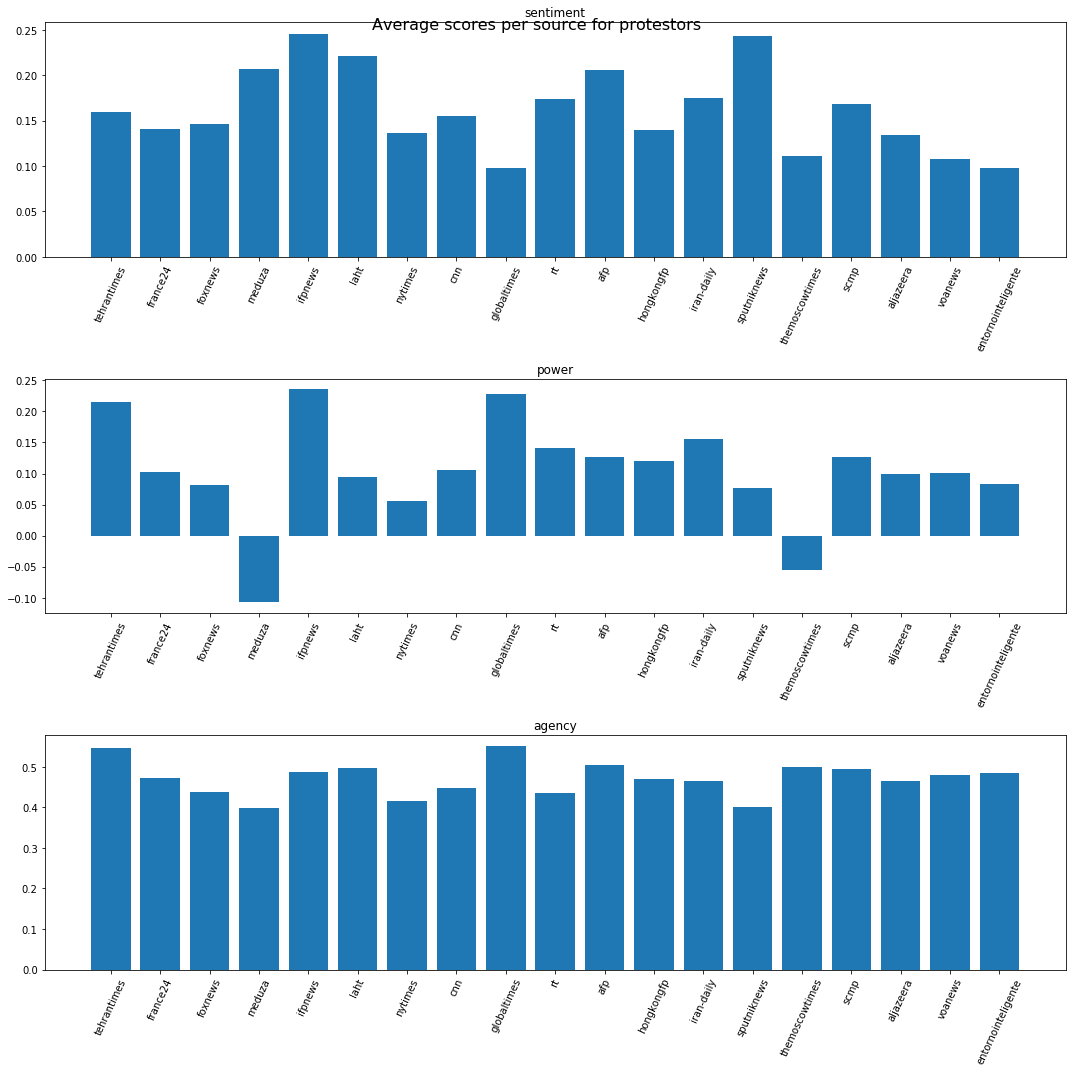

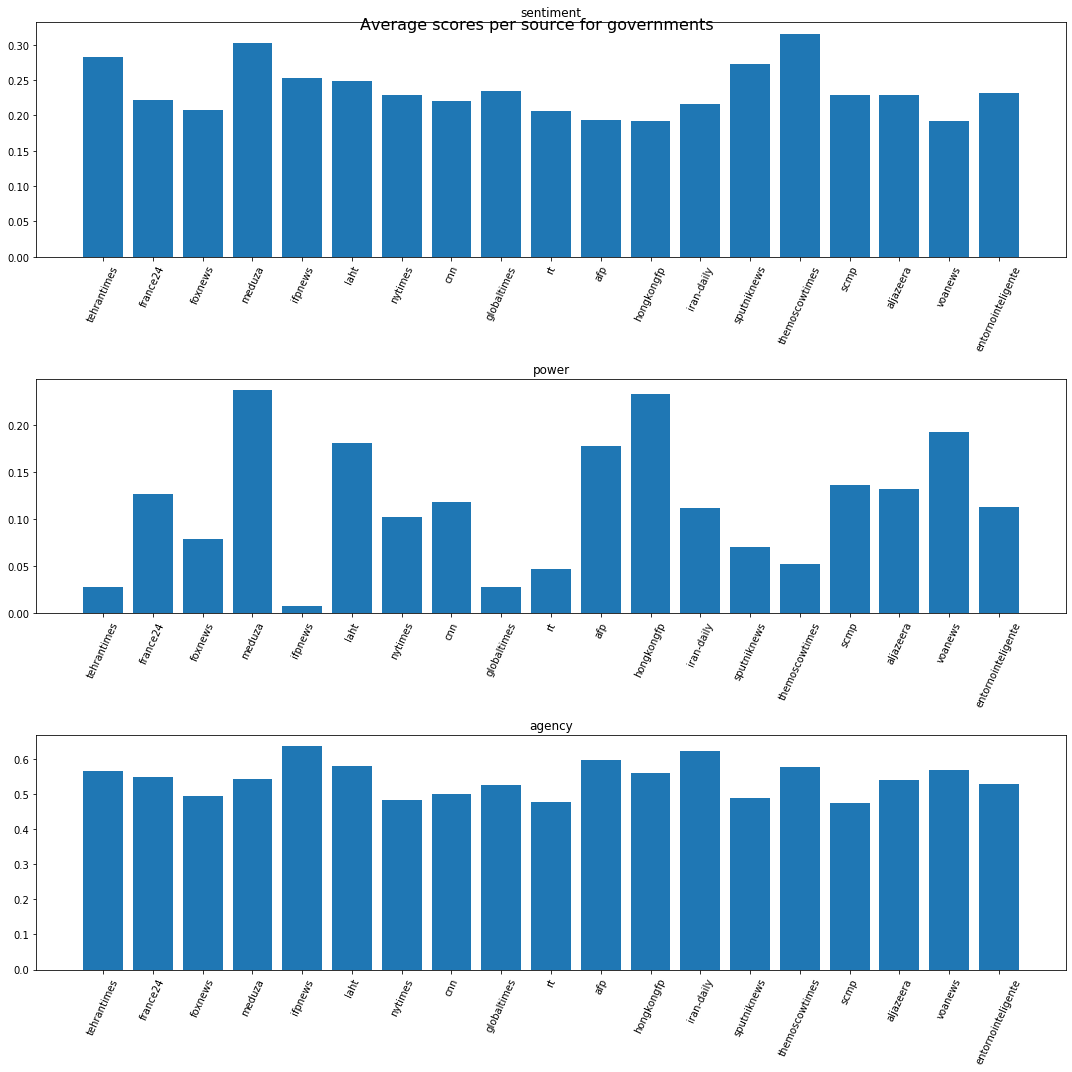

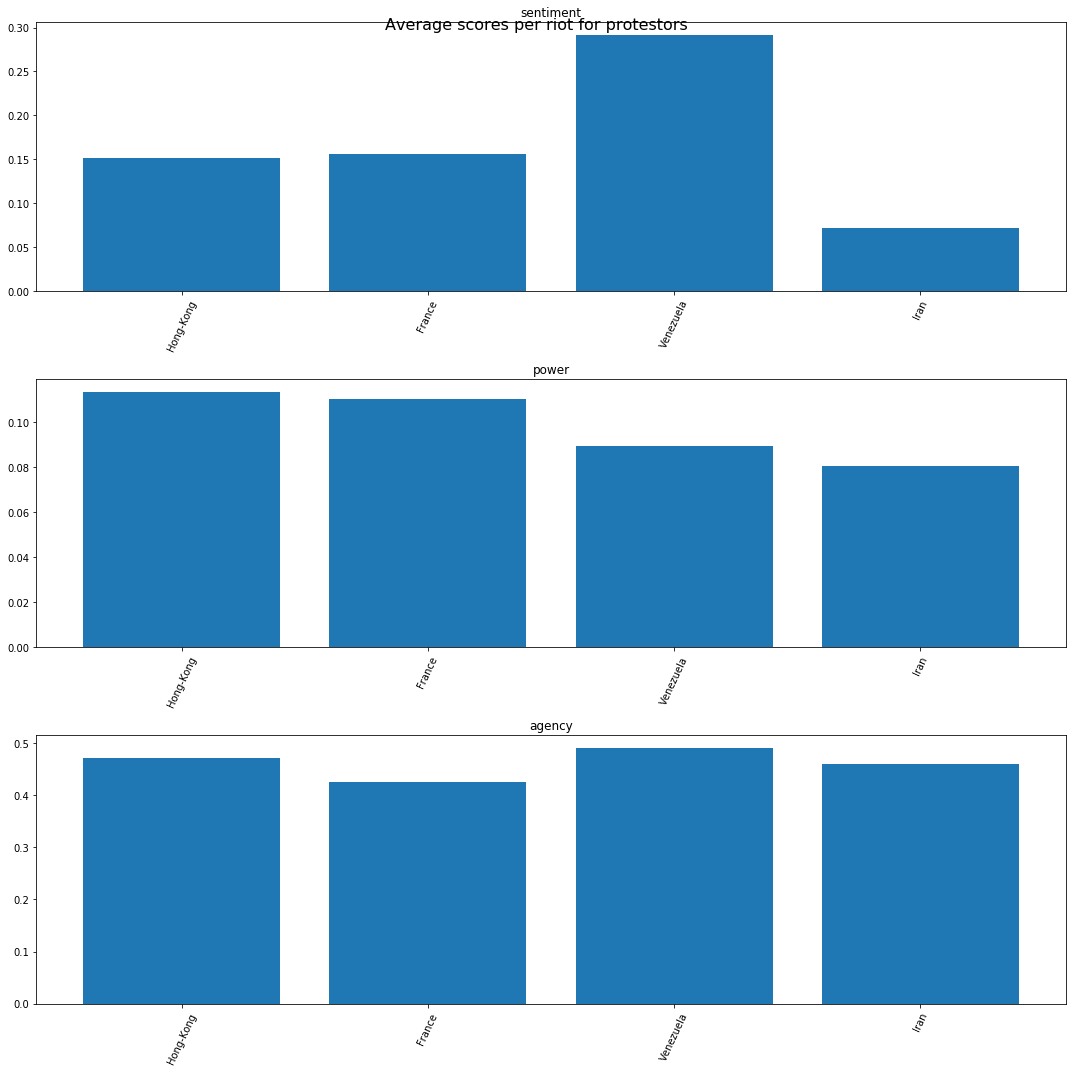

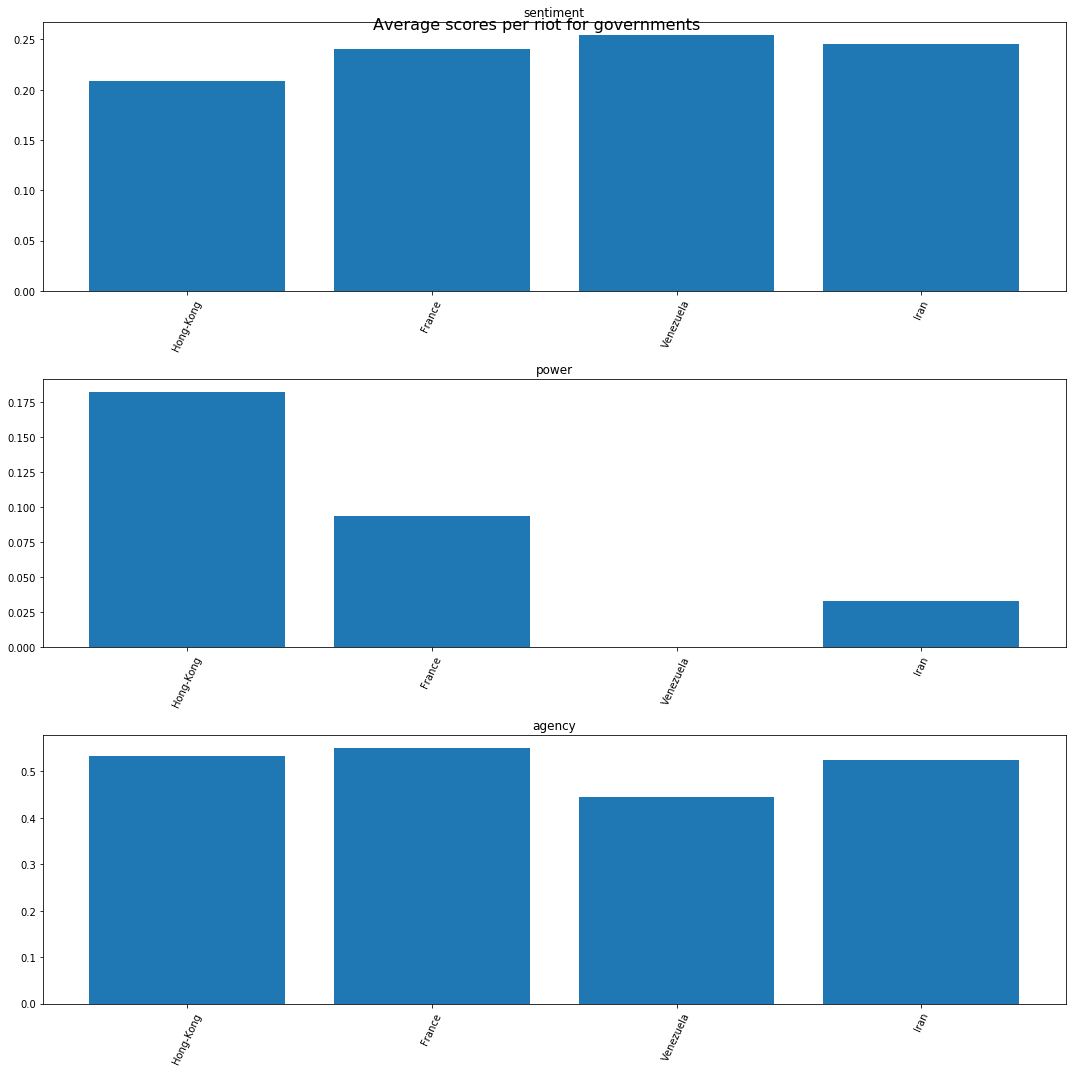

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt


def plotScores(dict_to_plot, keys_to_plot, title, normalize = True):
    fig, ax = plt.subplots(nrows=len(keys_to_plot), ncols=1,figsize=(15,15))
    fig.suptitle(title, fontsize=16)
    #ax.title("Overall sentiment per source")
    labels, values = list(zip(*dict_to_plot.items()))
    idx = list(range(len(labels)))
    for row, analysis_type in zip(ax,keys_to_plot):
        row.title.set_text(analysis_type)
        if normalize:
            row.bar(idx, [value[analysis_type]/value['count'] for value in values])
        else:
            row.bar(idx, [value[analysis_type] for value in values])
        row.set_xticks(idx)
        row.set_xticklabels(labels, rotation=65)

    fig.tight_layout()
    fig.savefig(title.replace(' ','_') + '.png')
    plt.show()

plotScores(protestor_source_scores , KEYS[:3],"Average scores per source for protestors")
plotScores(gov_source_scores , KEYS[:3],"Average scores per source for governments")
plotScores(protestor_riot_scores , KEYS[:3],"Average scores per riot for protestors")
plotScores(gov_riot_scores , KEYS[:3],"Average scores per riot for governments")

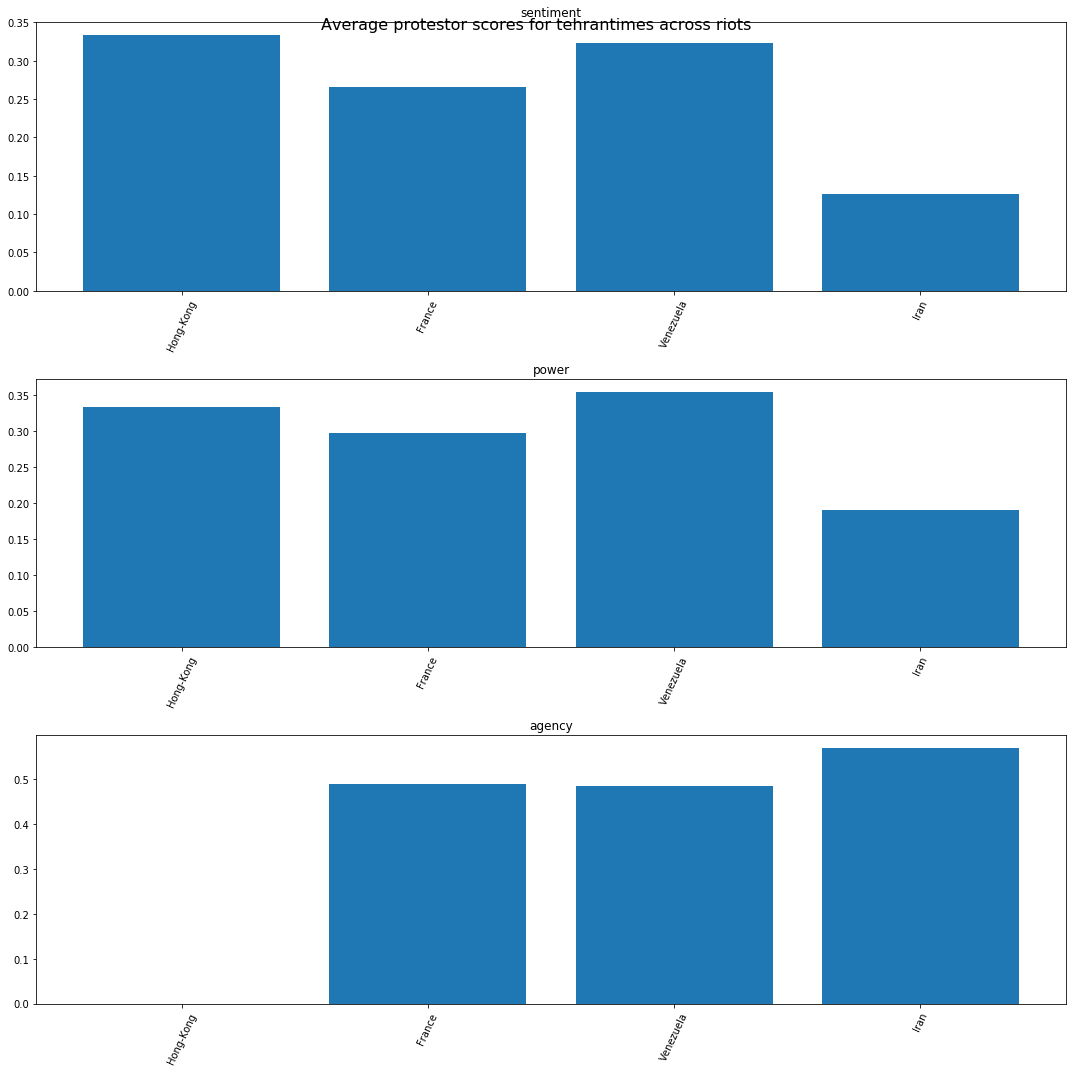

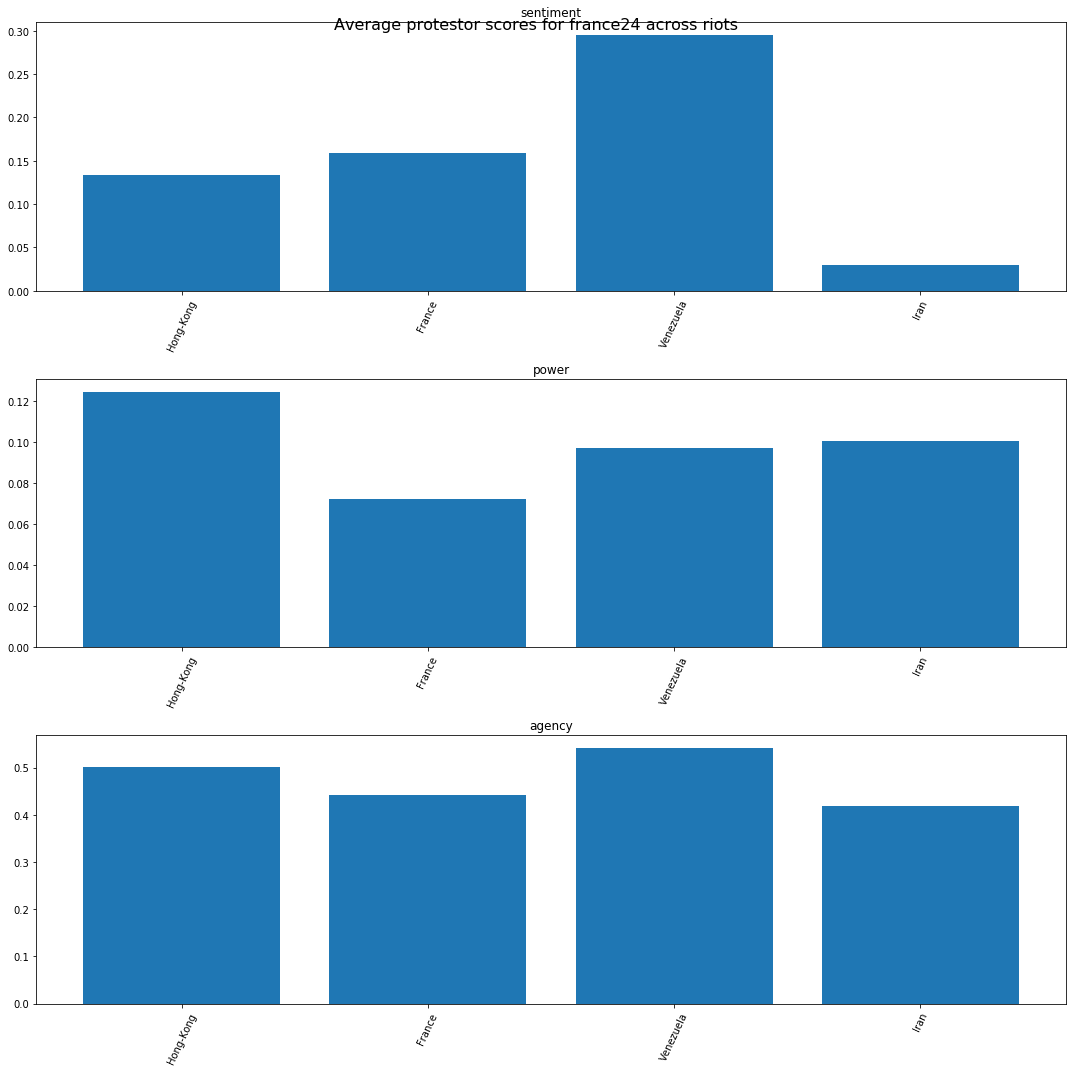

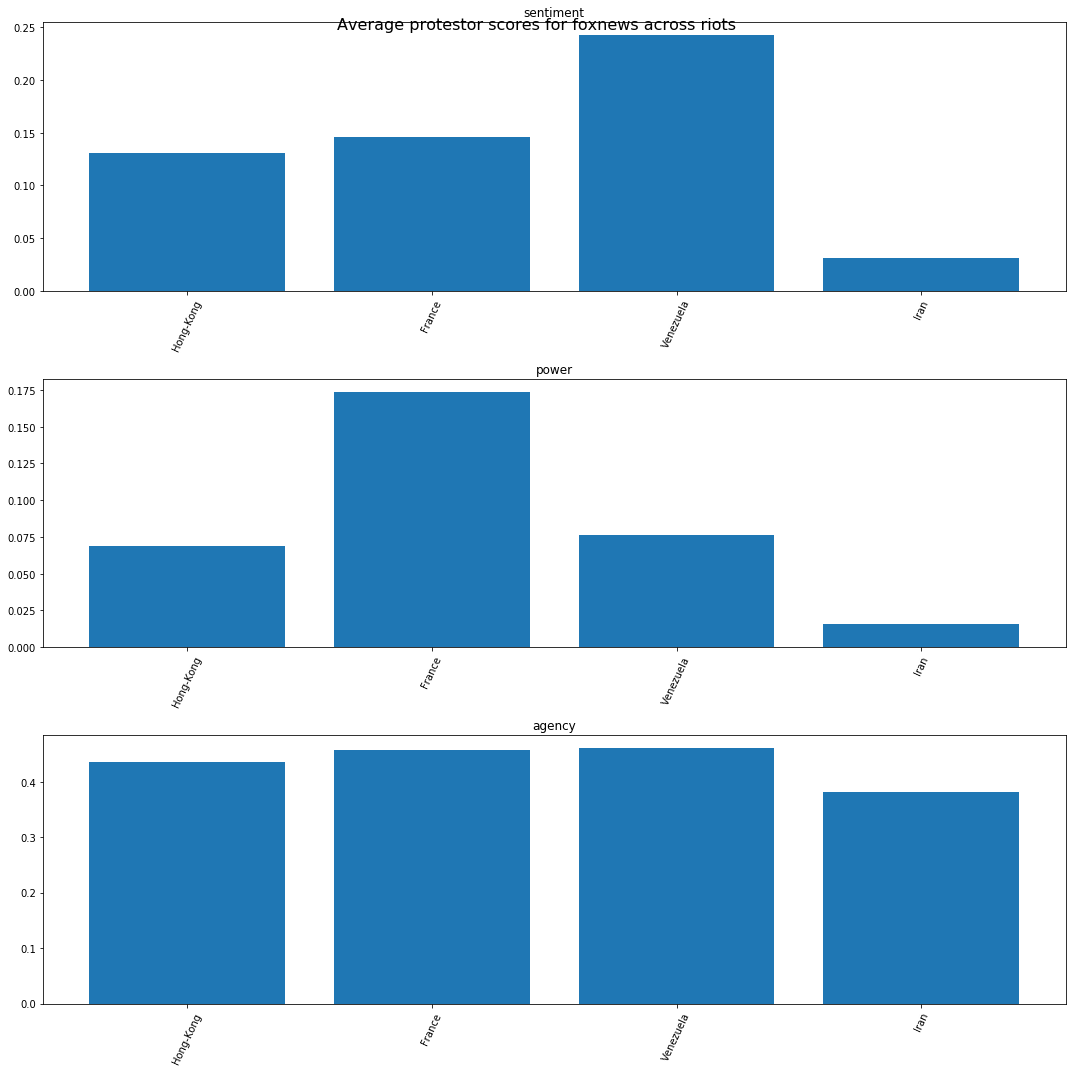

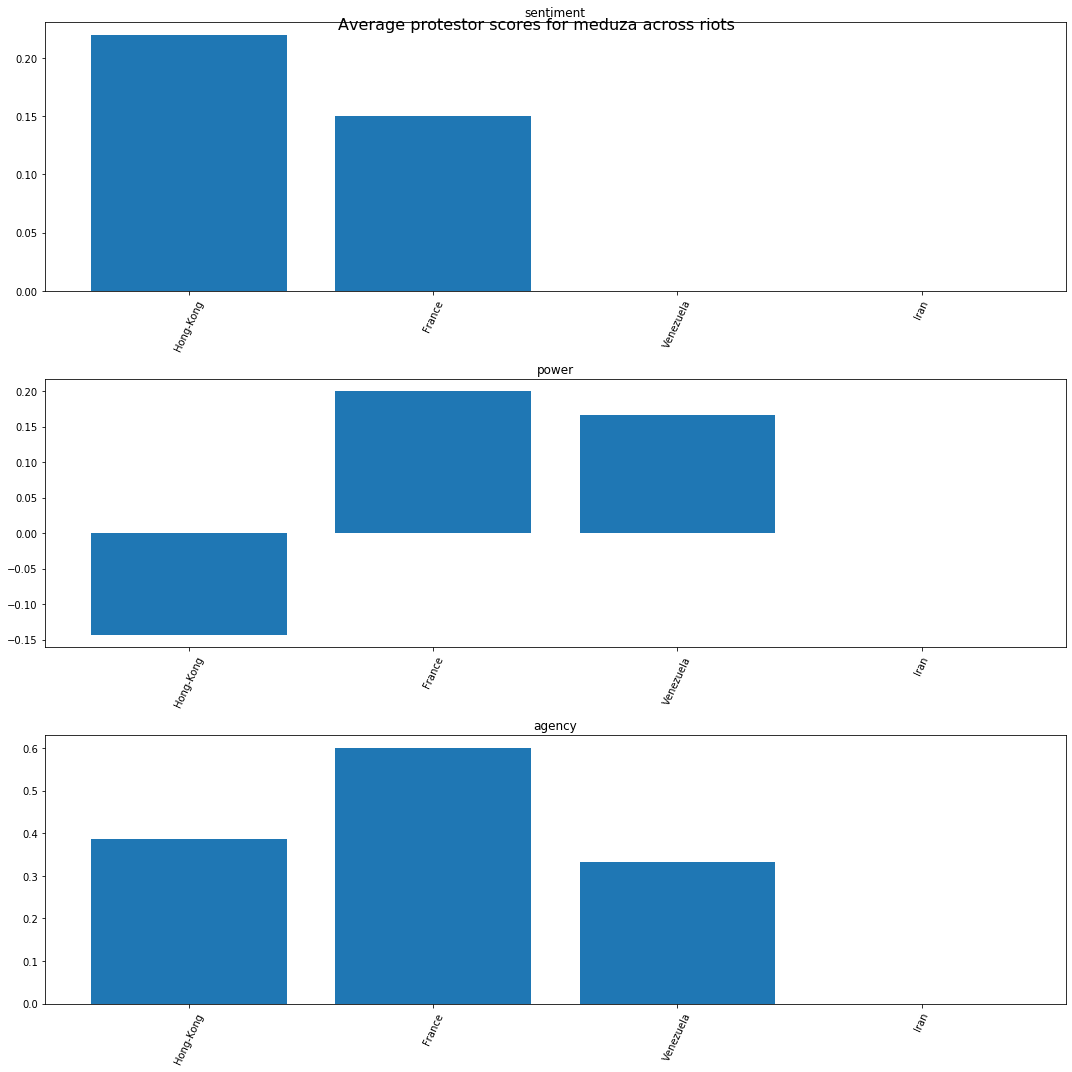

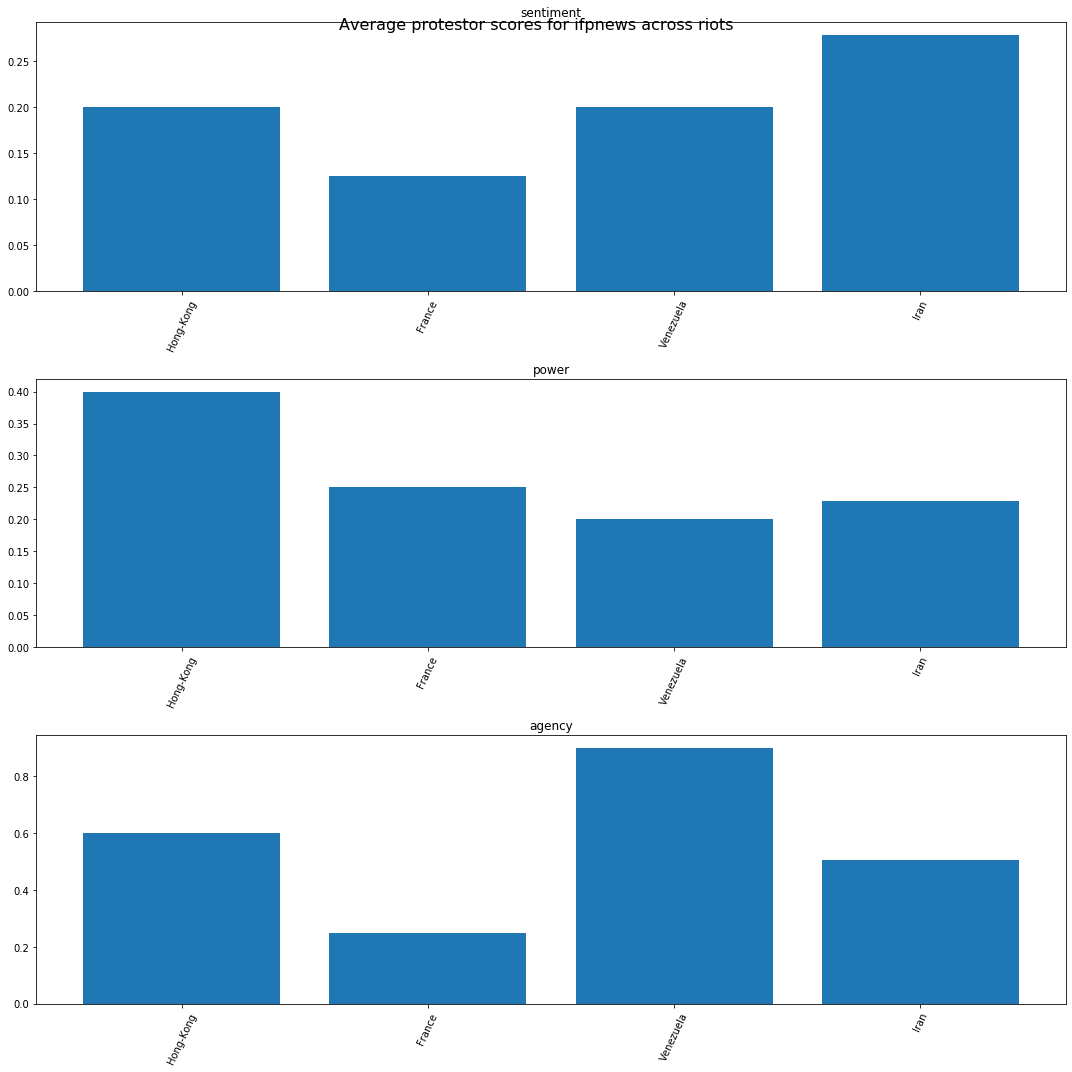

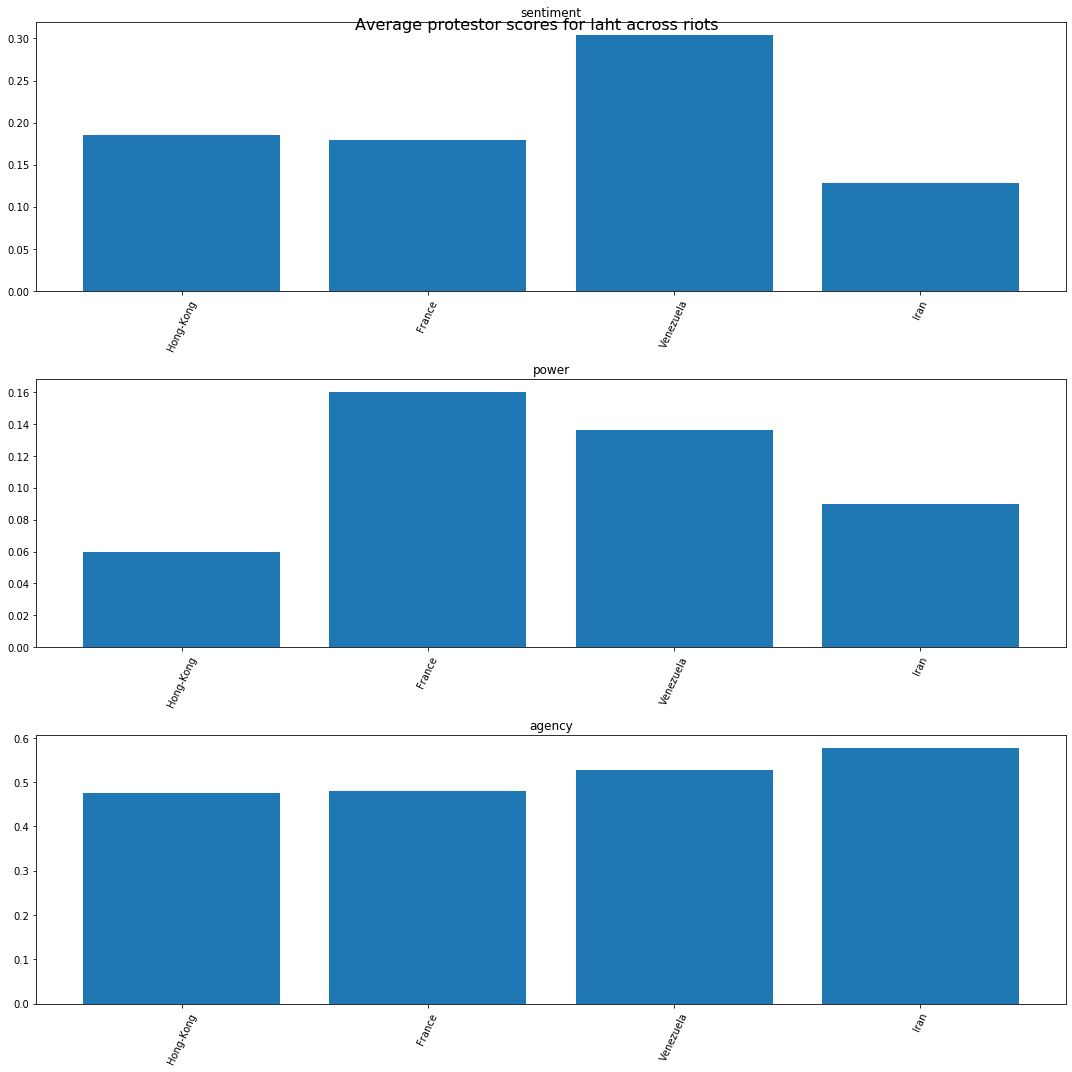

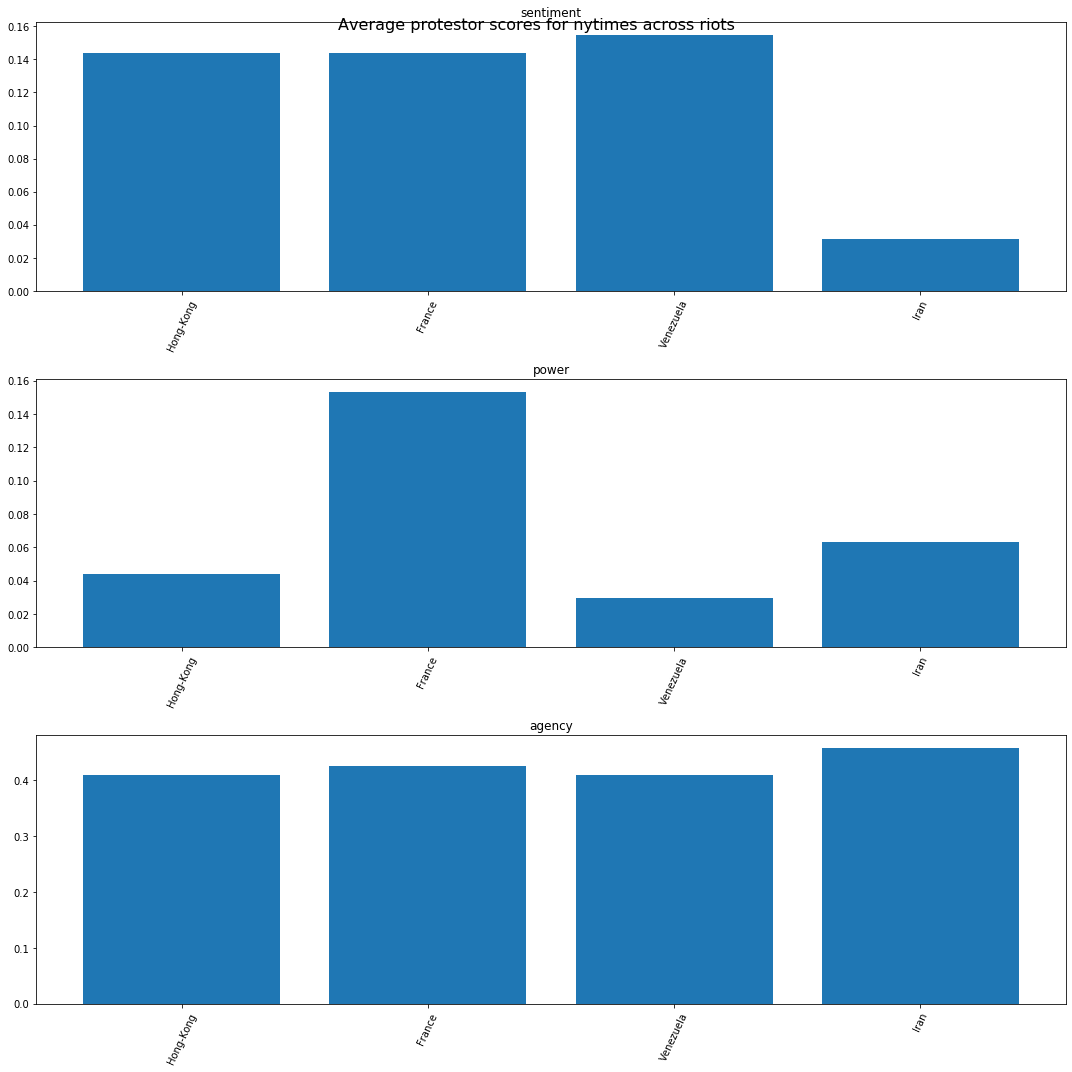

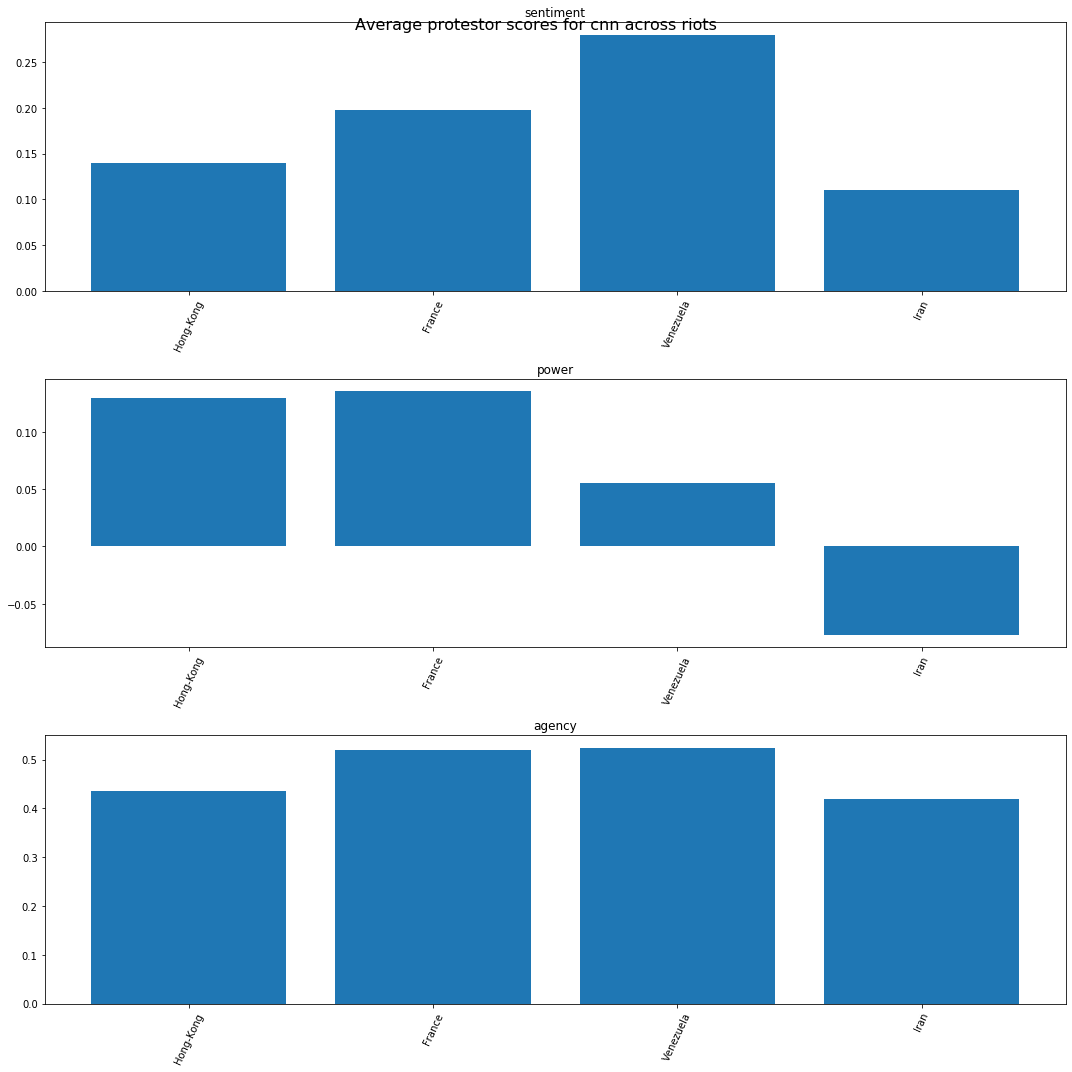

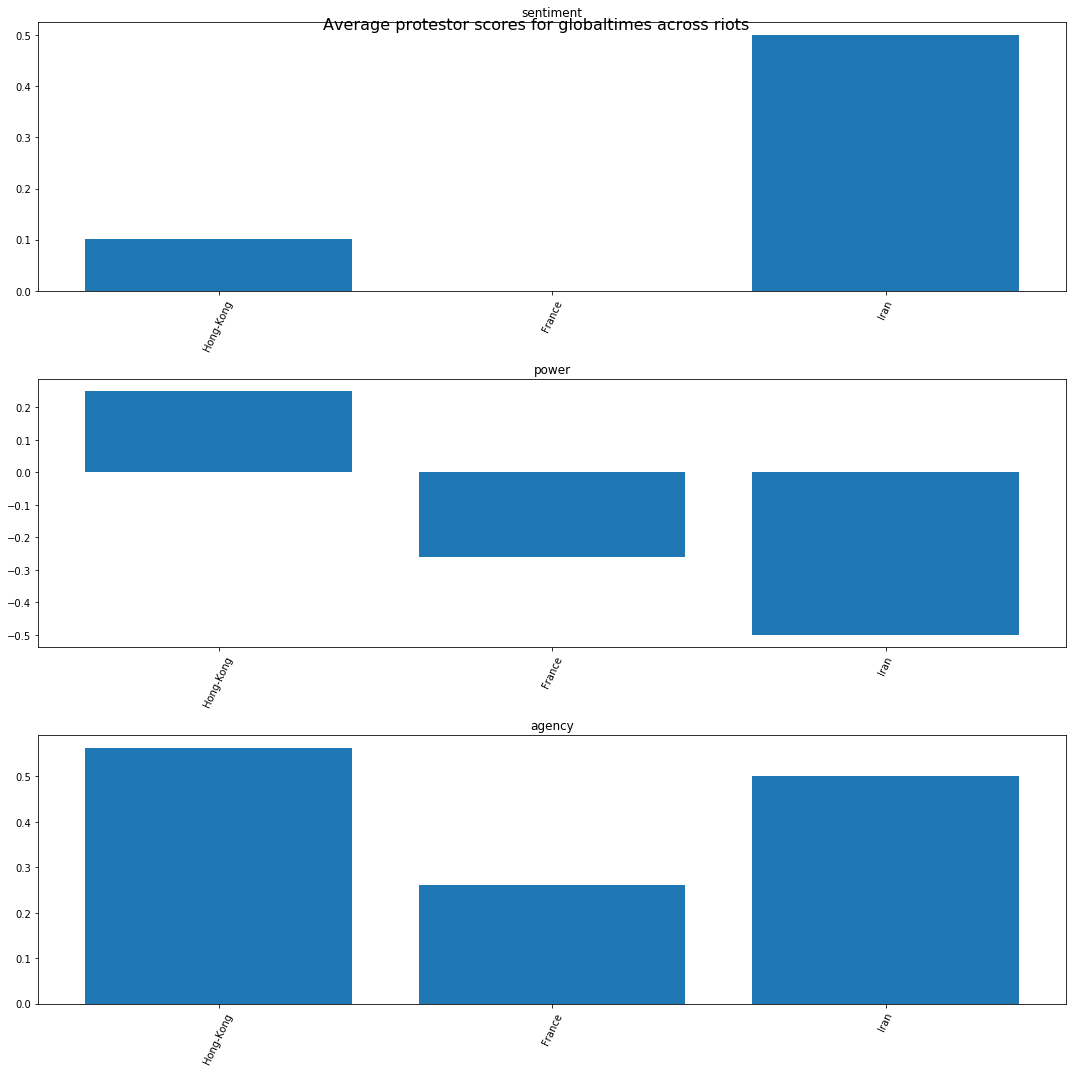

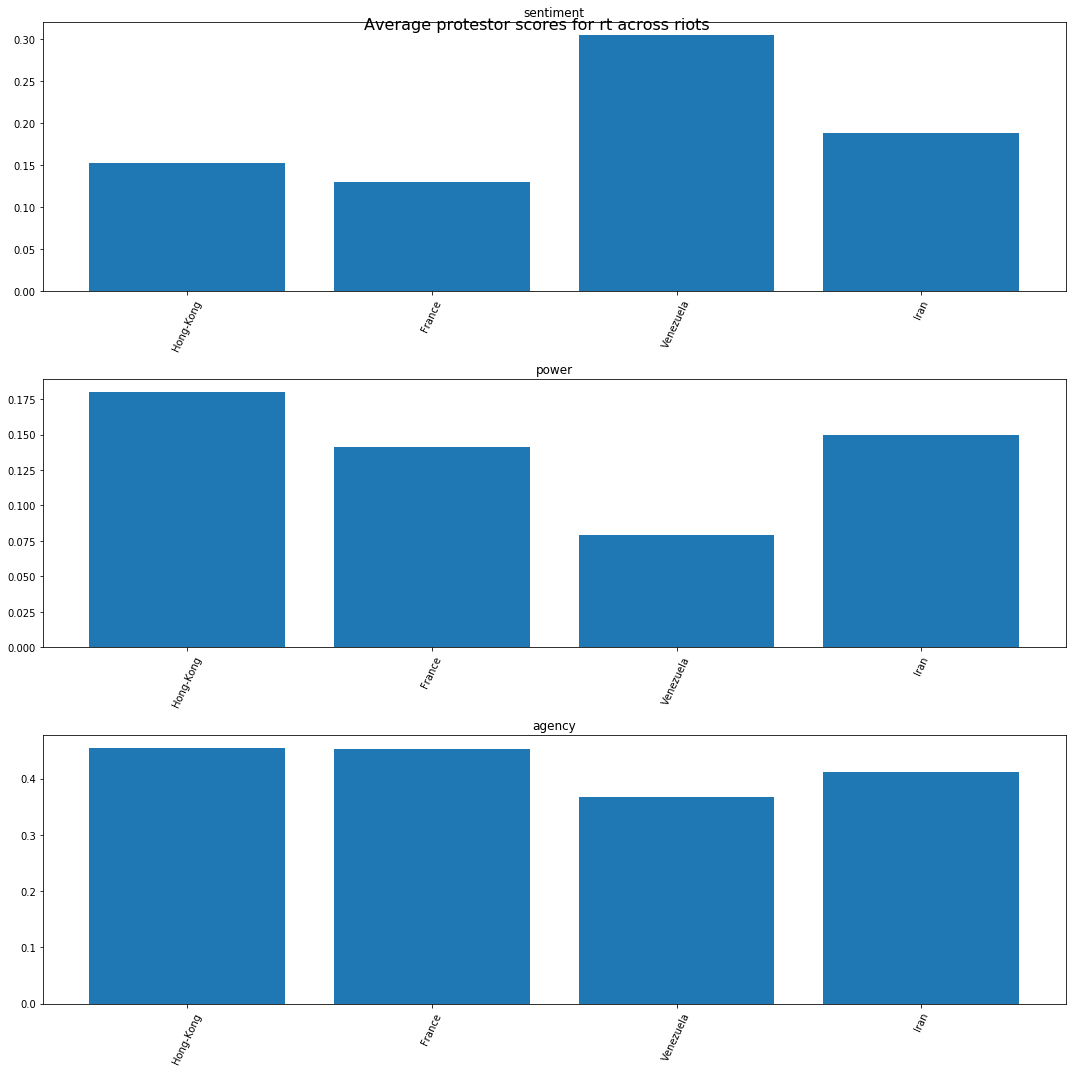

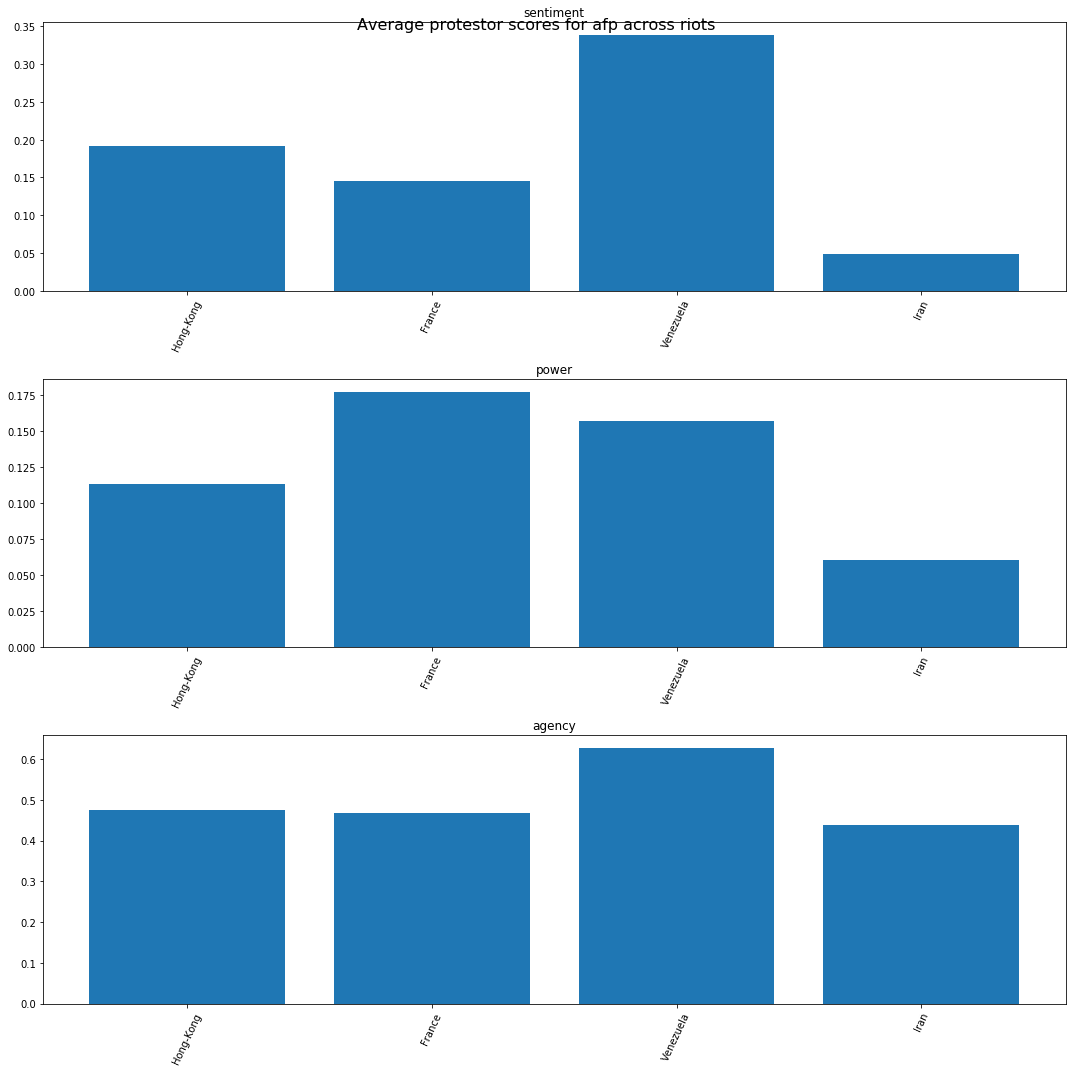

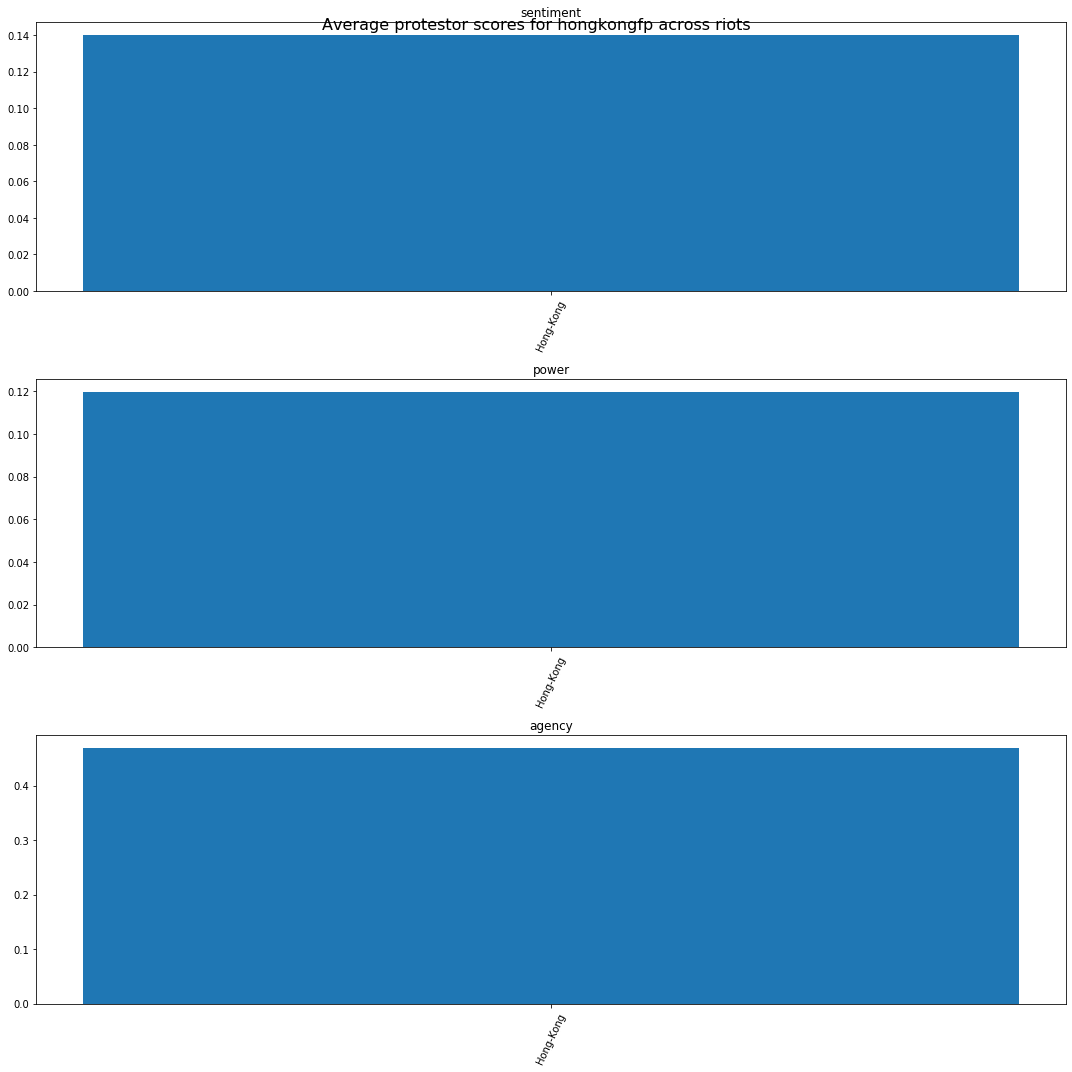

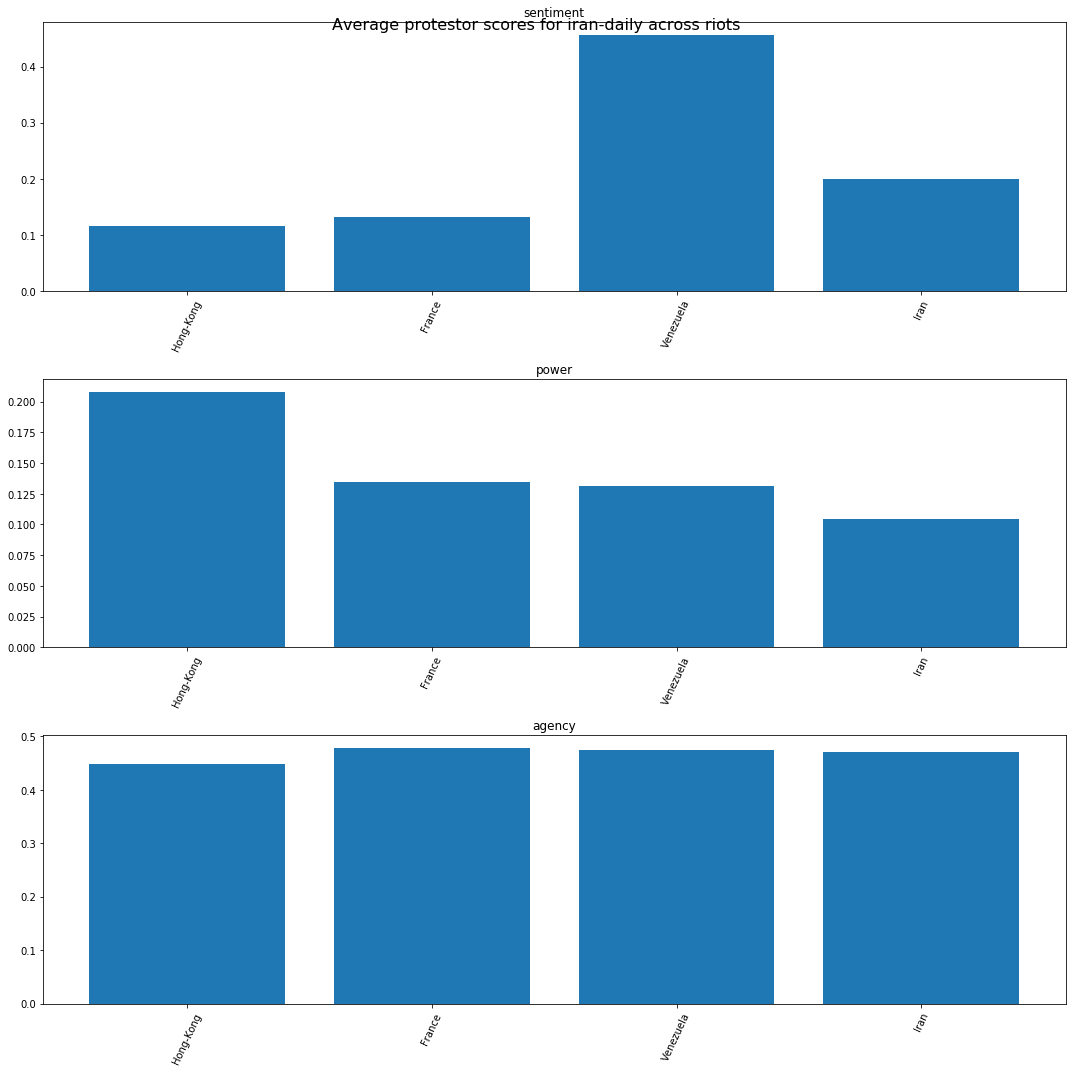

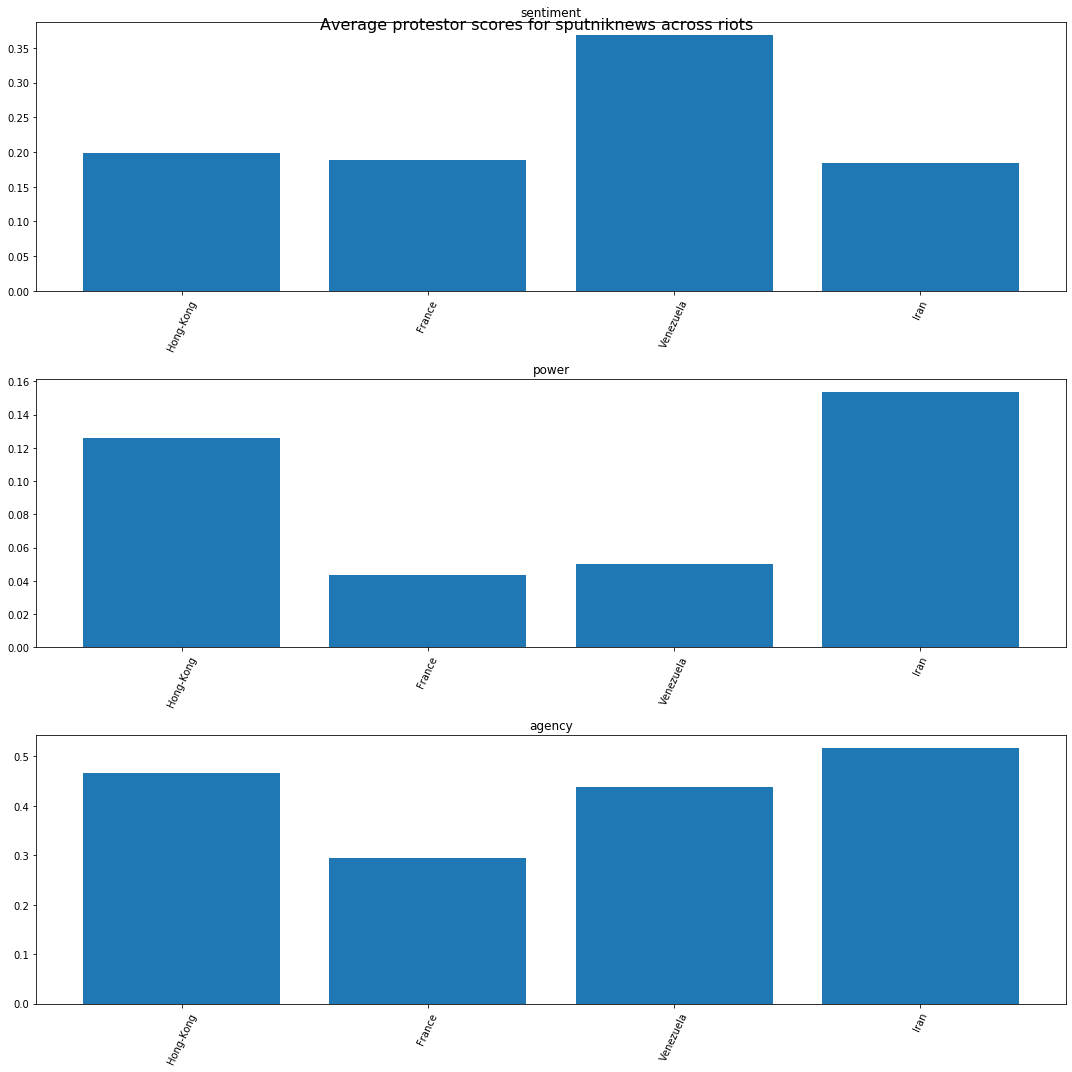

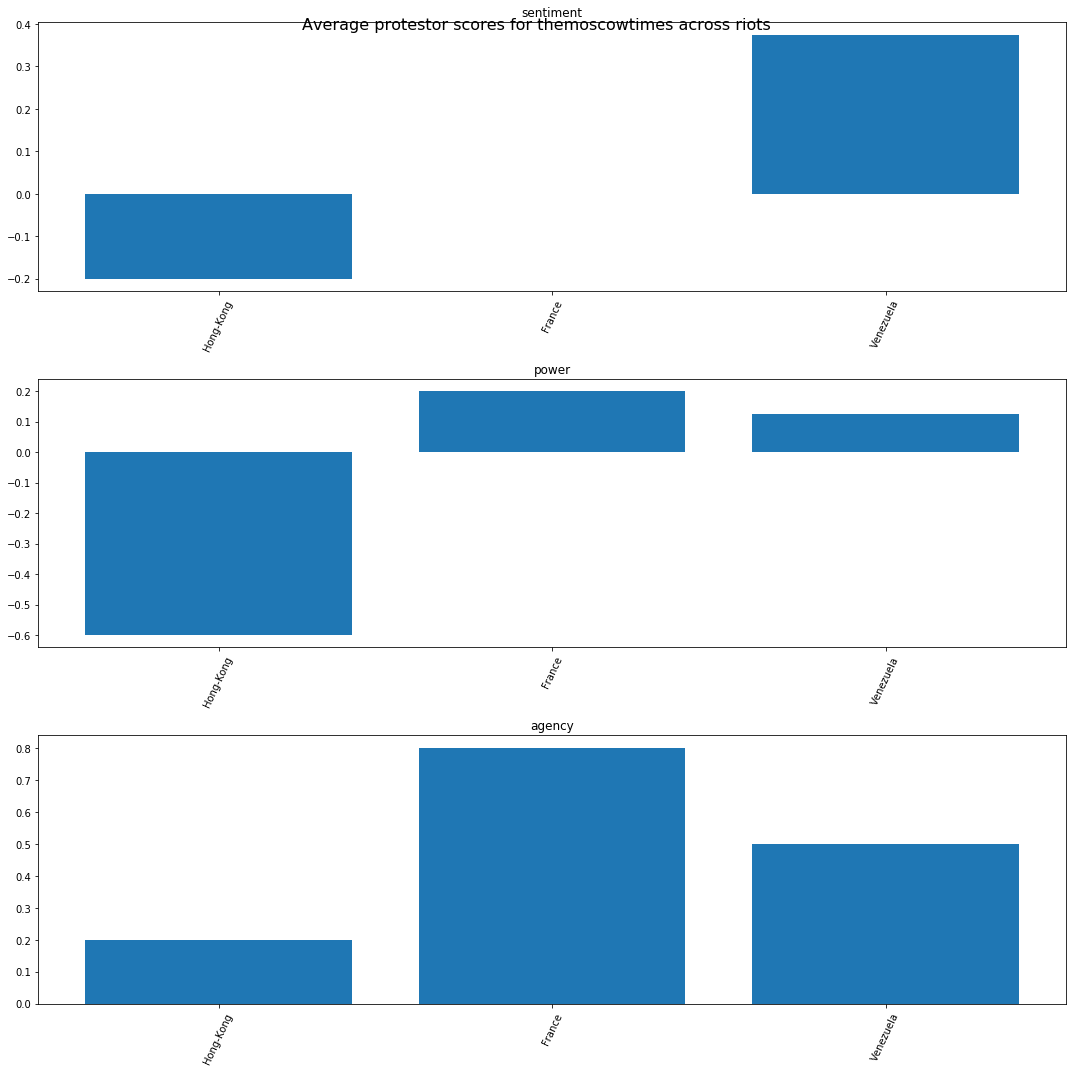

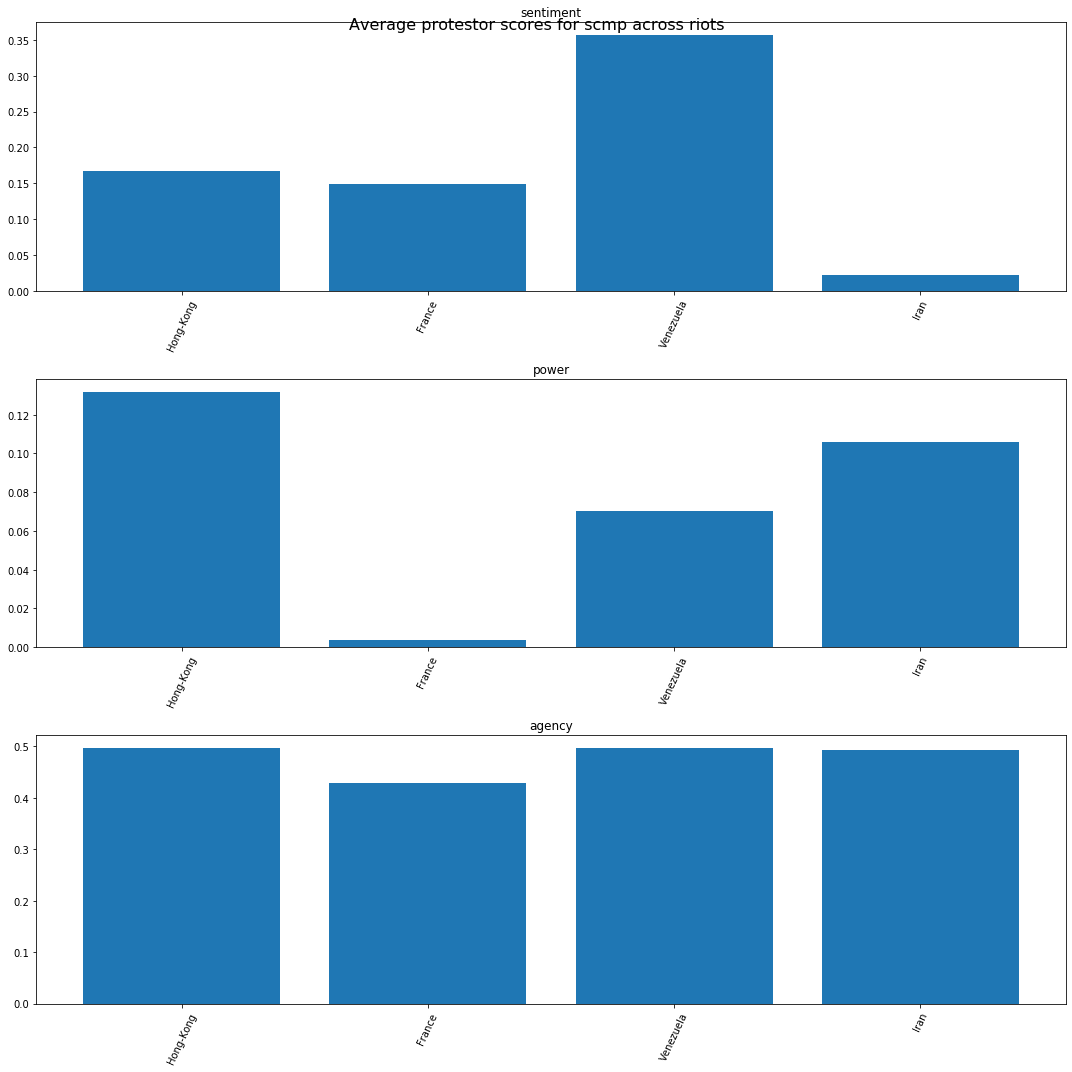

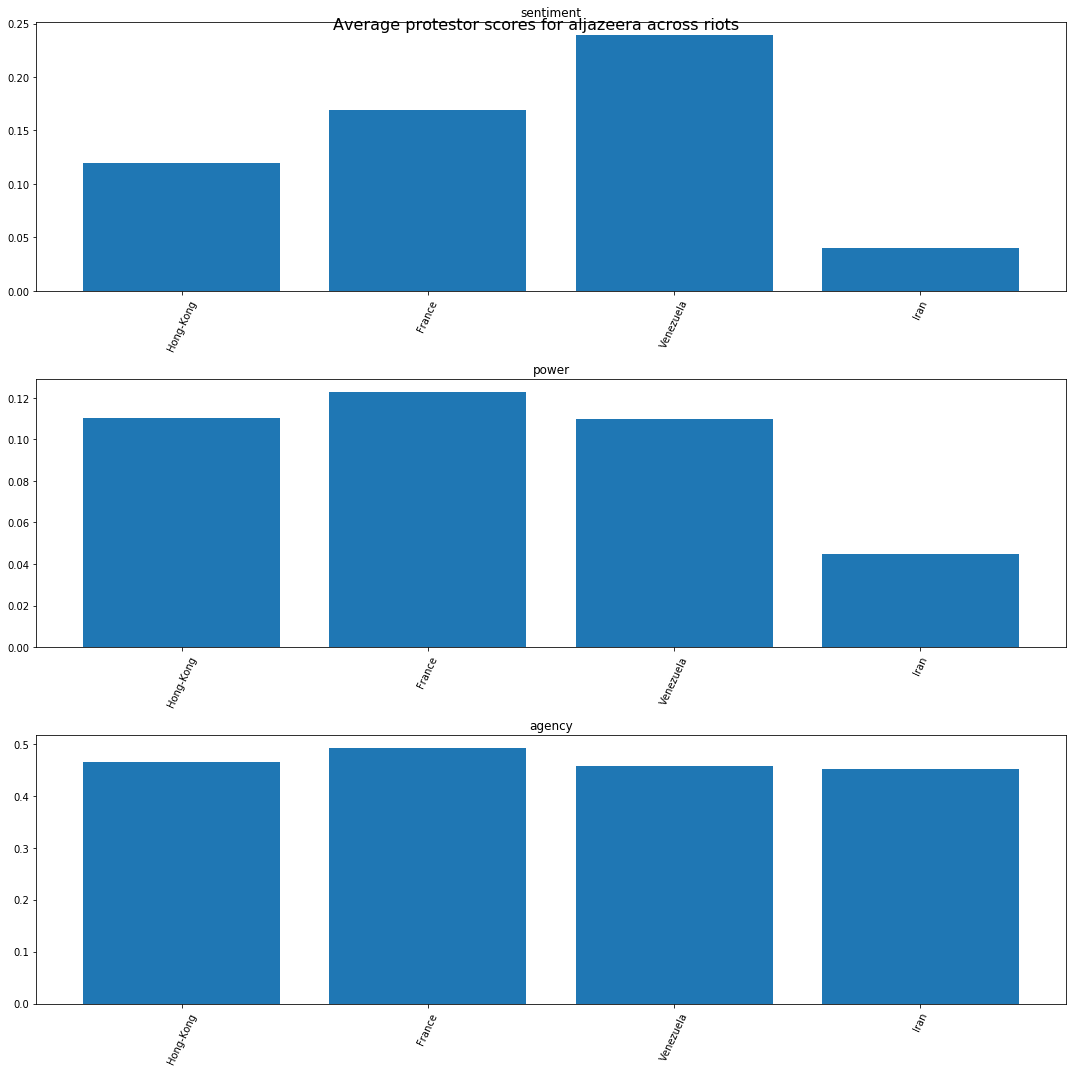

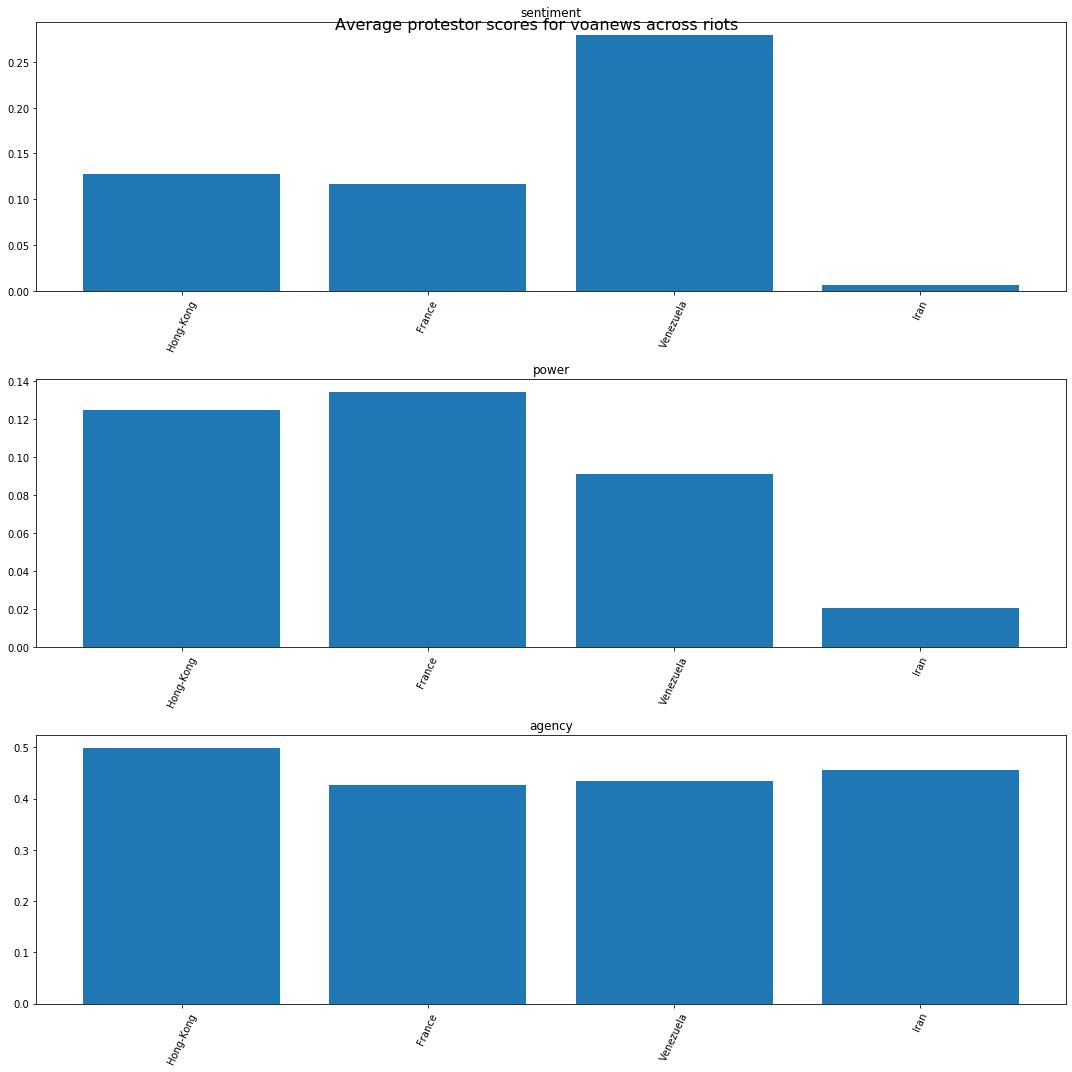

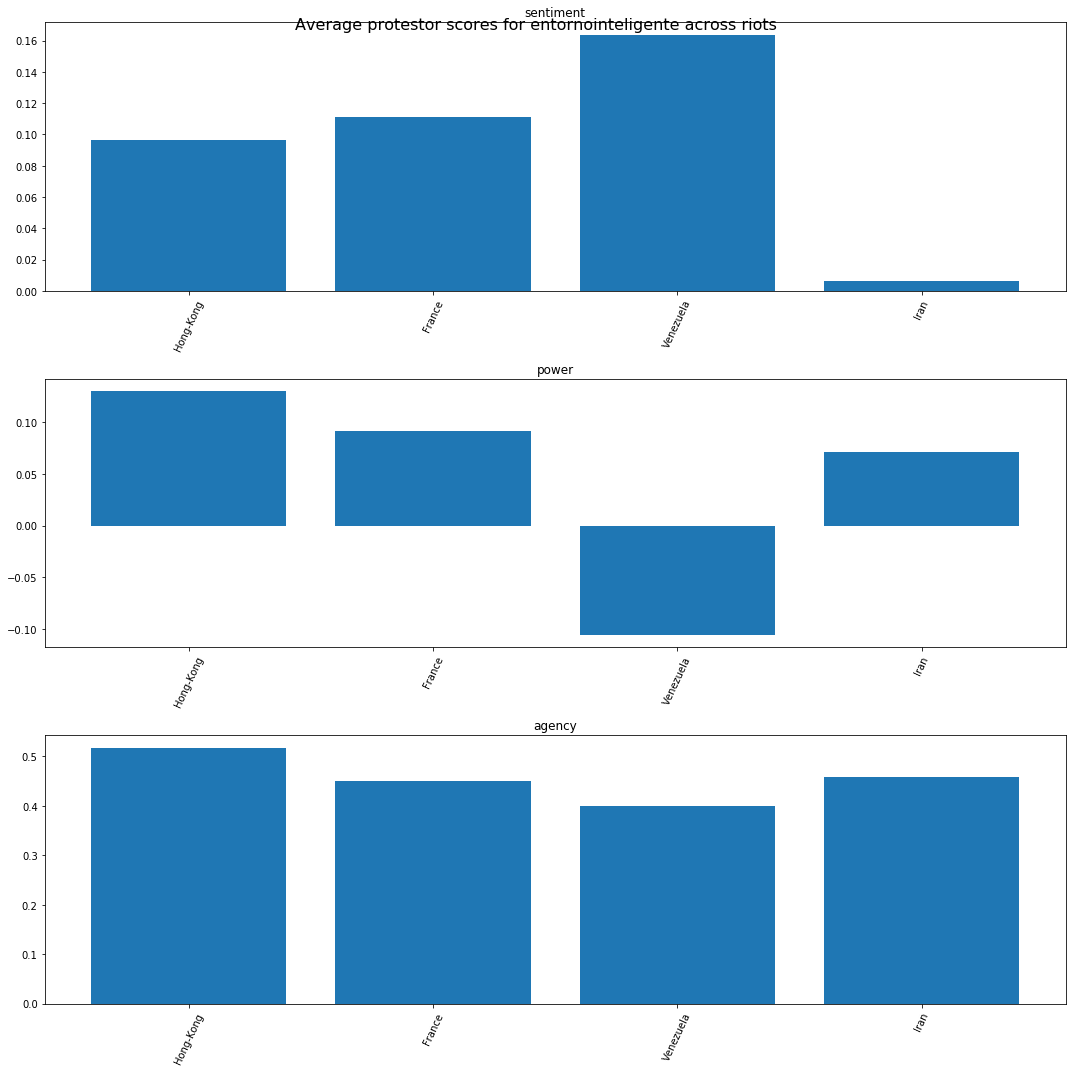

In [28]:
def flipRiotSource(curr_dict):
    curr_source_scores = defaultdict(lambda : defaultdict(list))
    for riot in curr_dict:
        for source in curr_dict[riot]:
            curr_source_scores[source][riot] = curr_dict[riot][source]
    return curr_source_scores

source_riot_protestor = flipRiotSource(protestor_entity_scores)

for source in source_riot_protestor:
    scores = {riot : sumScores(scores) for riot, scores in source_riot_protestor[source].items()}
    plotScores(scores , KEYS[:3],"Average protestor scores for {} across riots".format(source))

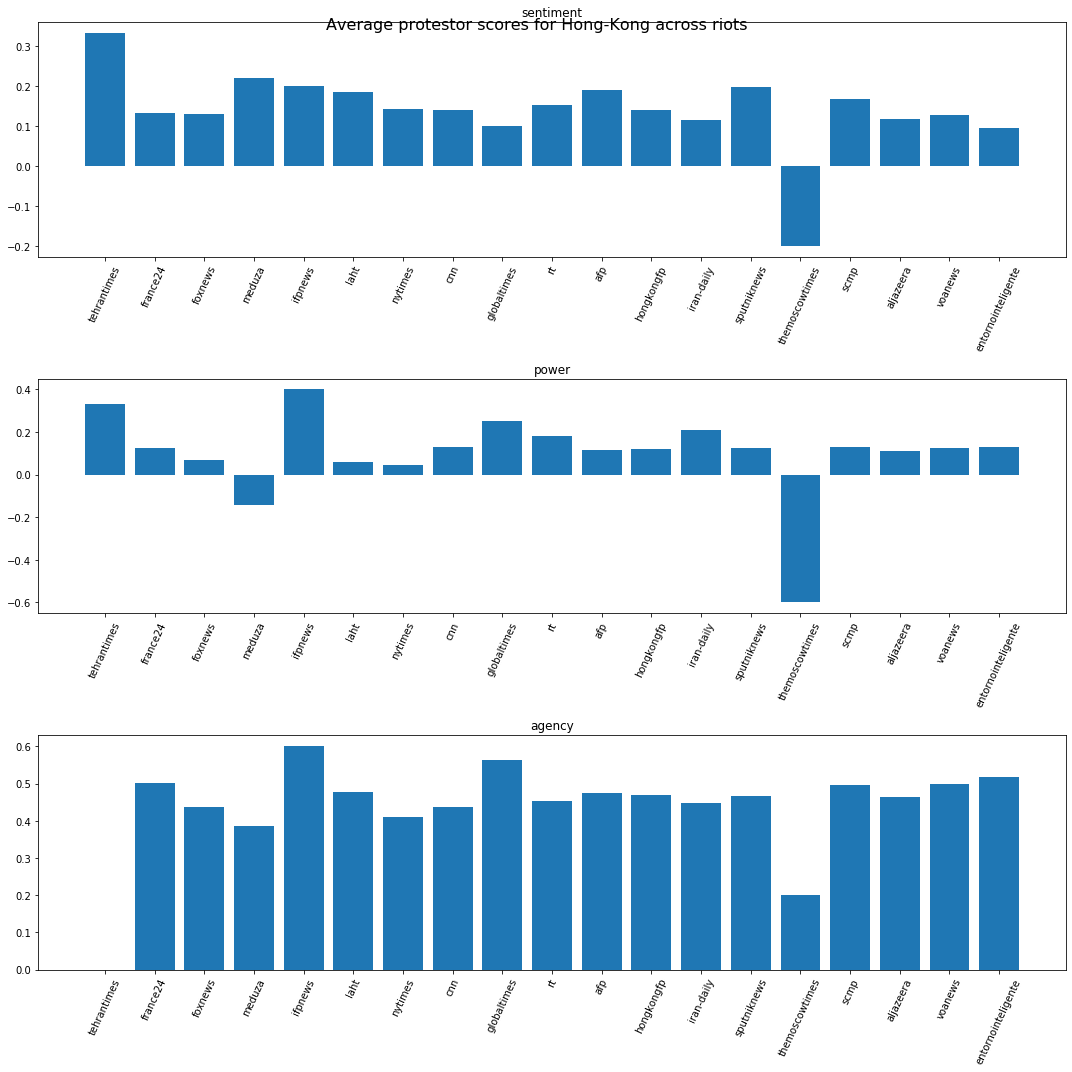

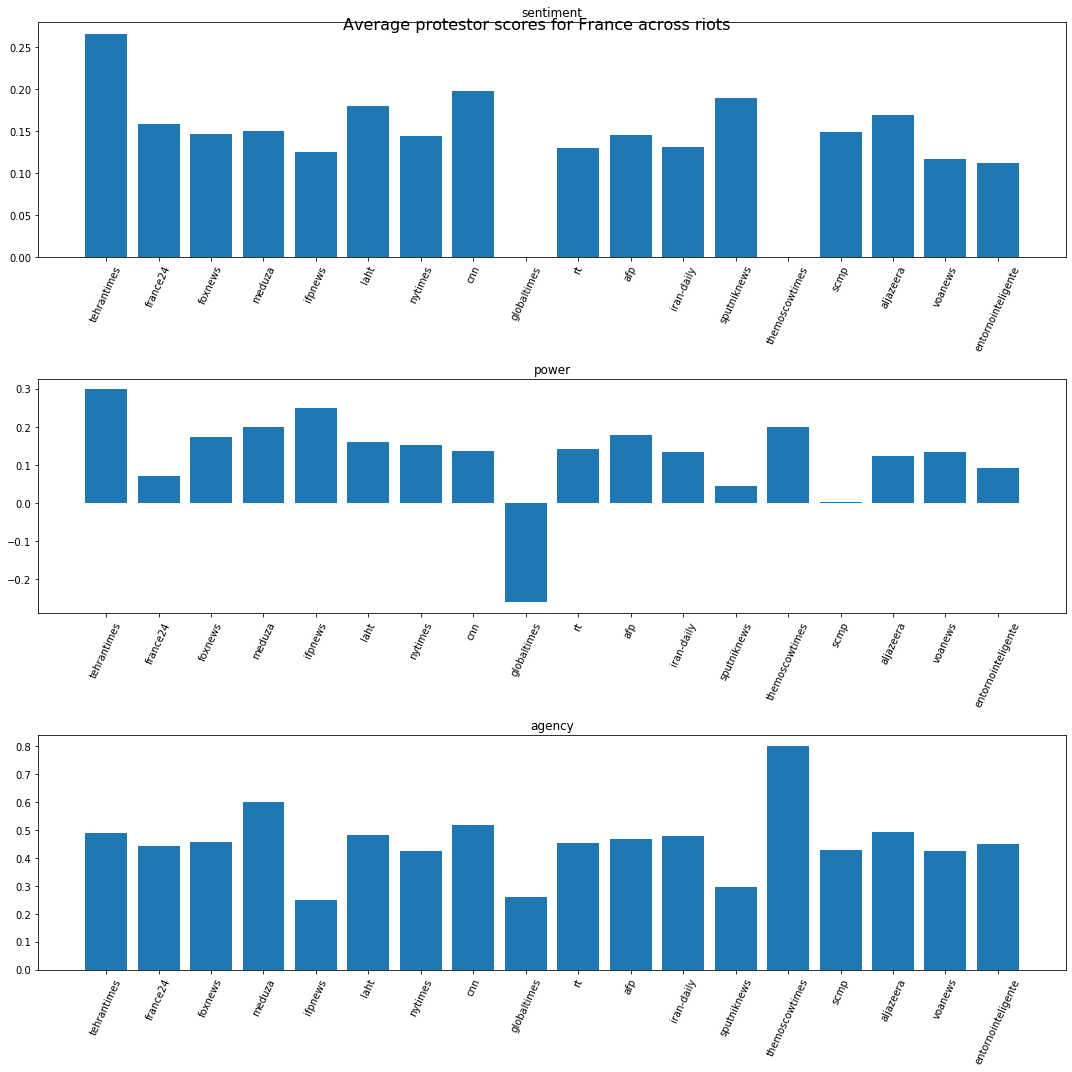

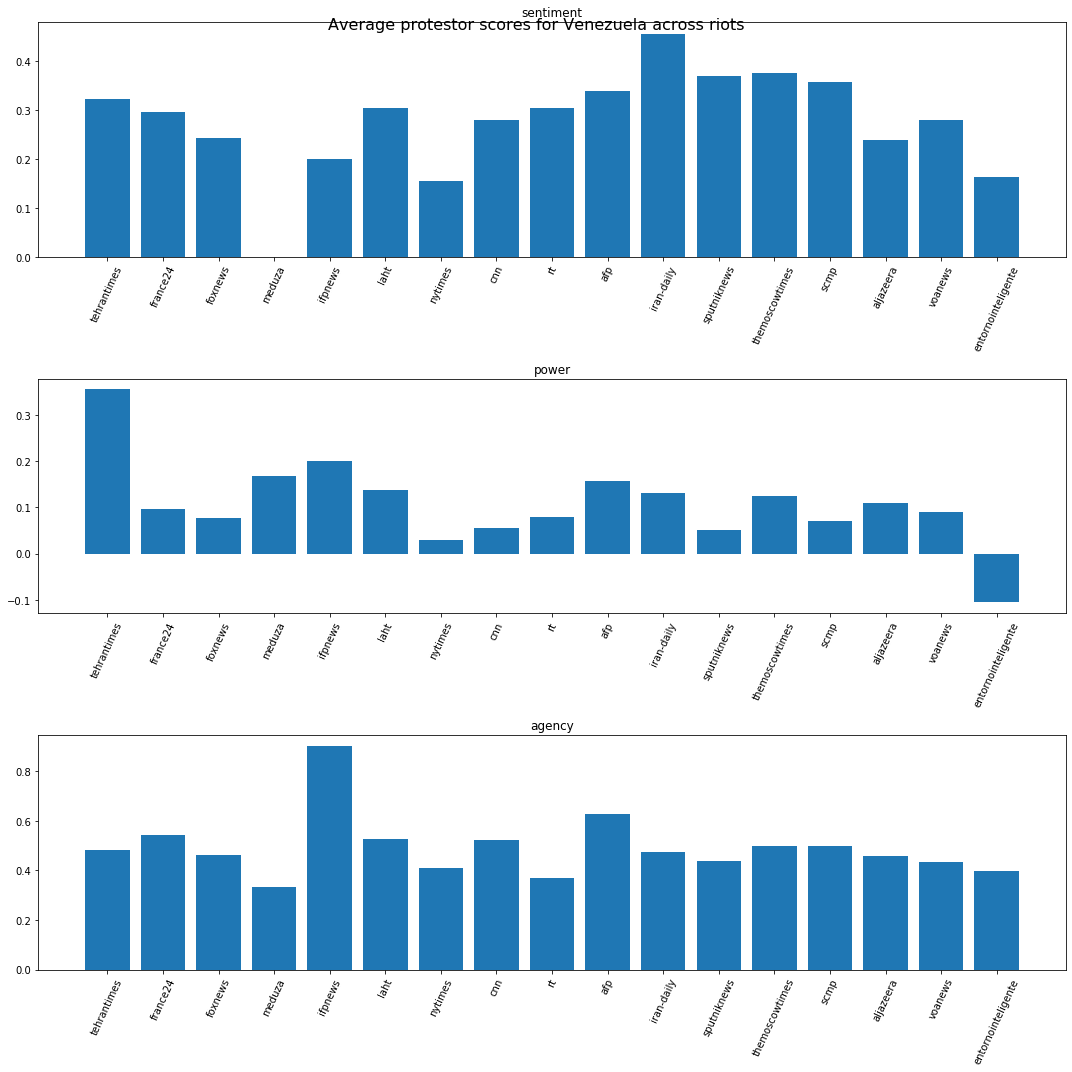

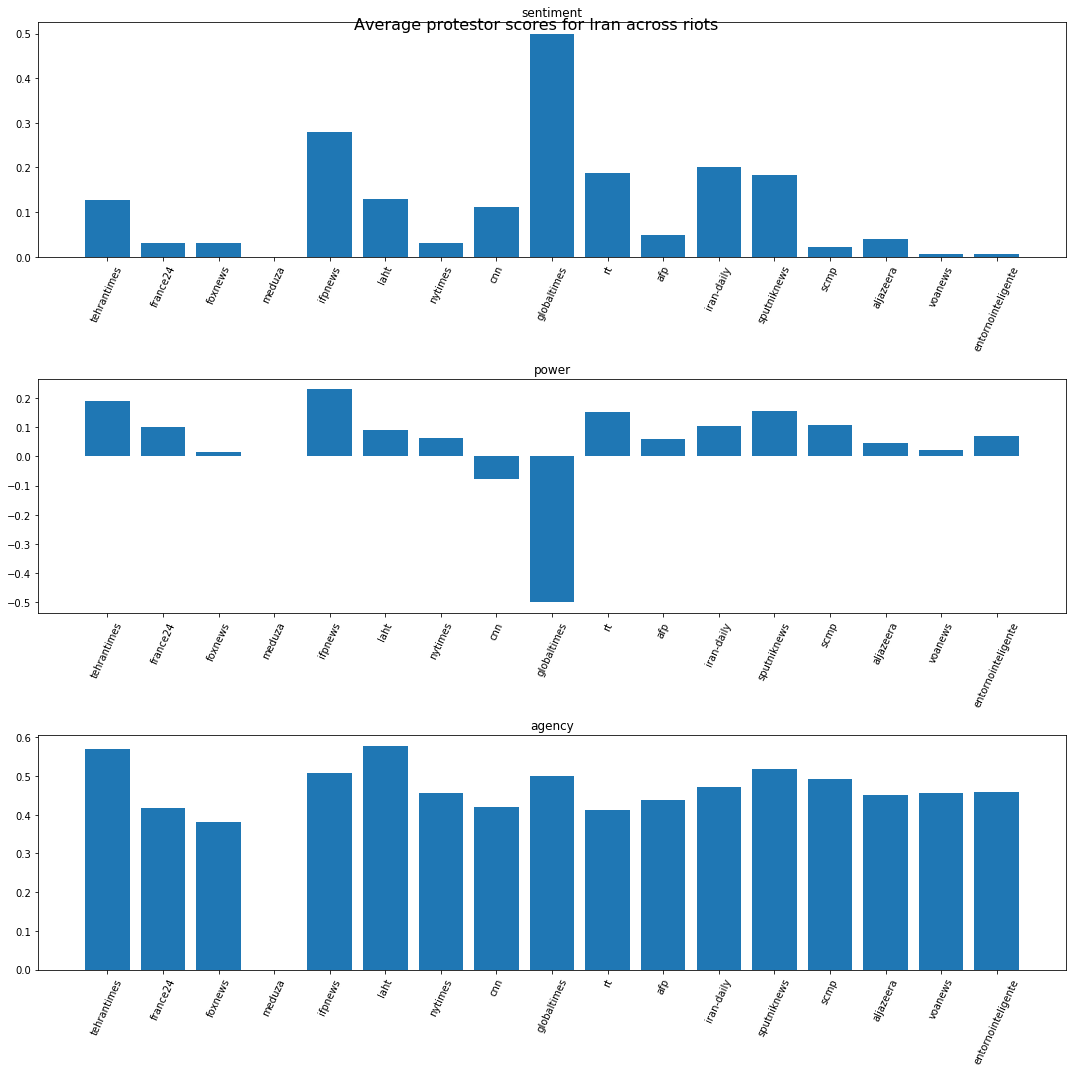

In [30]:
for source in protestor_entity_scores:
    scores = {riot : sumScores(scores) for riot, scores in protestor_entity_scores[source].items()}
    plotScores(scores , KEYS[:3],"Average protestor scores for {} across riots".format(source))

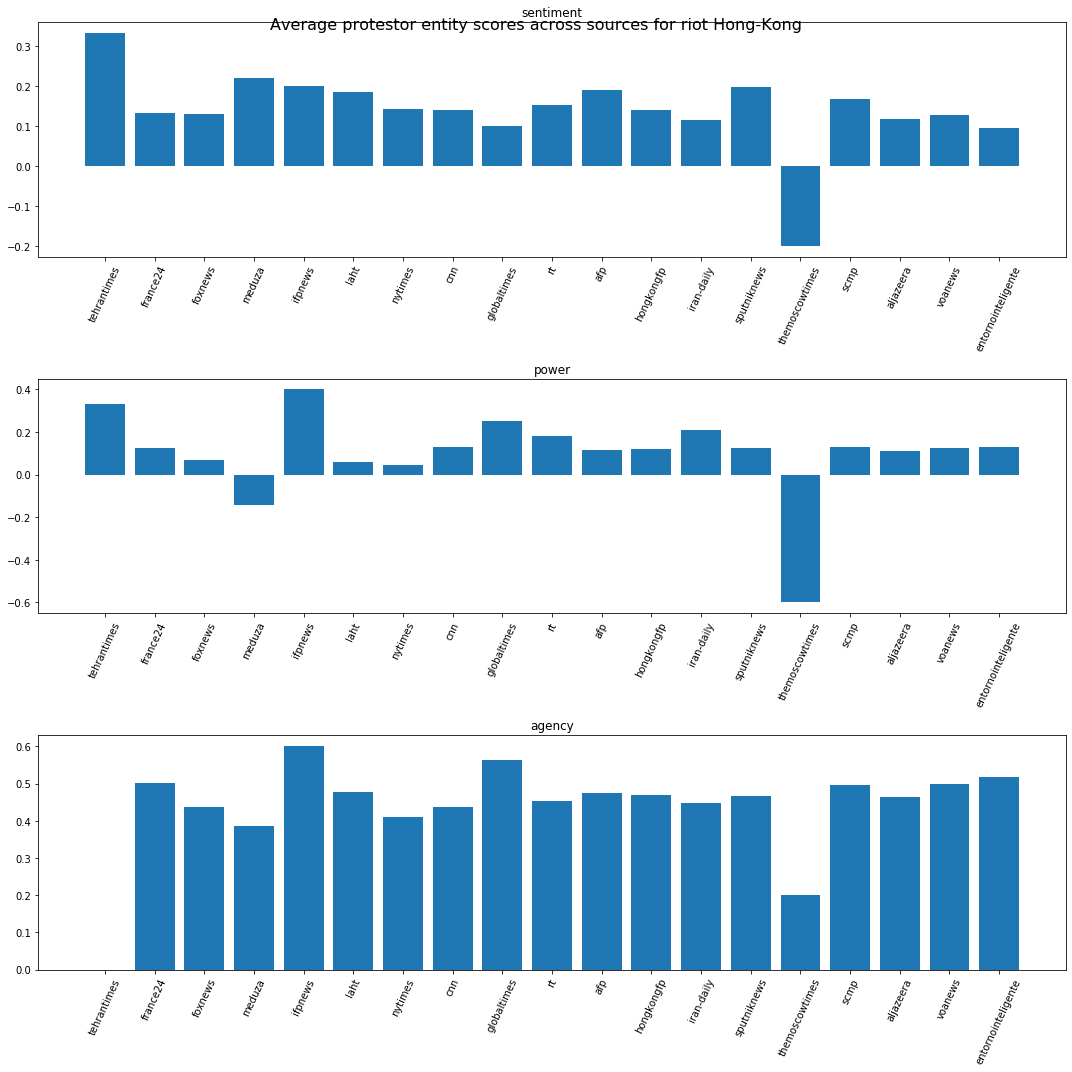

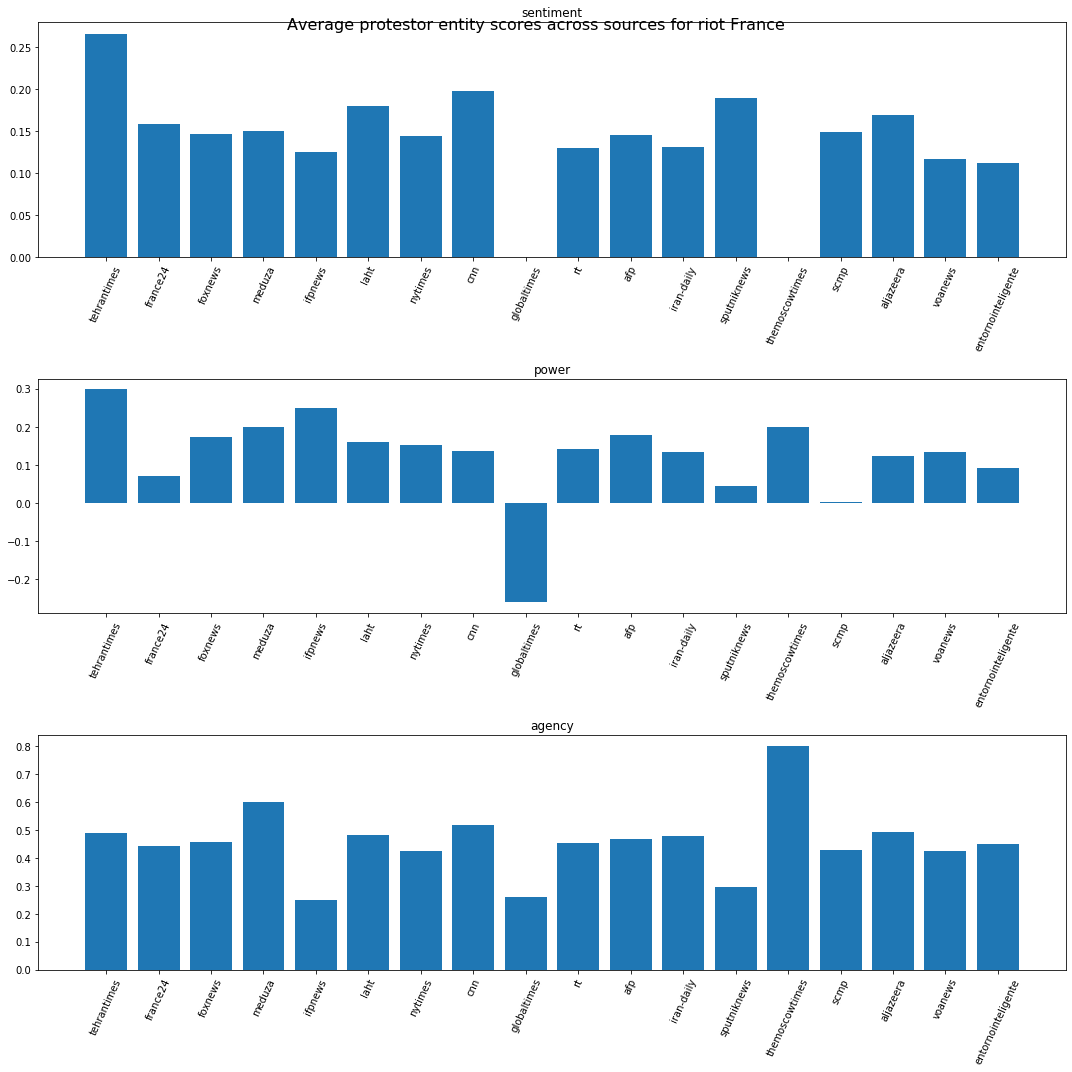

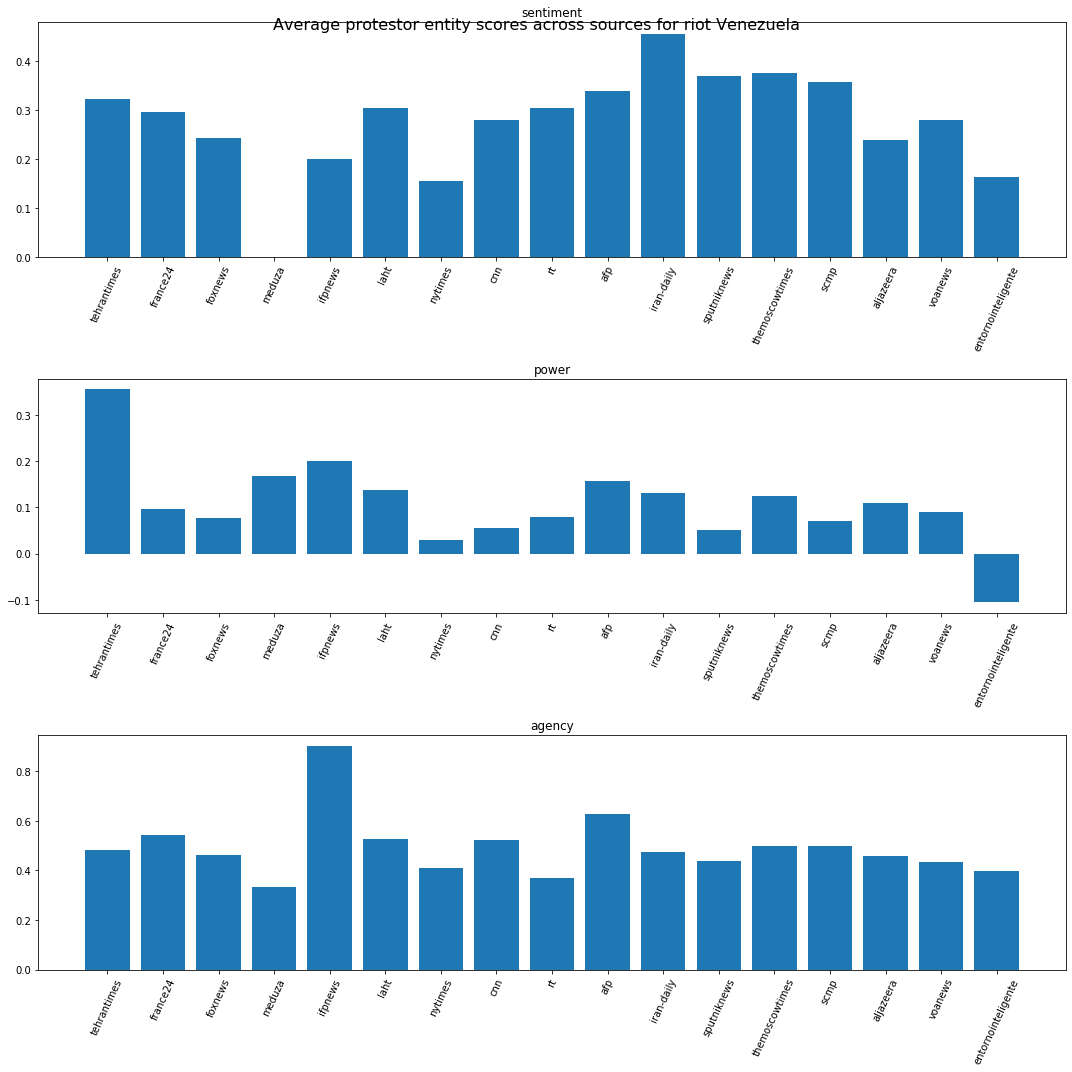

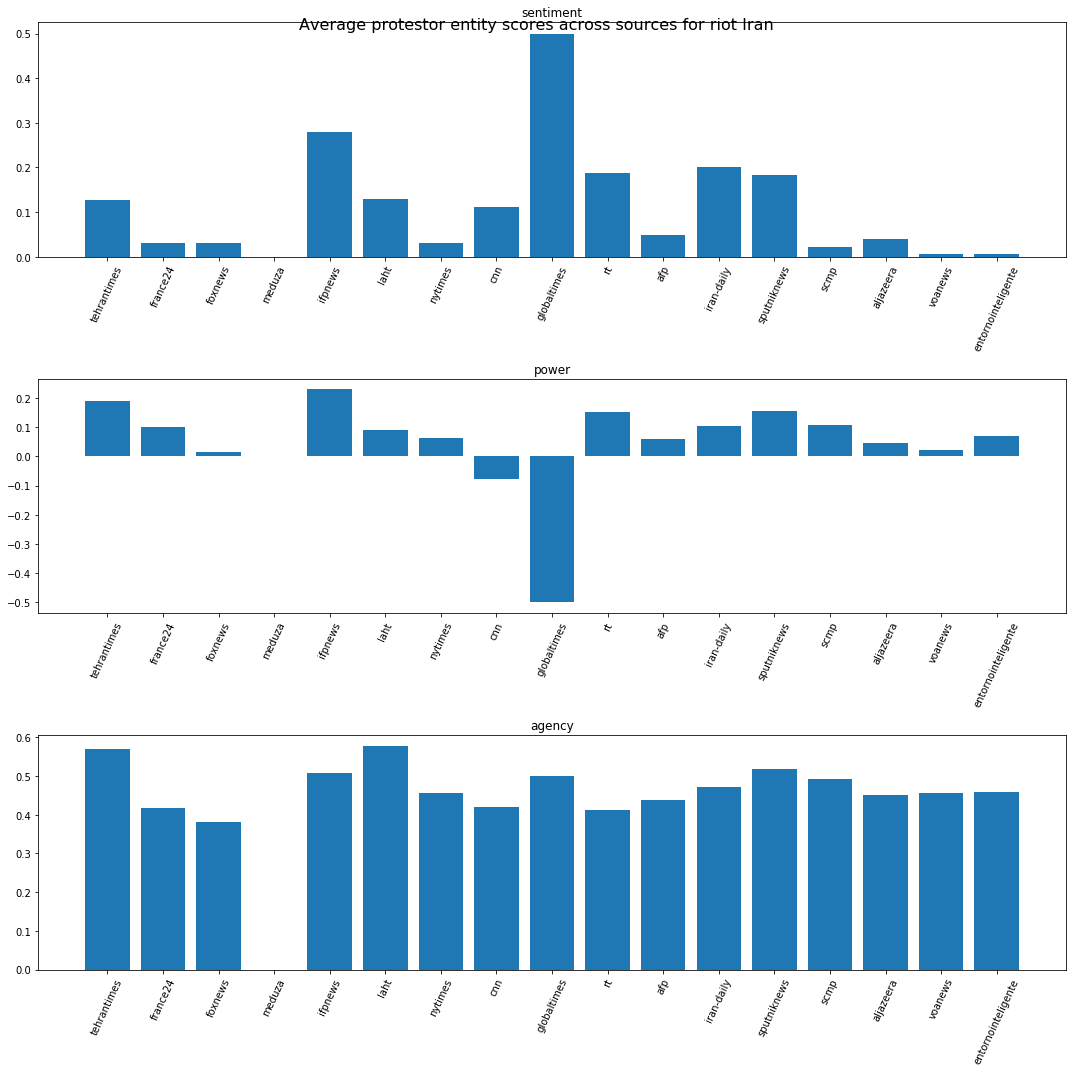

In [32]:
for riot in protestor_entity_scores:
    scores = {source : sumScores(scores) for source, scores in protestor_entity_scores[riot].items()}
    plotScores(scores , KEYS[:3],"Average protestor entity scores across sources for riot {}".format(riot))

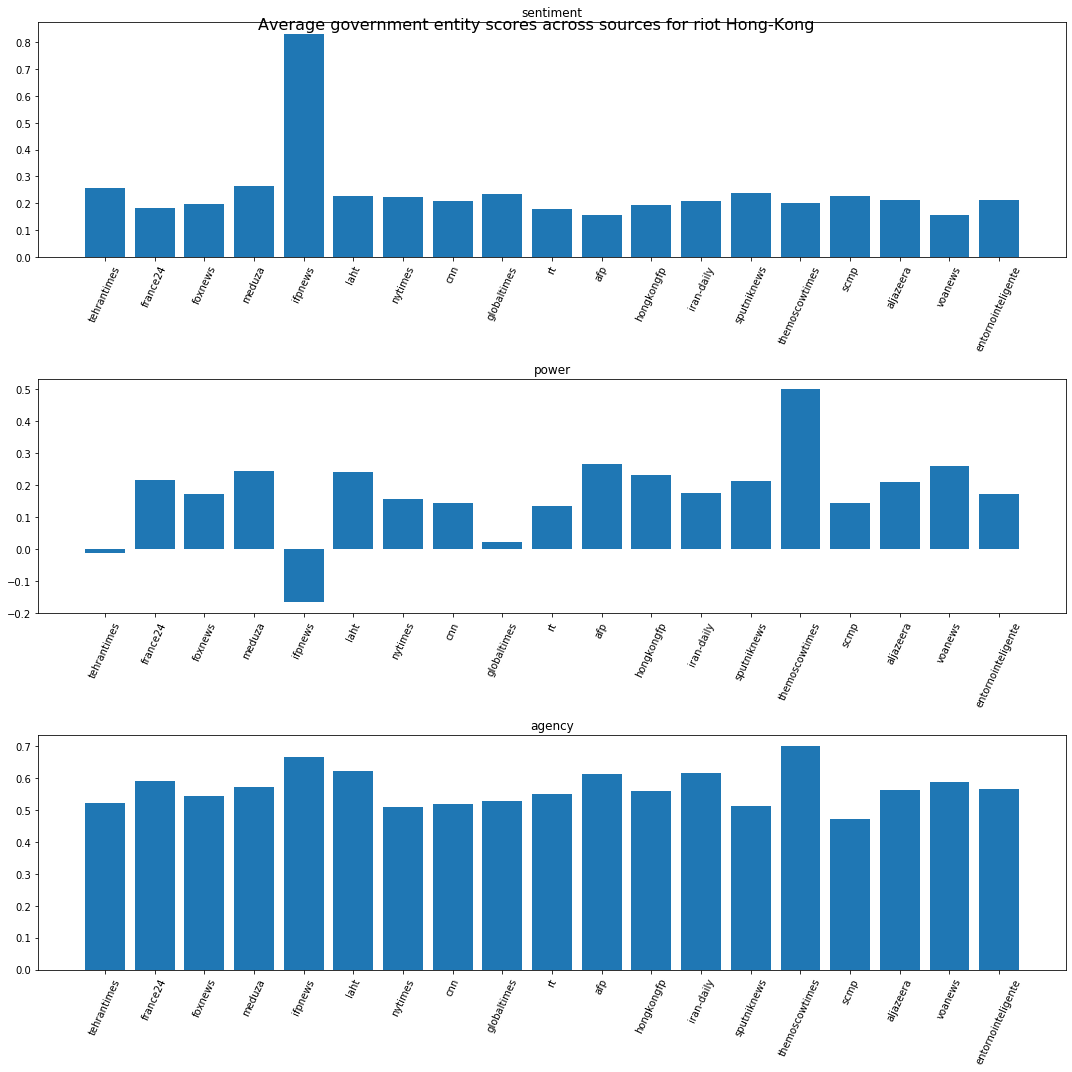

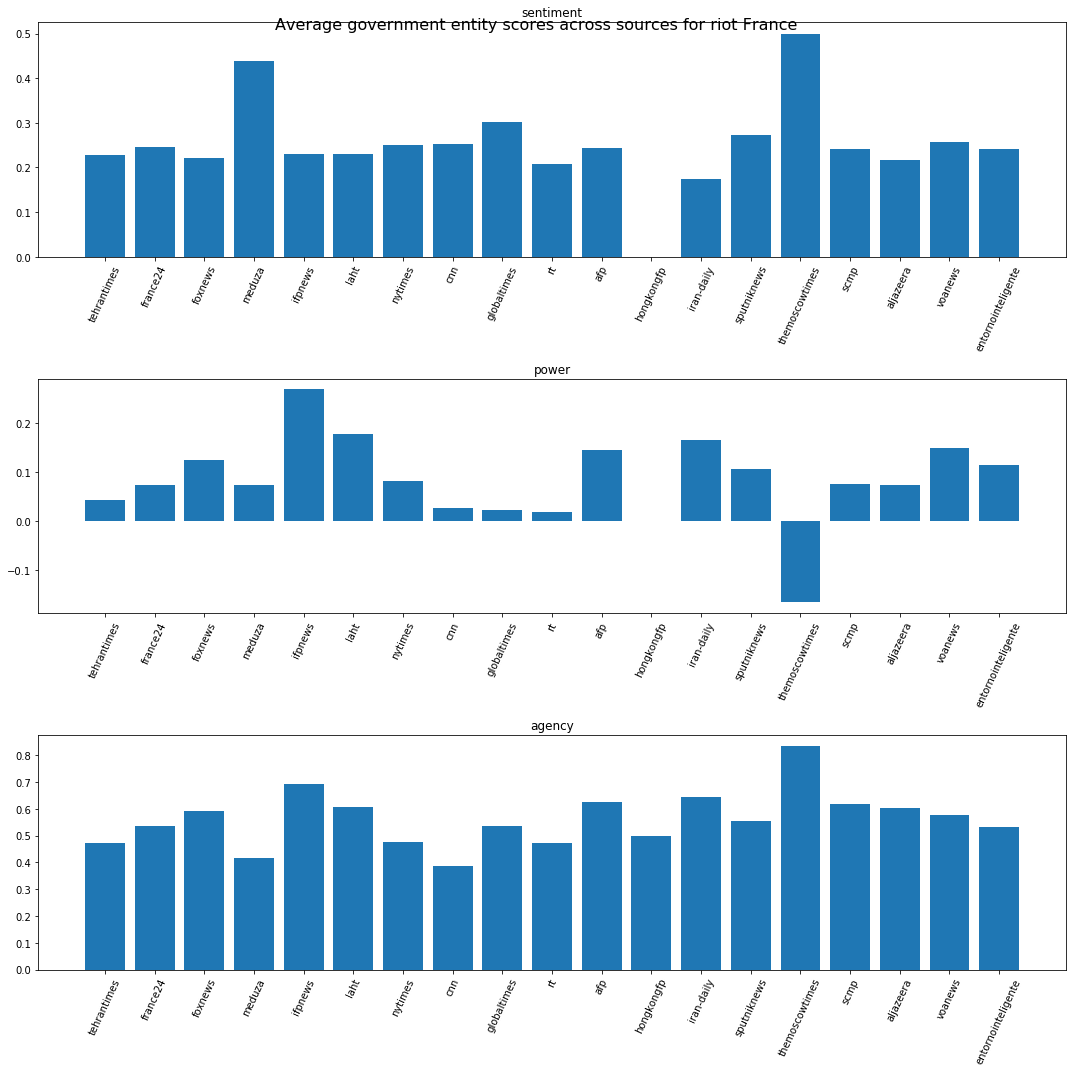

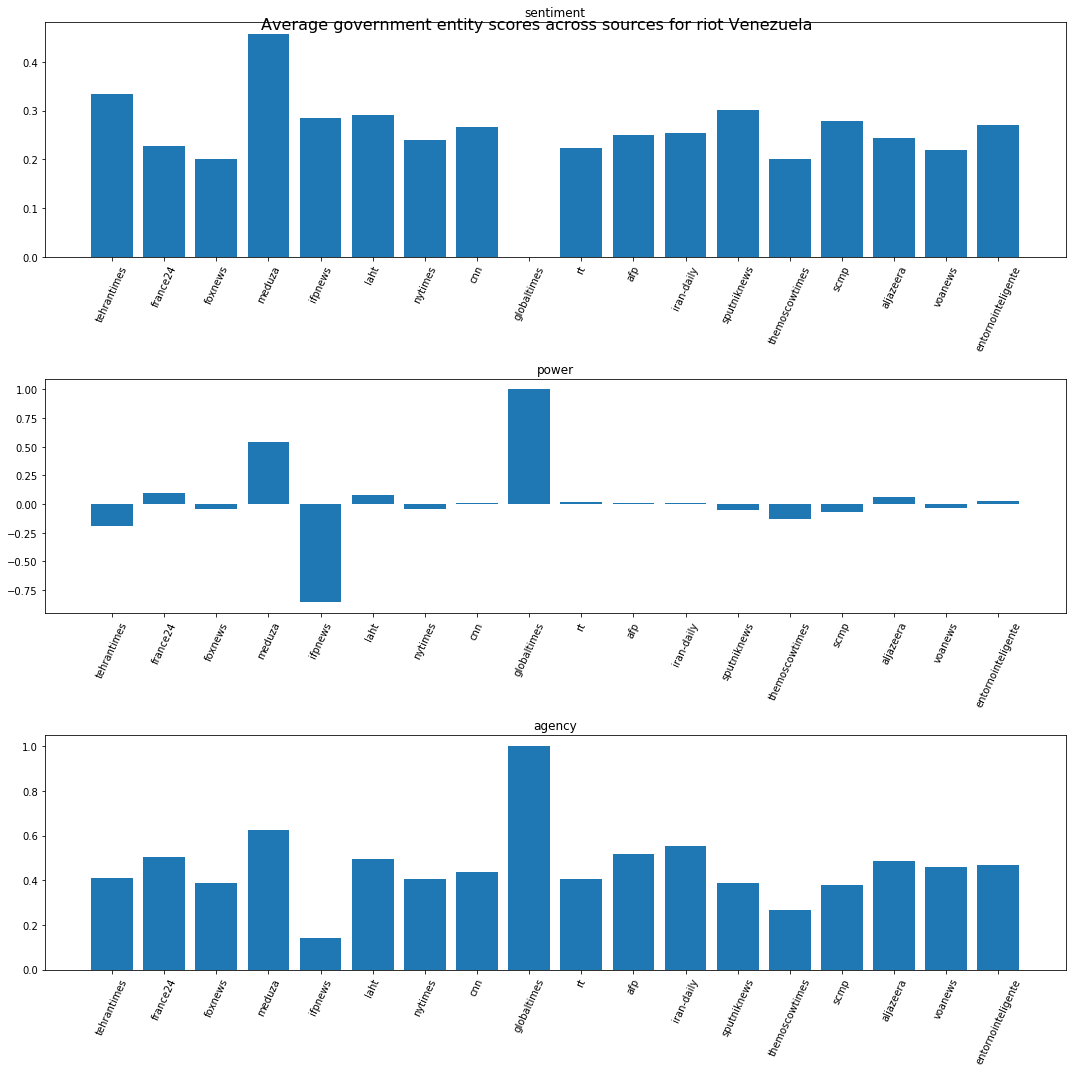

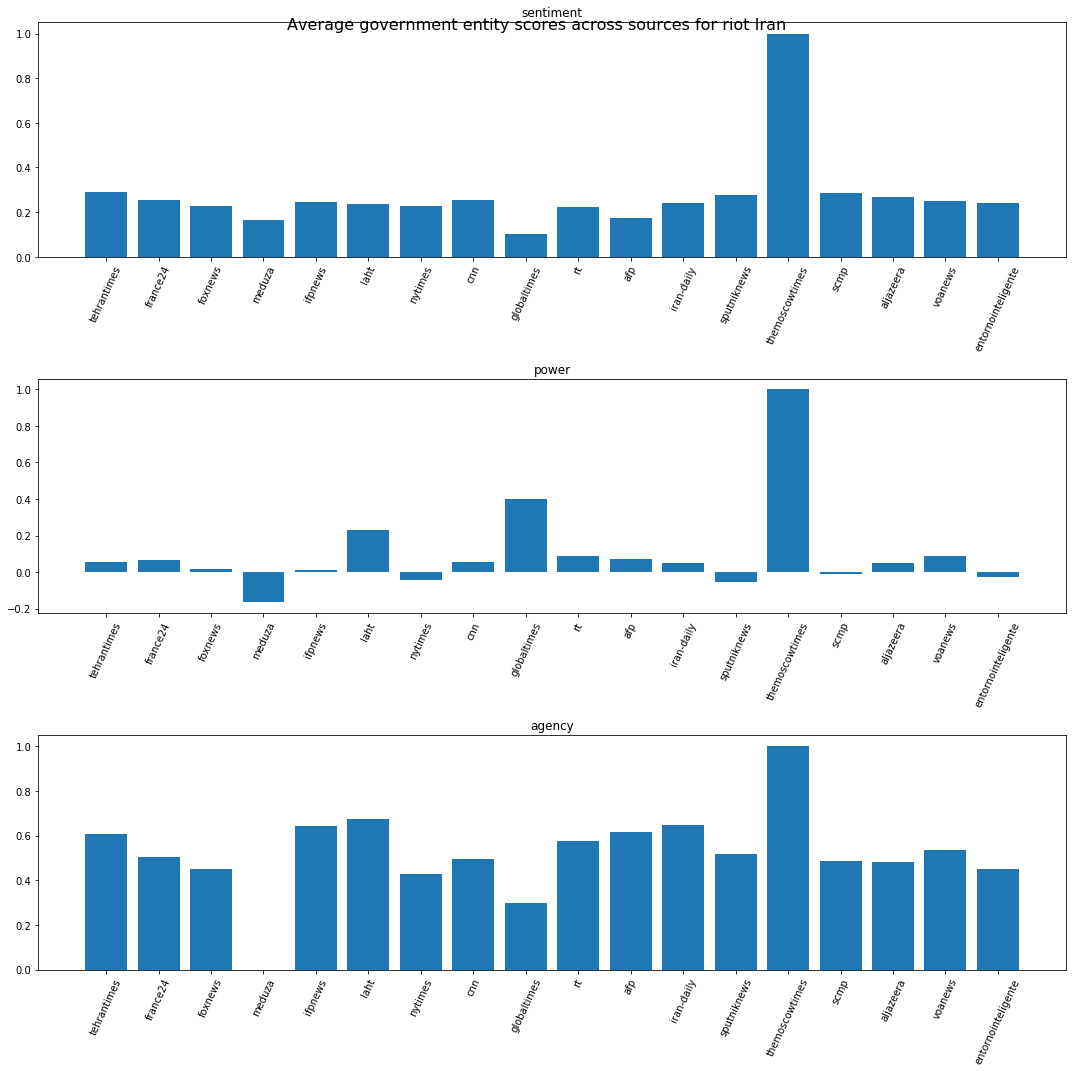

In [31]:
for riot in gov_entity_scores:
    scores = {source : sumScores(scores) for source, scores in gov_entity_scores[riot].items()}
    plotScores(scores , KEYS[:3],"Average government entity scores across sources for riot {}".format(riot))

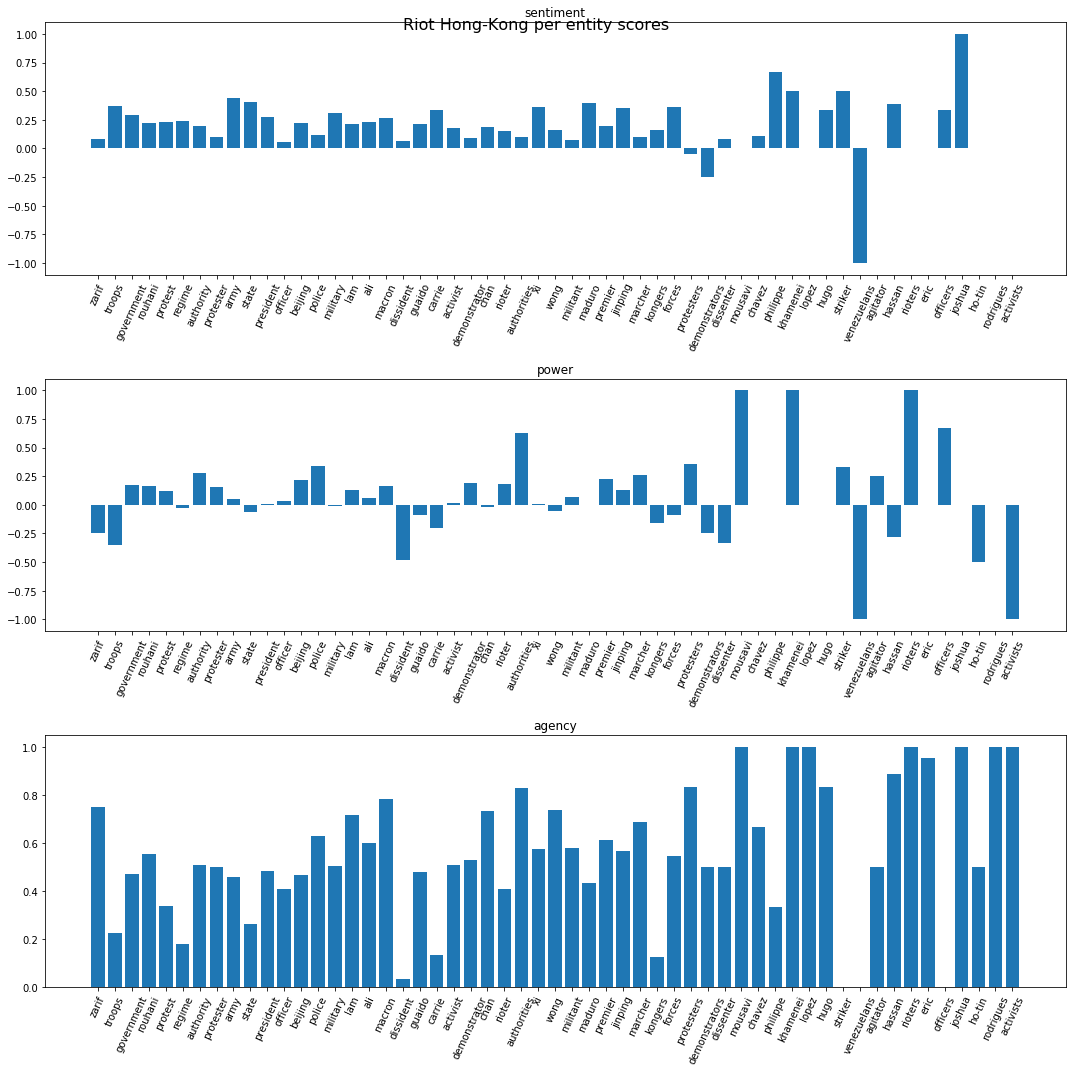

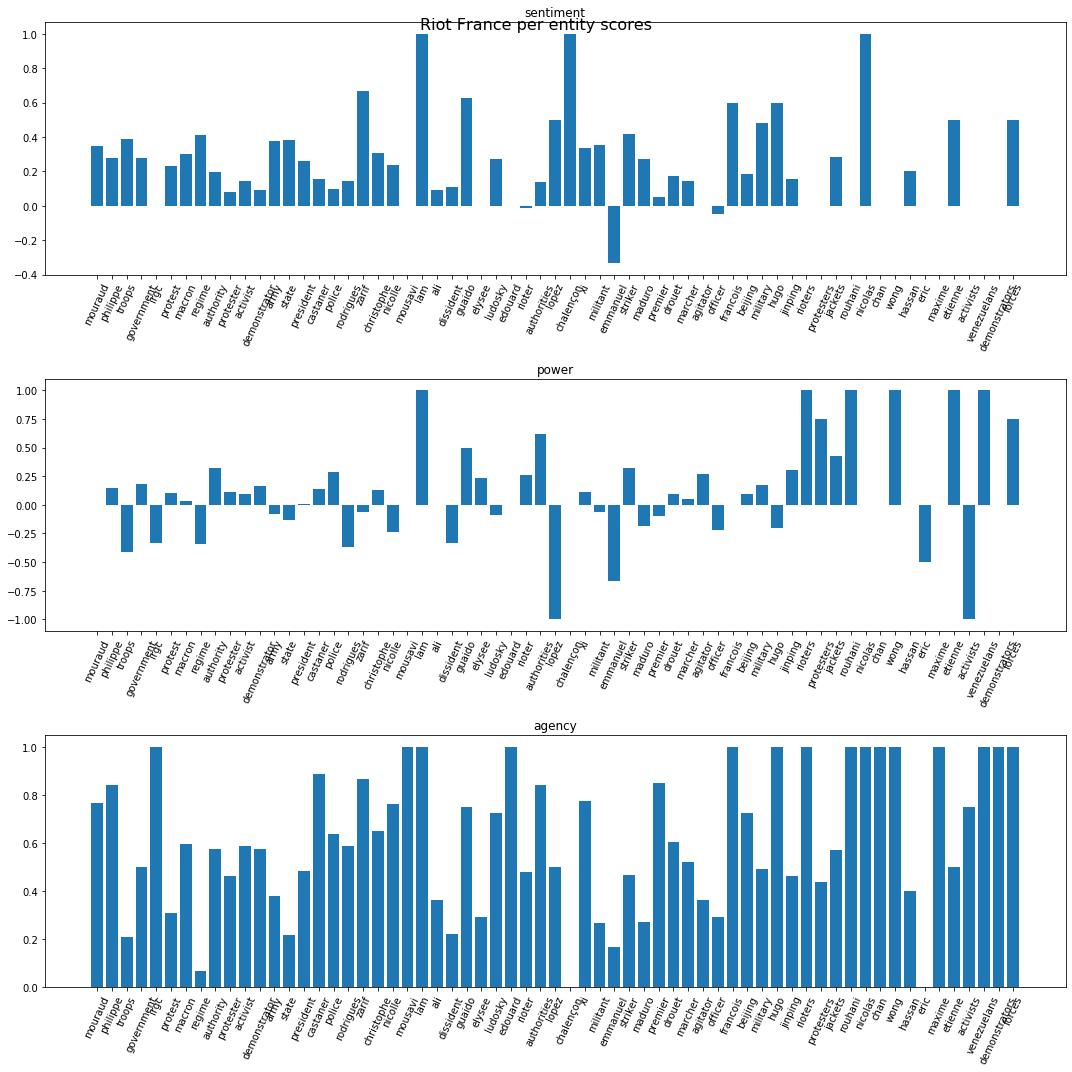

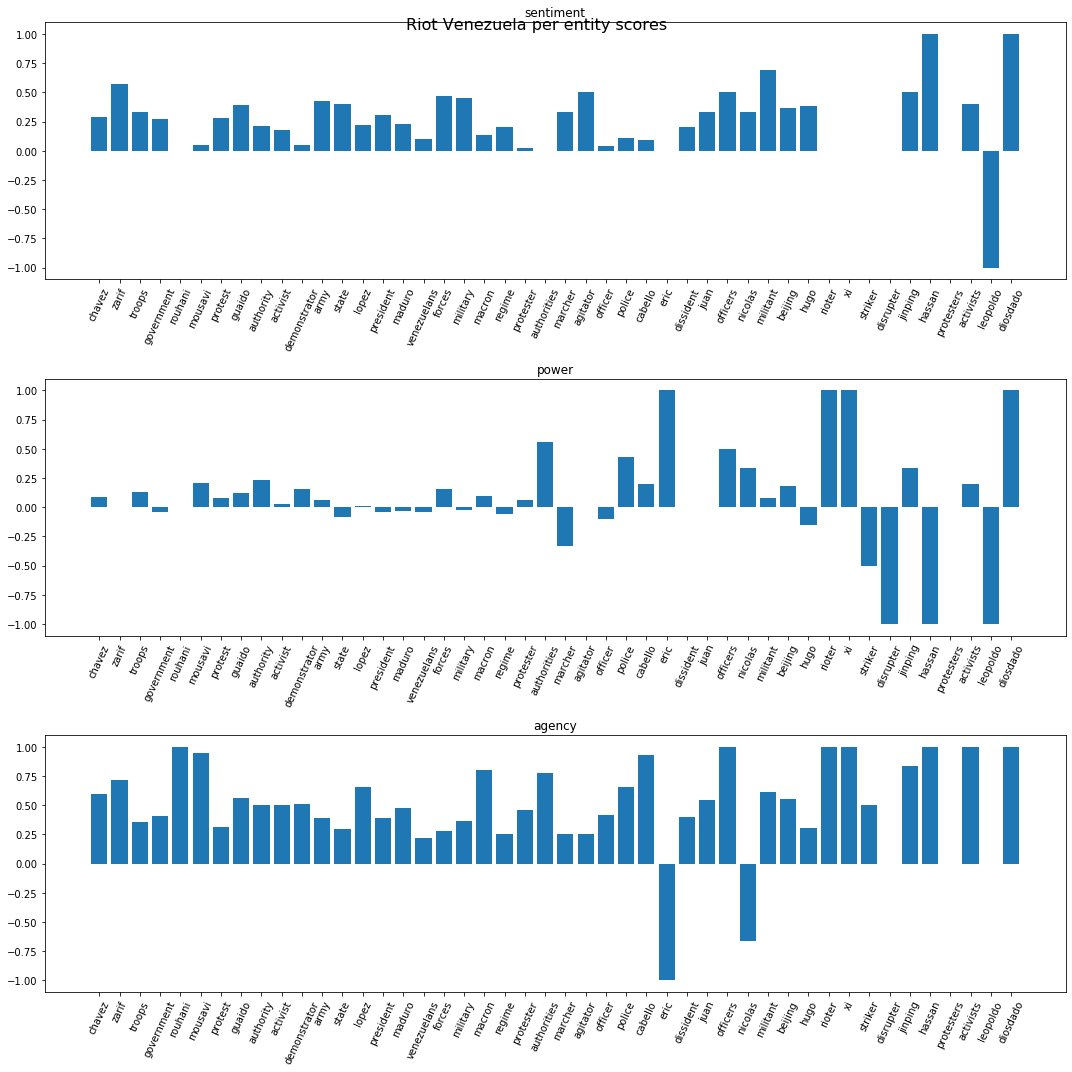

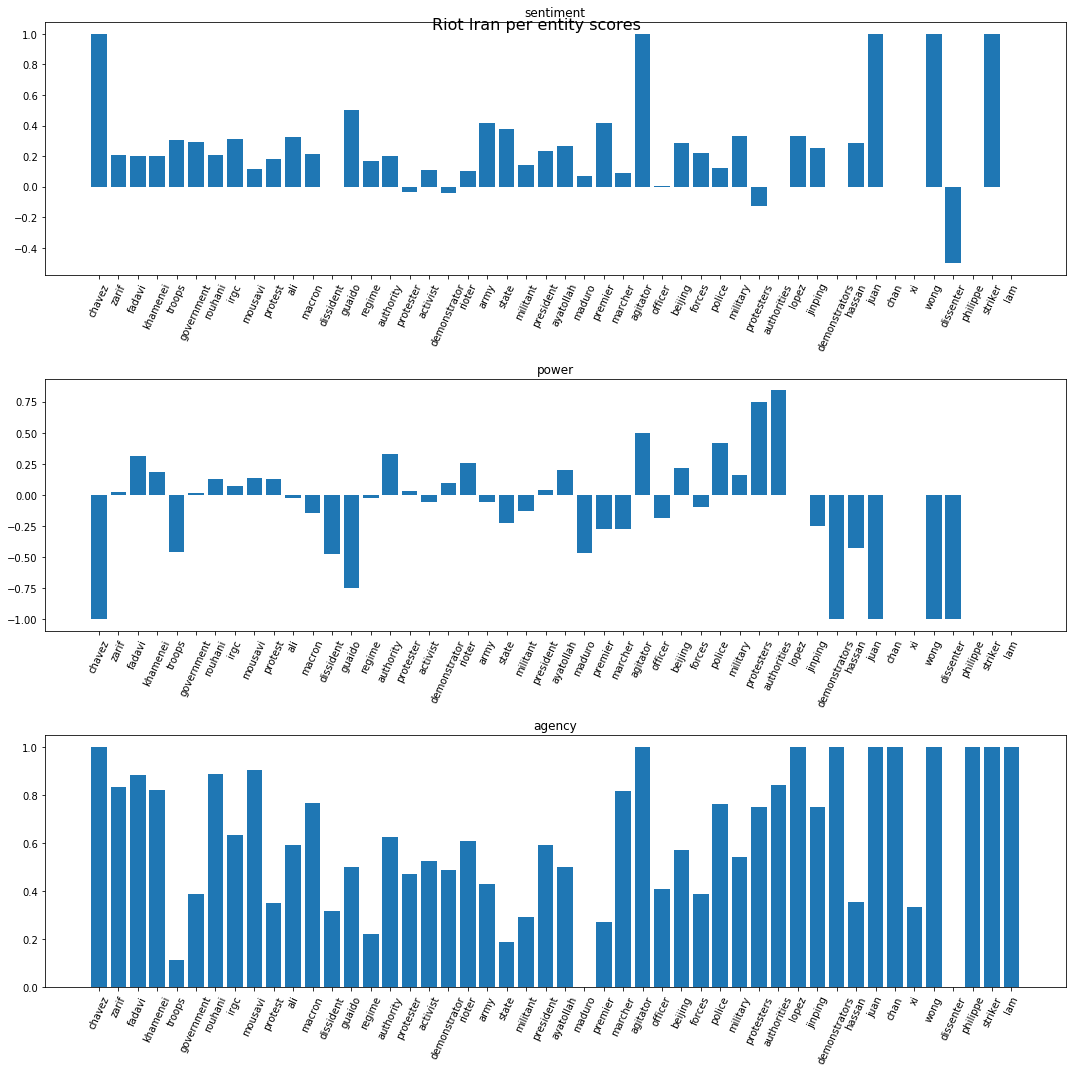

In [14]:
for riot in riot_entity_scores:
    #import pdb;pdb.set_trace()
    plotScores(riot_entity_scores[riot] , KEYS[:3],"Riot {} per entity scores".format(riot))

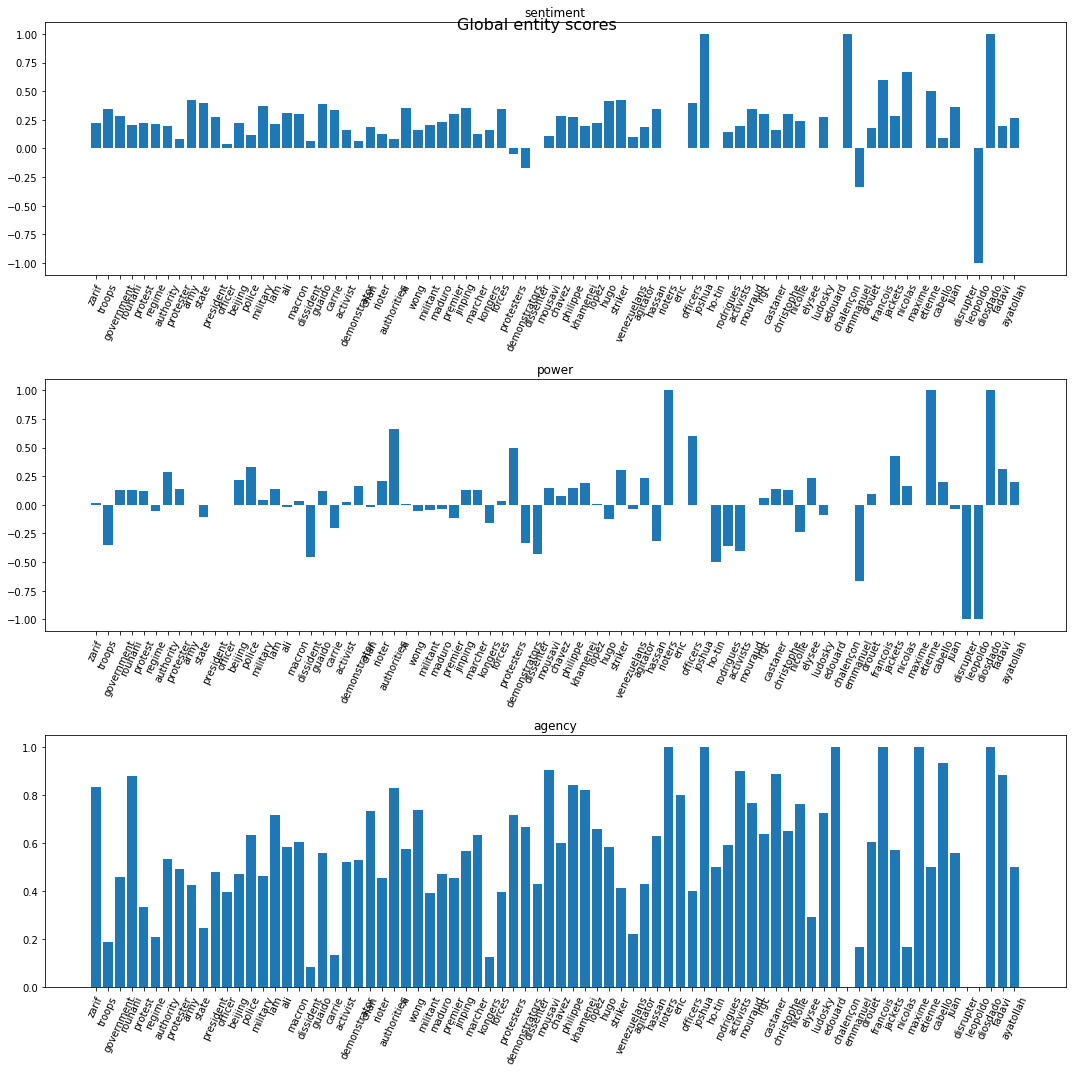

In [15]:
plotScores(global_entity_scores , KEYS[:3],"Global entity scores")

In [ ]:
for riot in results:
    for source in results[riot]:
        plotScores(results[riot][source] , KEYS[:3],"Riot in {} reported on by {} per entity scores".format(riot,source))

In [ ]:
# We could also account for the absence of entities or their counts.

for riot in riot_entity_scores:
    plotScores(riot_entity_scores[riot] , KEYS,"Riot {} with raw entity counts and score".format(riot), normalize=False)
    

In [ ]:
plotScores(global_entity_scores , KEYS,"Raw global entity scores", normalize=False)

In [ ]:
for riot in results:
    for source in results[riot]:
        plotScores(results[riot][source] , KEYS,"Riot in {} reported on by {} raw entity scores".format(riot,source), normalize=False)

In [ ]:
set([source for riot in results for source in results[riot]])

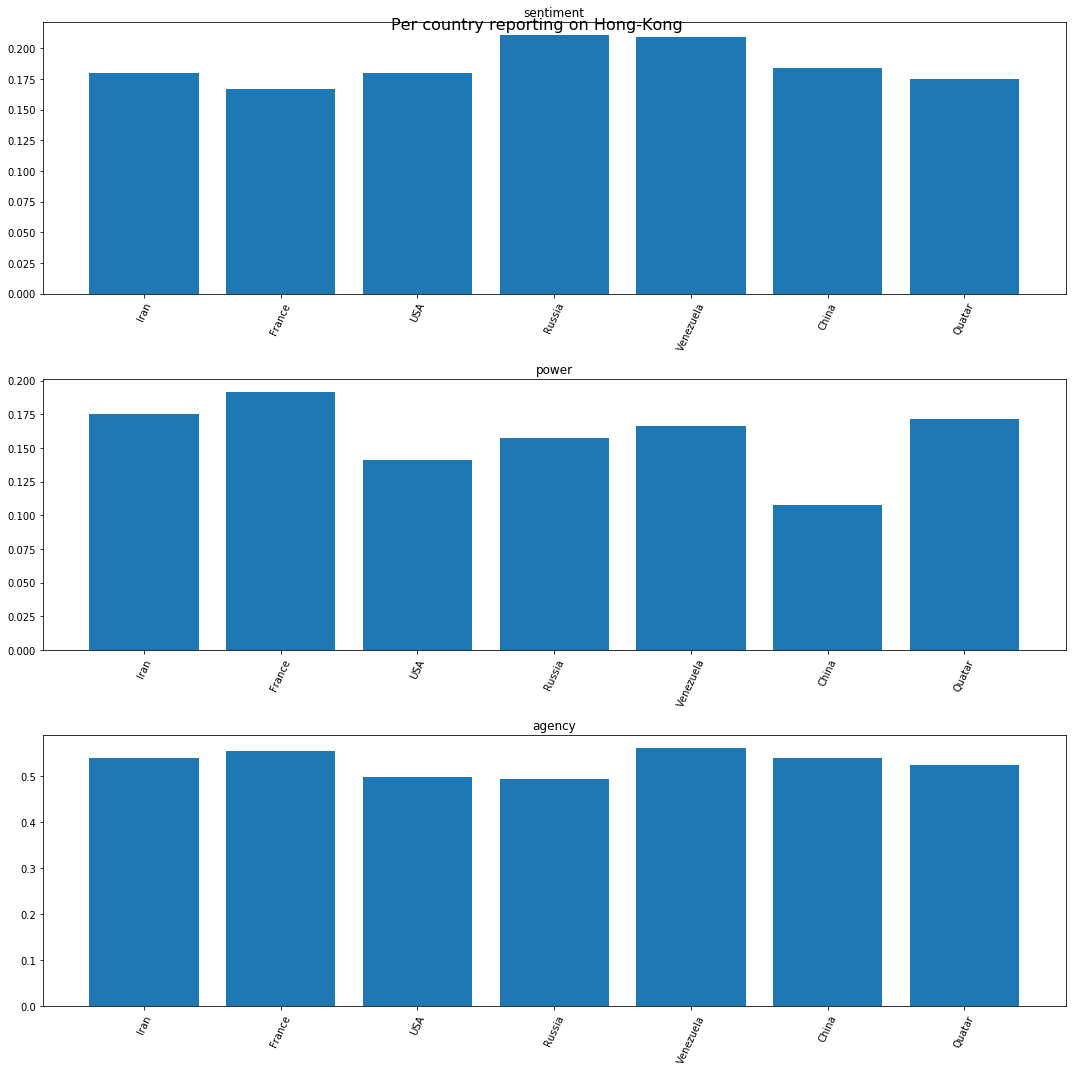

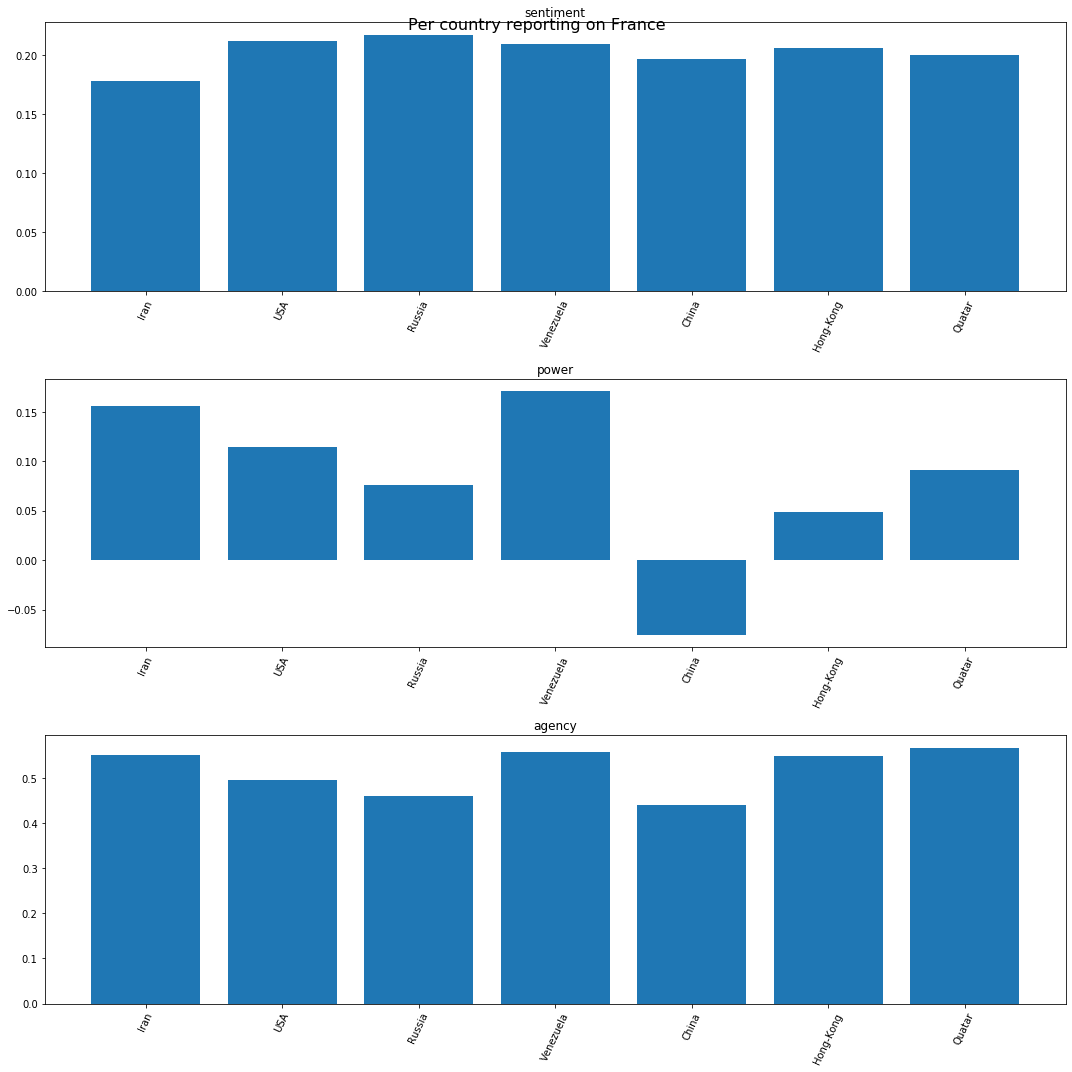

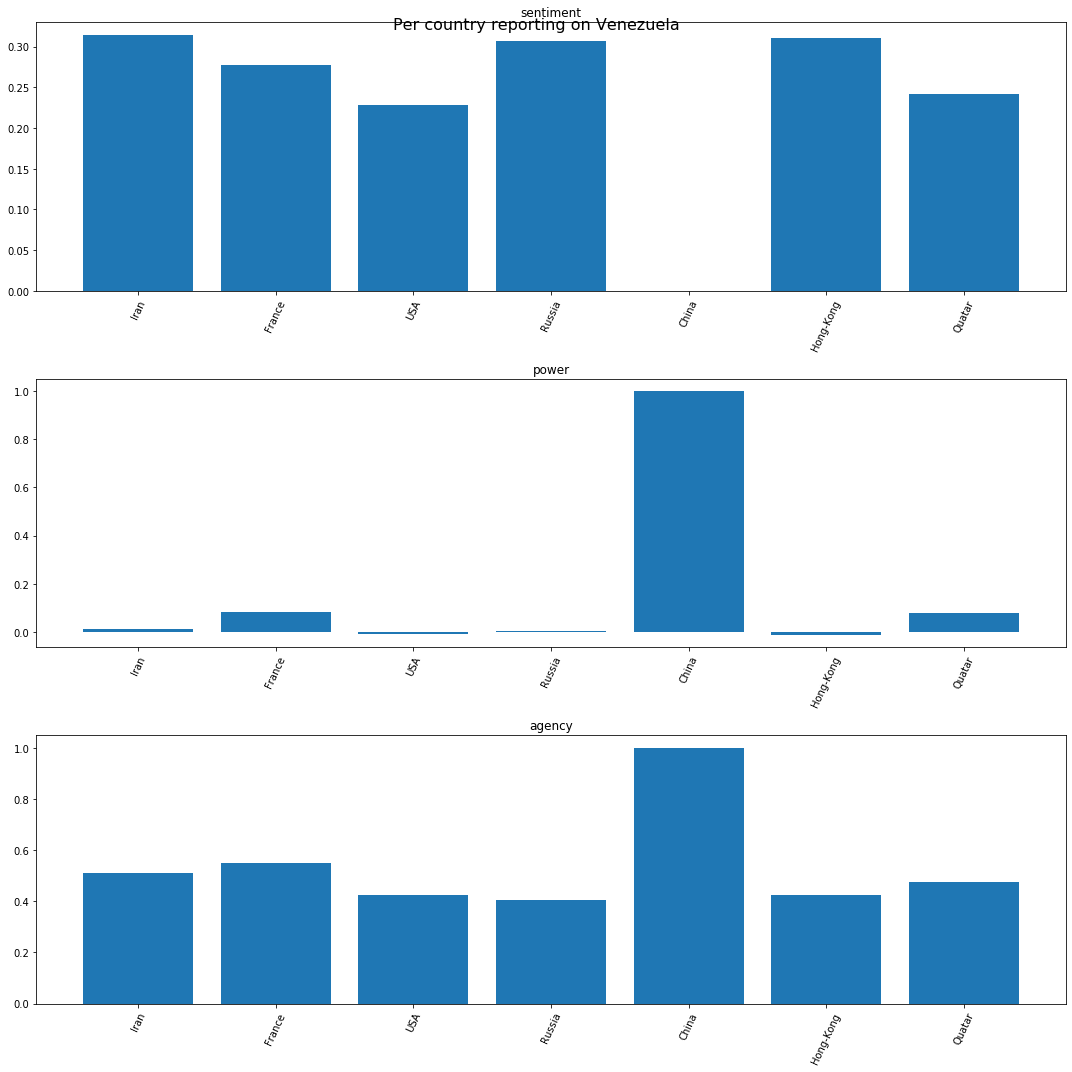

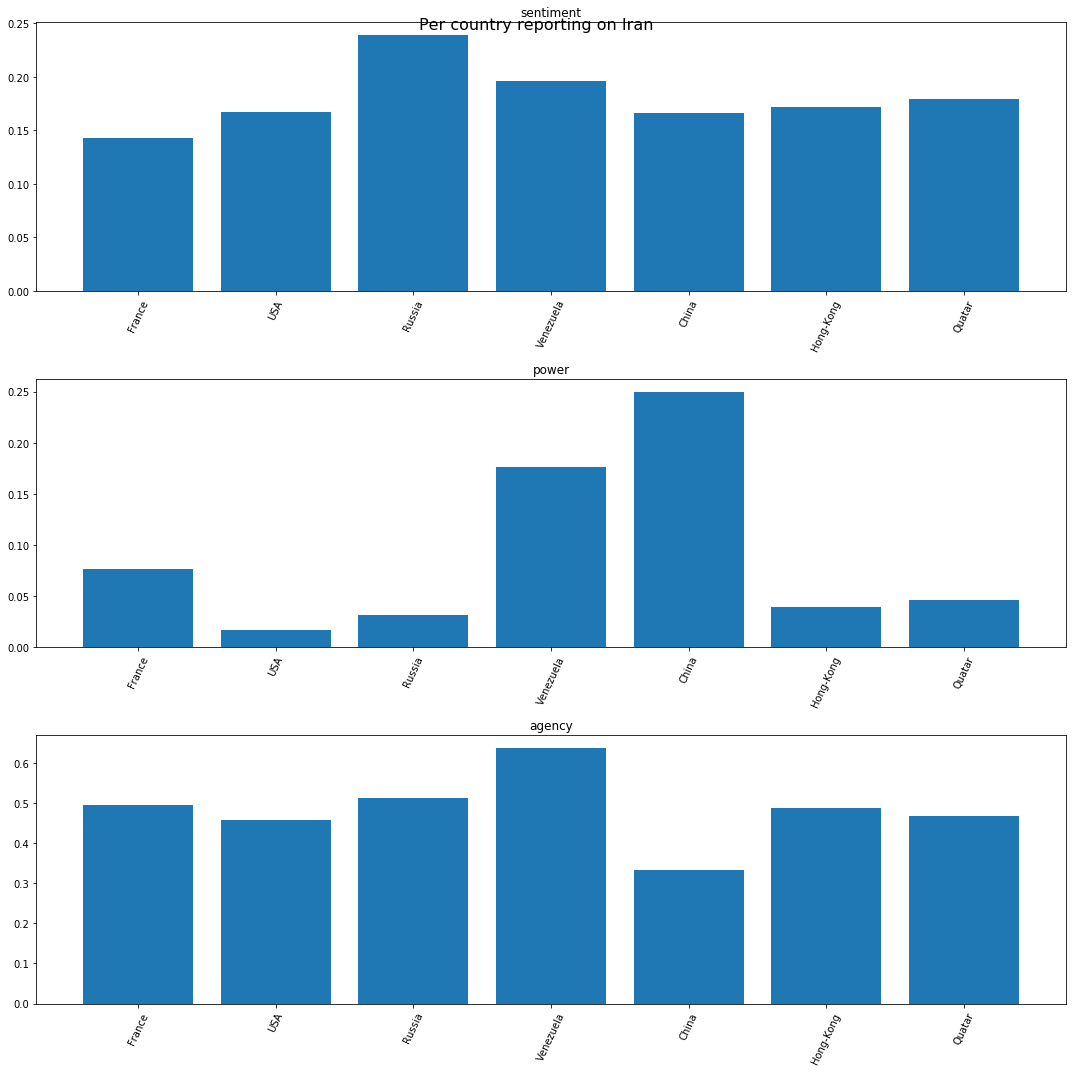

In [16]:
for riot in per_country_entity_scores:
        plotScores({country : sumScores(scores) for country, scores in out_of_country_entity_scores[riot].items()}, KEYS[:3],"Per country reporting on {}".format(riot))

In [ ]:
set([riot for riot in results])

In [8]:
out_of_country_entity_scores[riot]

defaultdict(list,
            {'Iran': [{'sentiment': 1, 'power': 0, 'agency': 3, 'count': 3},
              {'sentiment': 2, 'power': -5, 'agency': 4, 'count': 11},
              {'sentiment': 5, 'power': 7, 'agency': 14, 'count': 21},
              {'sentiment': 1, 'power': 1, 'agency': 1, 'count': 1},
              {'sentiment': 1, 'power': 1, 'agency': 0, 'count': 5},
              {'sentiment': 0, 'power': 1, 'agency': 2, 'count': 2},
              {'sentiment': 0, 'power': 0, 'agency': 3, 'count': 3},
              {'sentiment': 1, 'power': 1, 'agency': 0, 'count': 1},
              {'sentiment': 0, 'power': -1, 'agency': 0, 'count': 1},
              {'sentiment': 0, 'power': 0, 'agency': 0, 'count': 2},
              {'sentiment': 5, 'power': -3, 'agency': 6, 'count': 18},
              {'sentiment': 0, 'power': 2, 'agency': 2, 'count': 2},
              {'sentiment': 4, 'power': 3, 'agency': 5, 'count': 7},
              {'sentiment': 1, 'power': -1, 'agency': 0, 'count': 1},


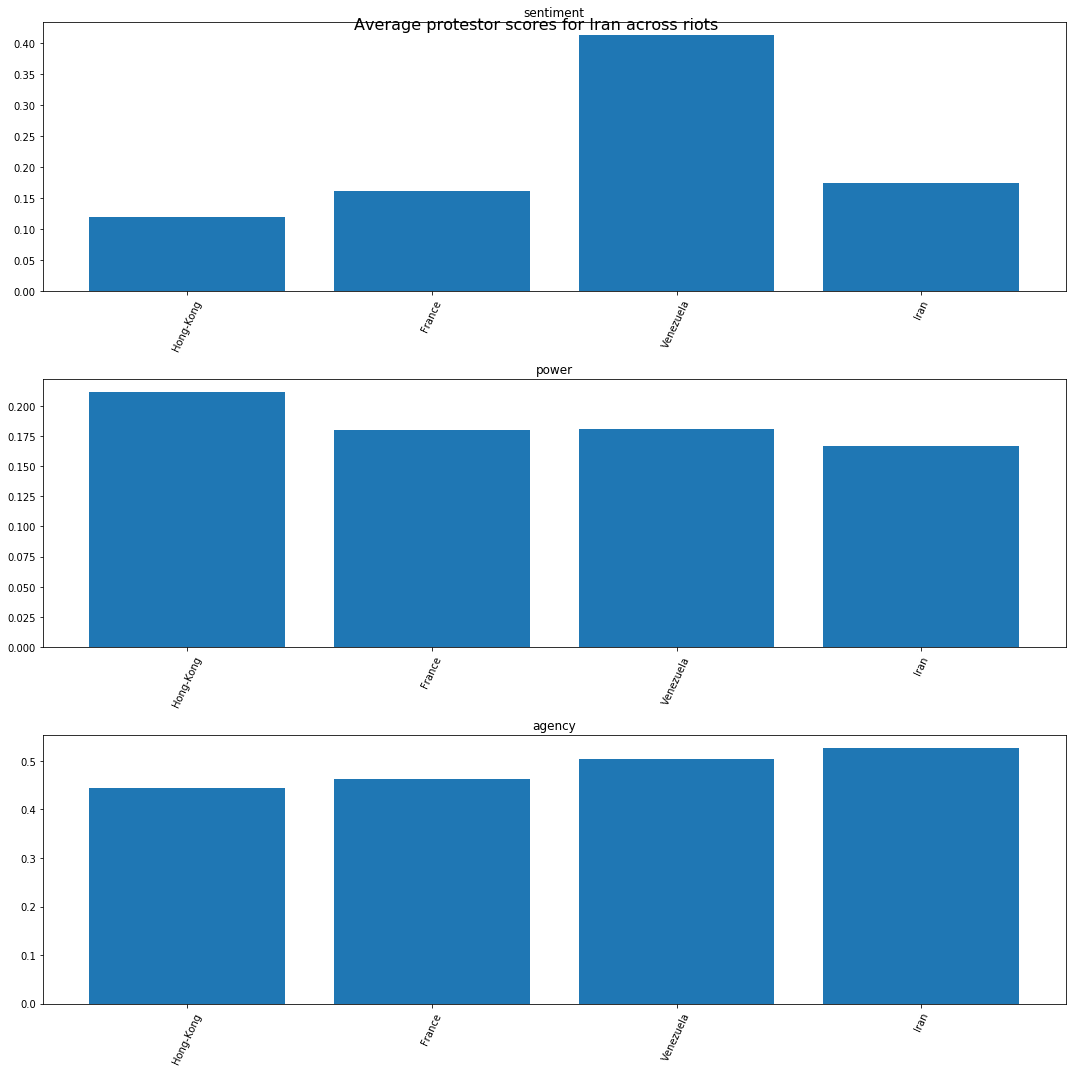

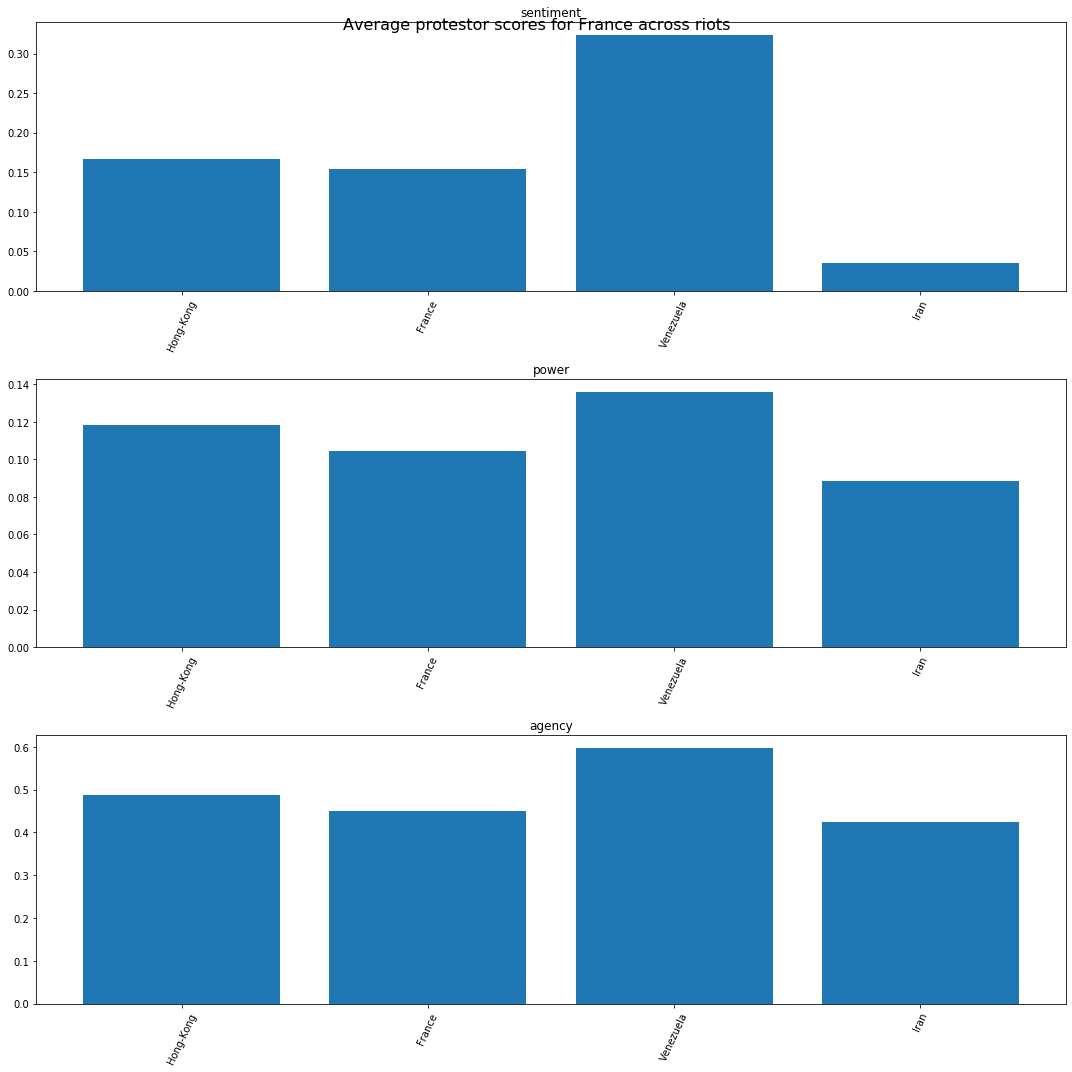

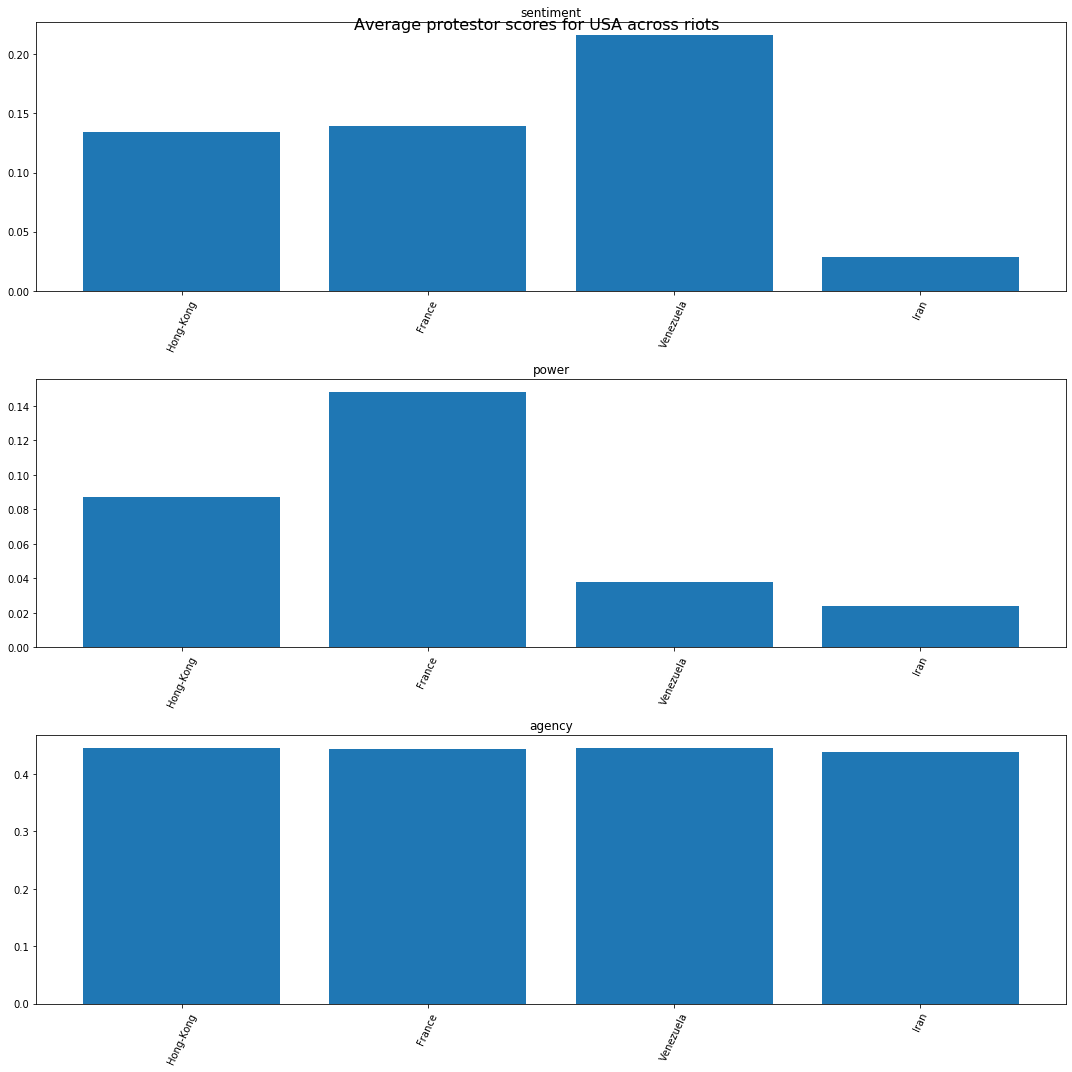

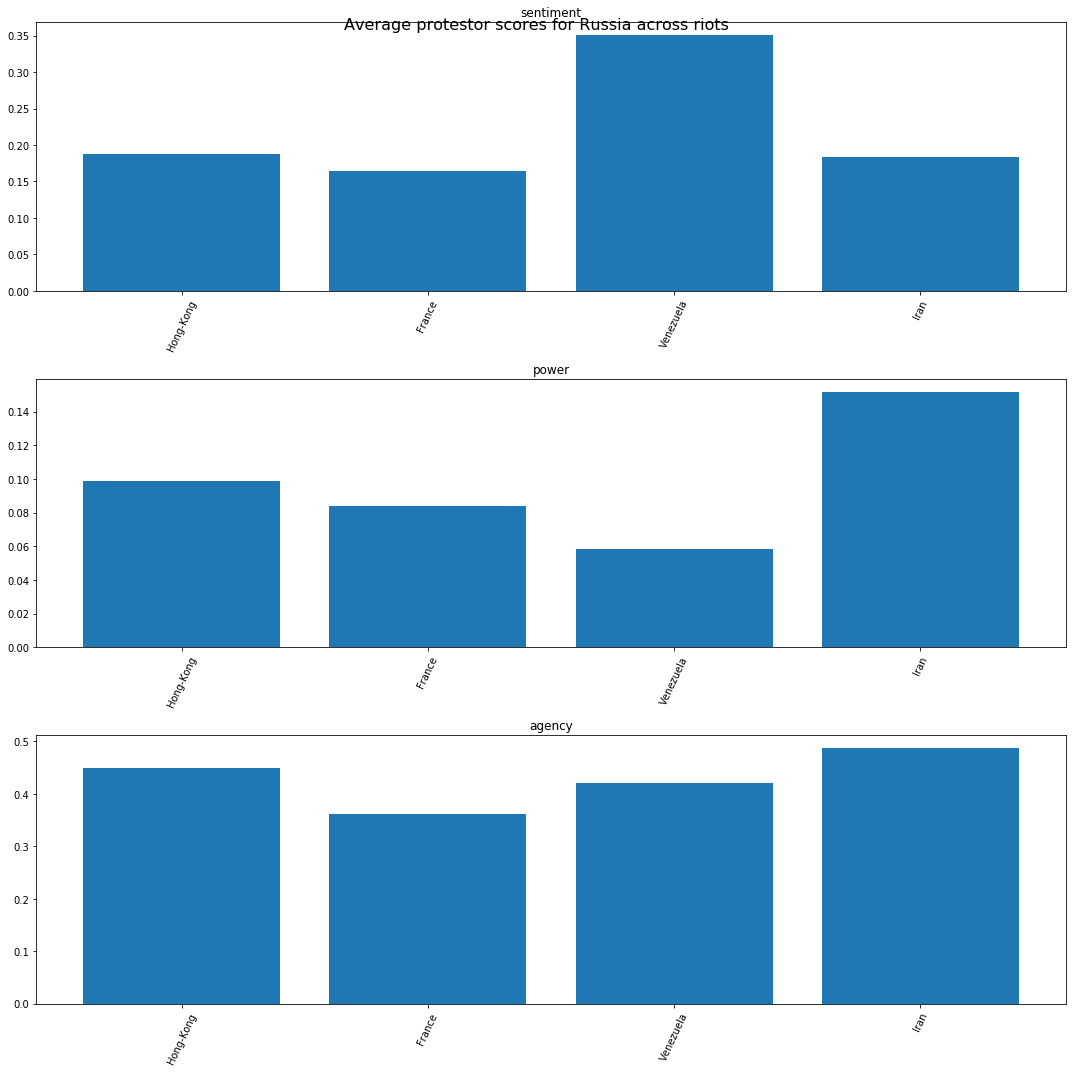

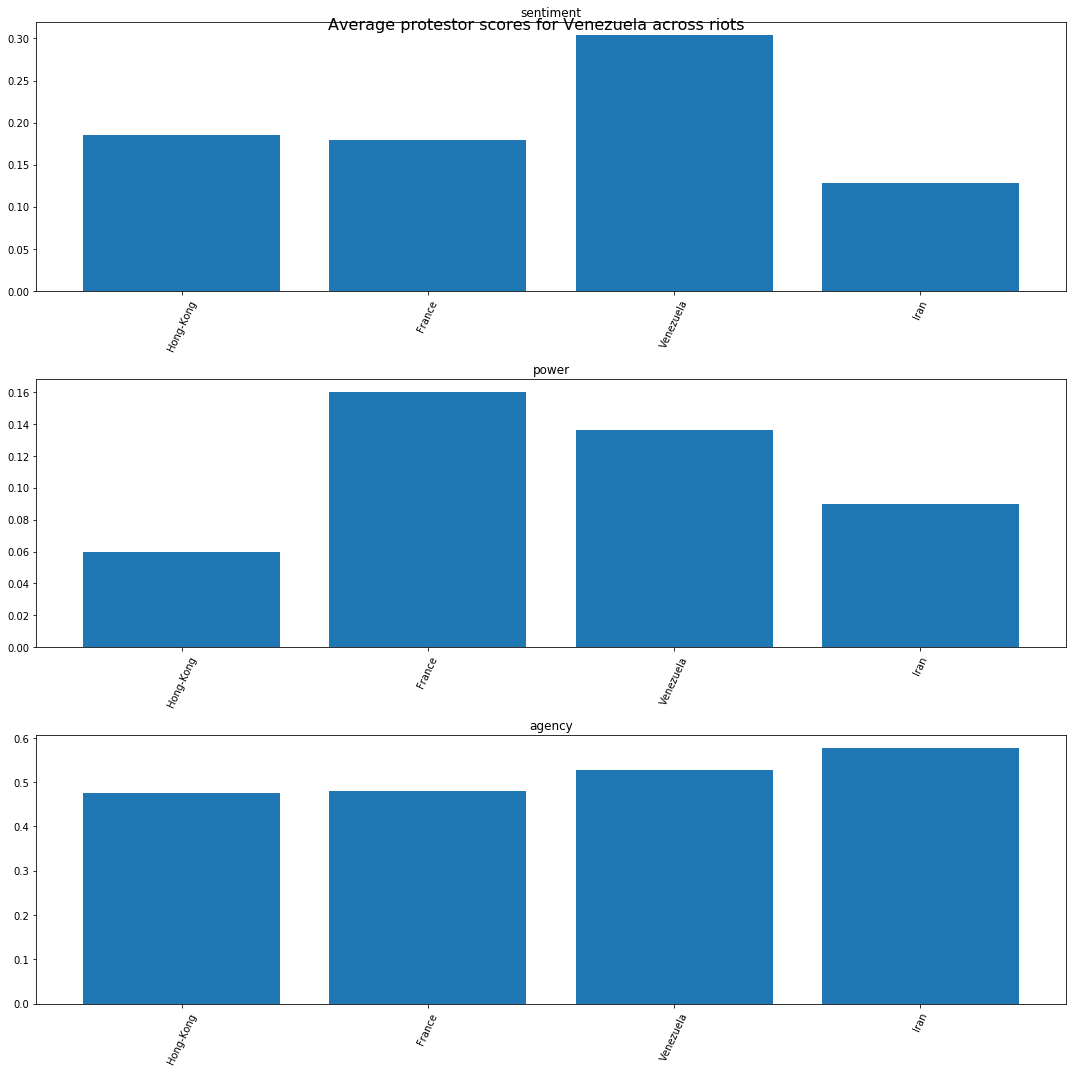

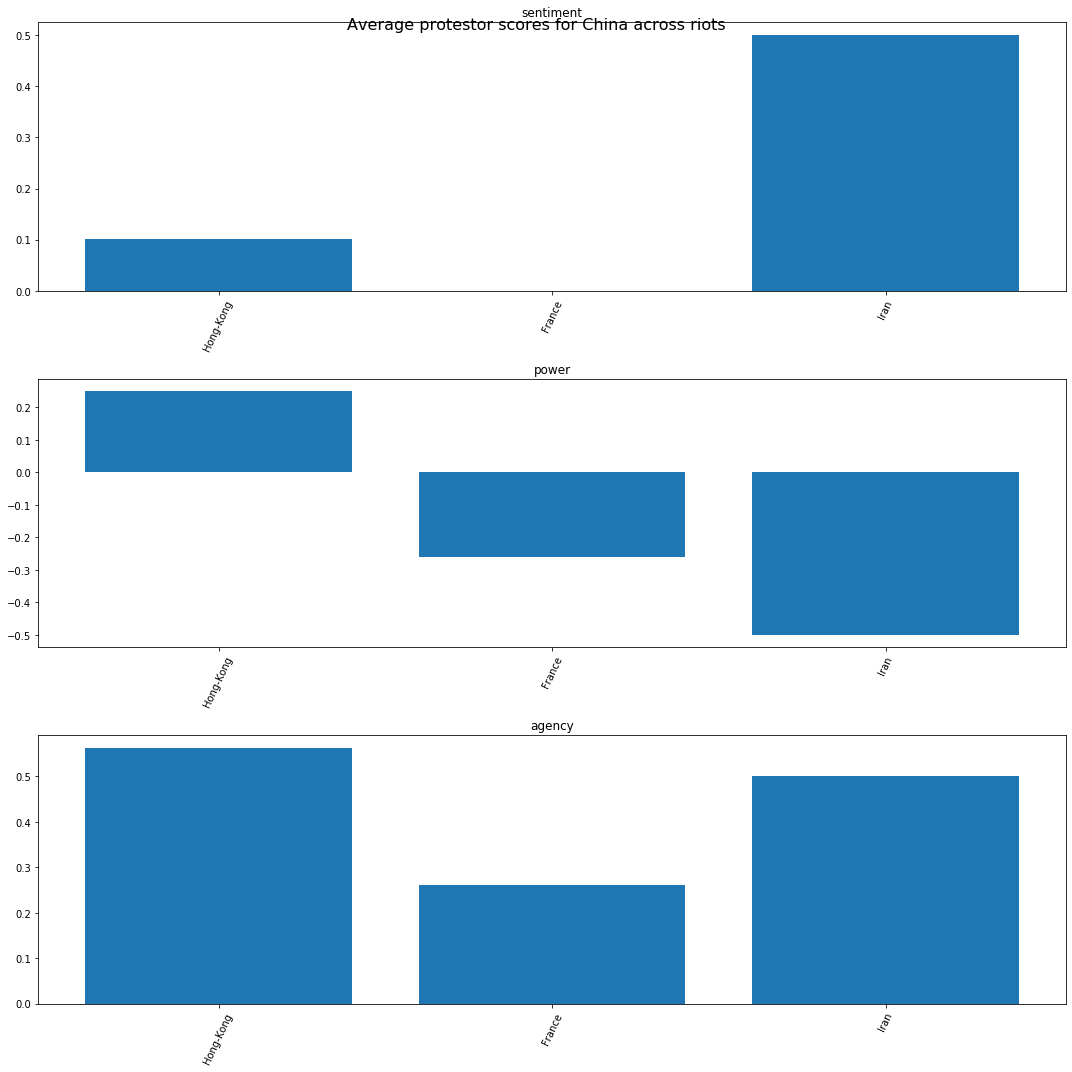

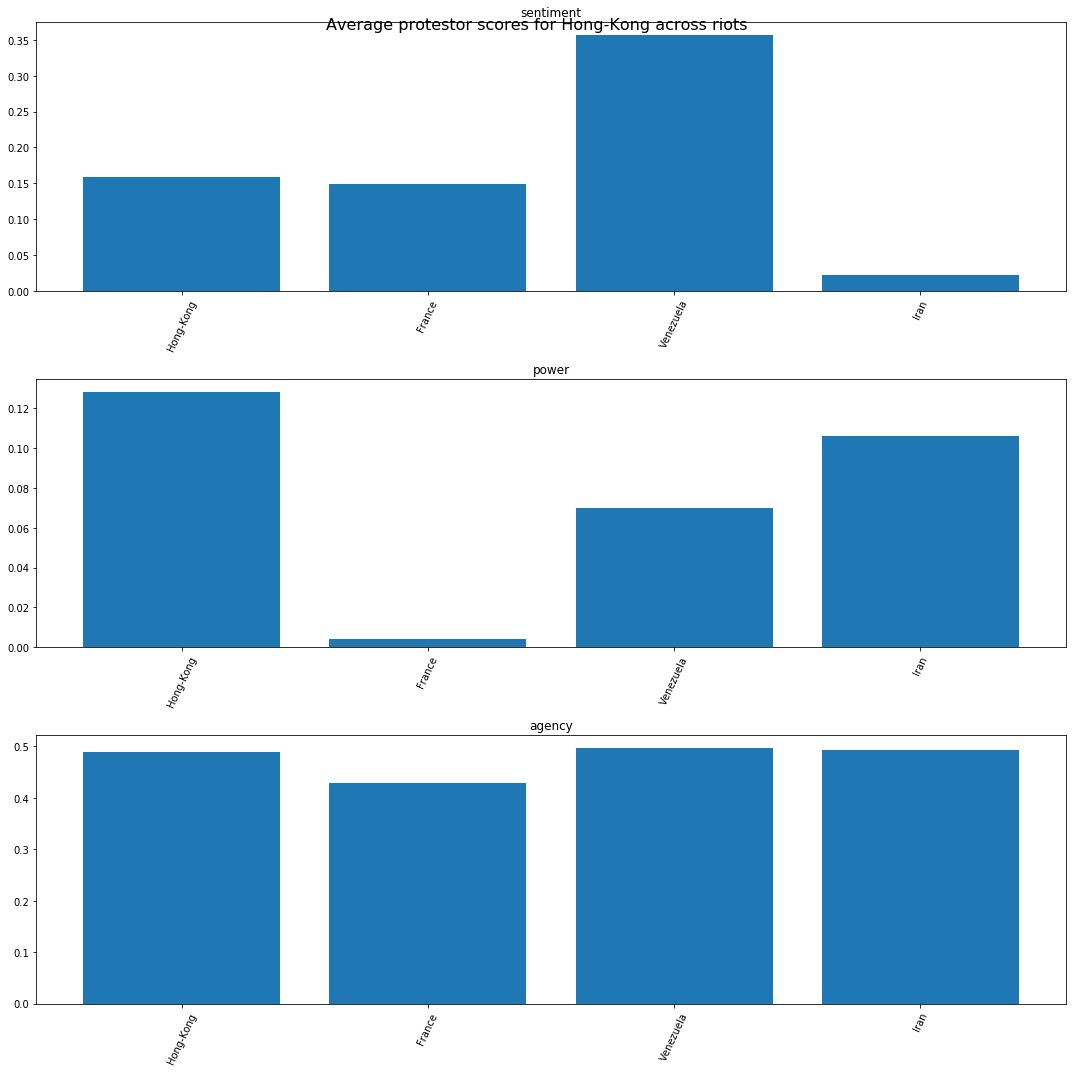

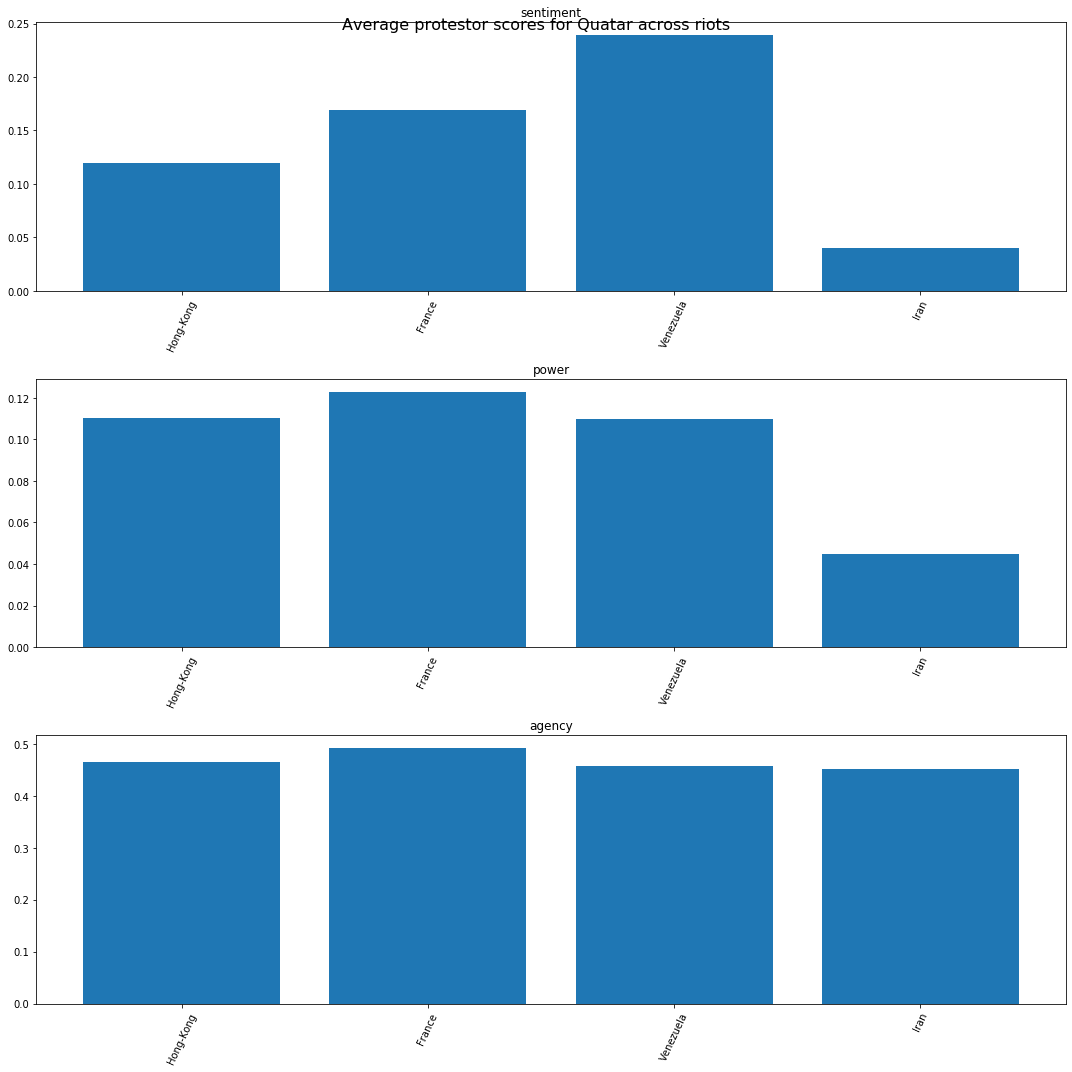

In [42]:
def articleToCountry(lut):
    countries_protestor = defaultdict(lambda: defaultdict(list))
    for source in lut:
        for riot in lut[source]:
            countries_protestor[source_to_country[source]][riot] += lut[source][riot]
    return countries_protestor

countries_protestor = articleToCountry(source_riot_protestor)
for country in countries_protestor:
    scores = {riot : sumScores(scores) for riot, scores in countries_protestor[country].items()}
    plotScores(scores , KEYS[:3],"Average protestor scores by sources from {} across riots".format(country))

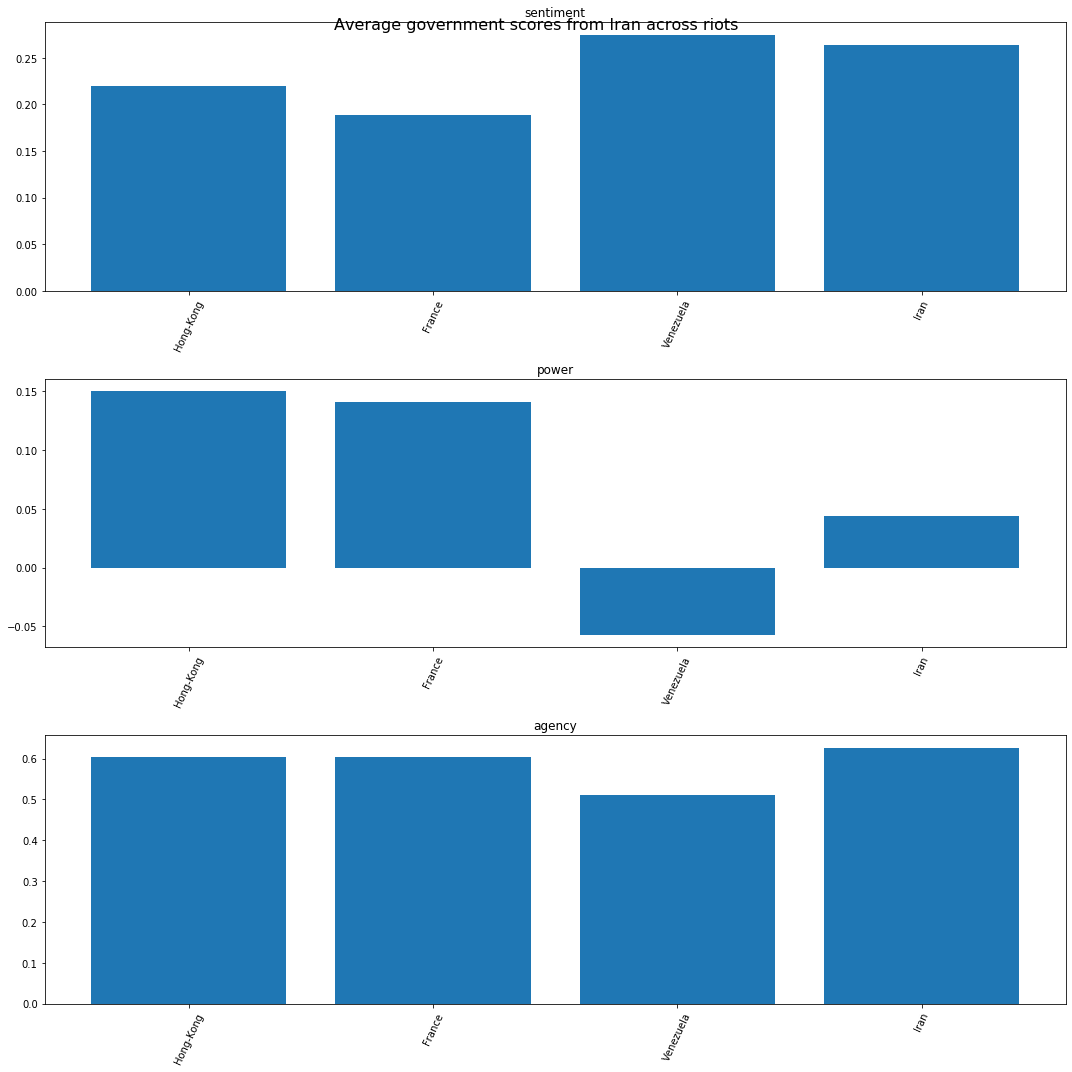

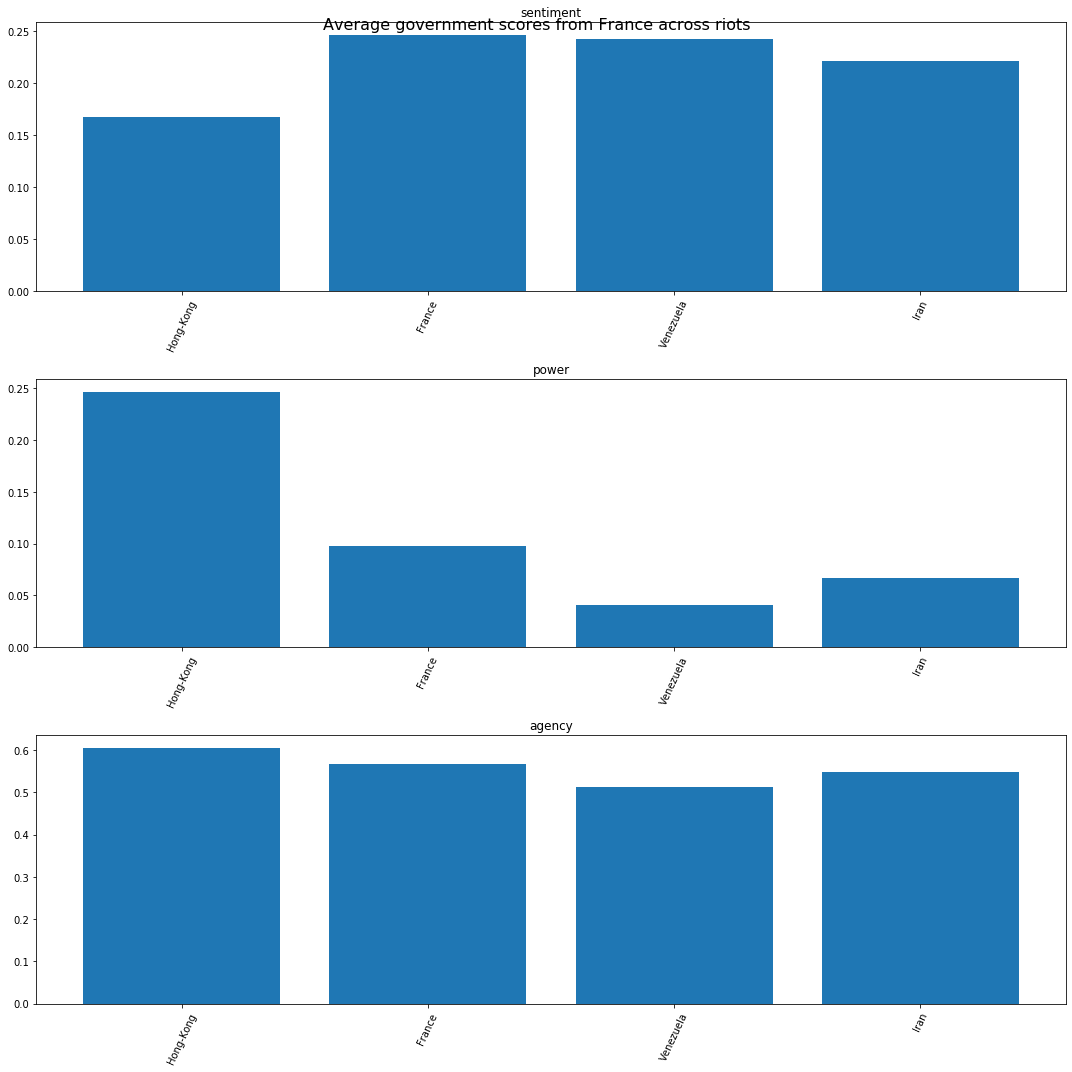

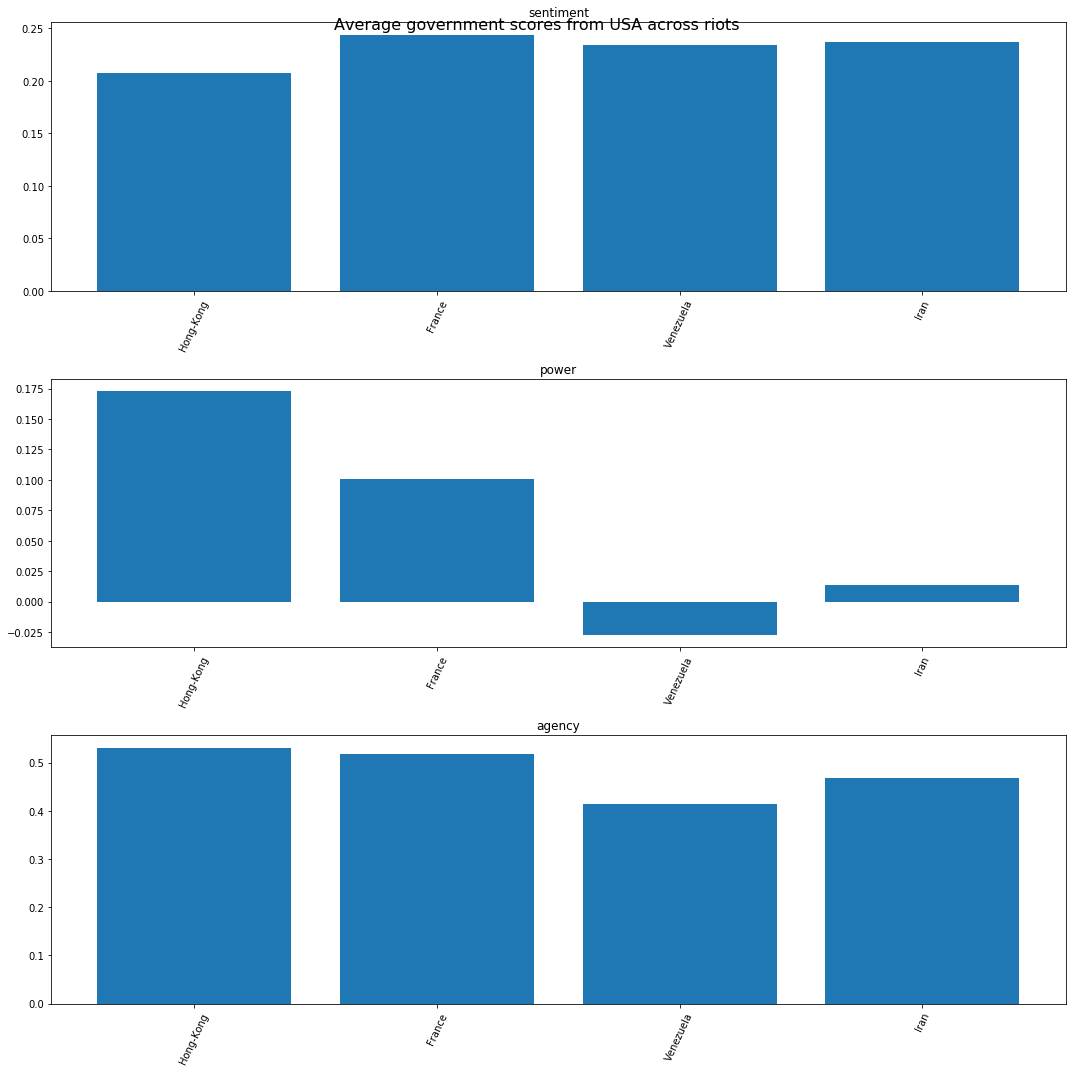

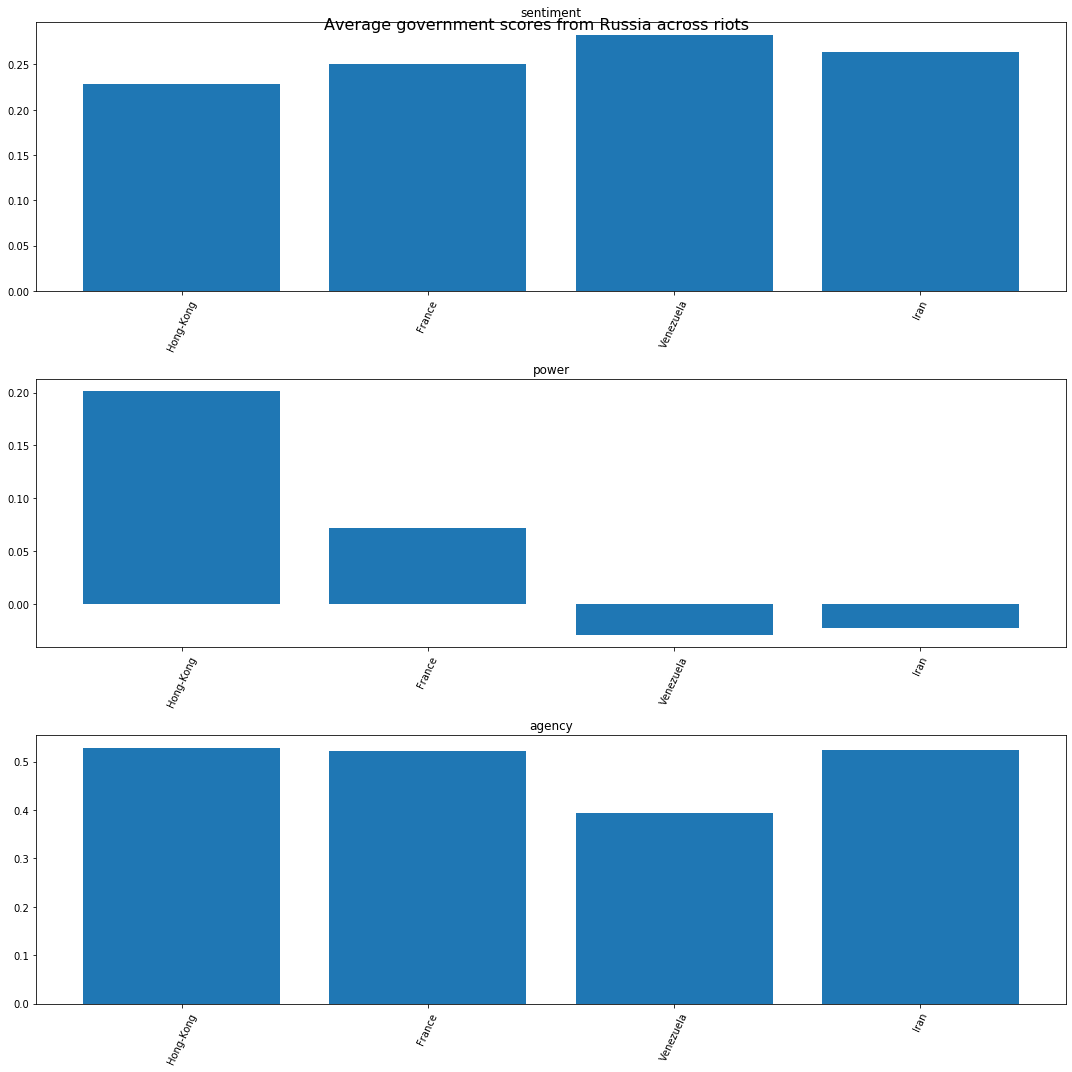

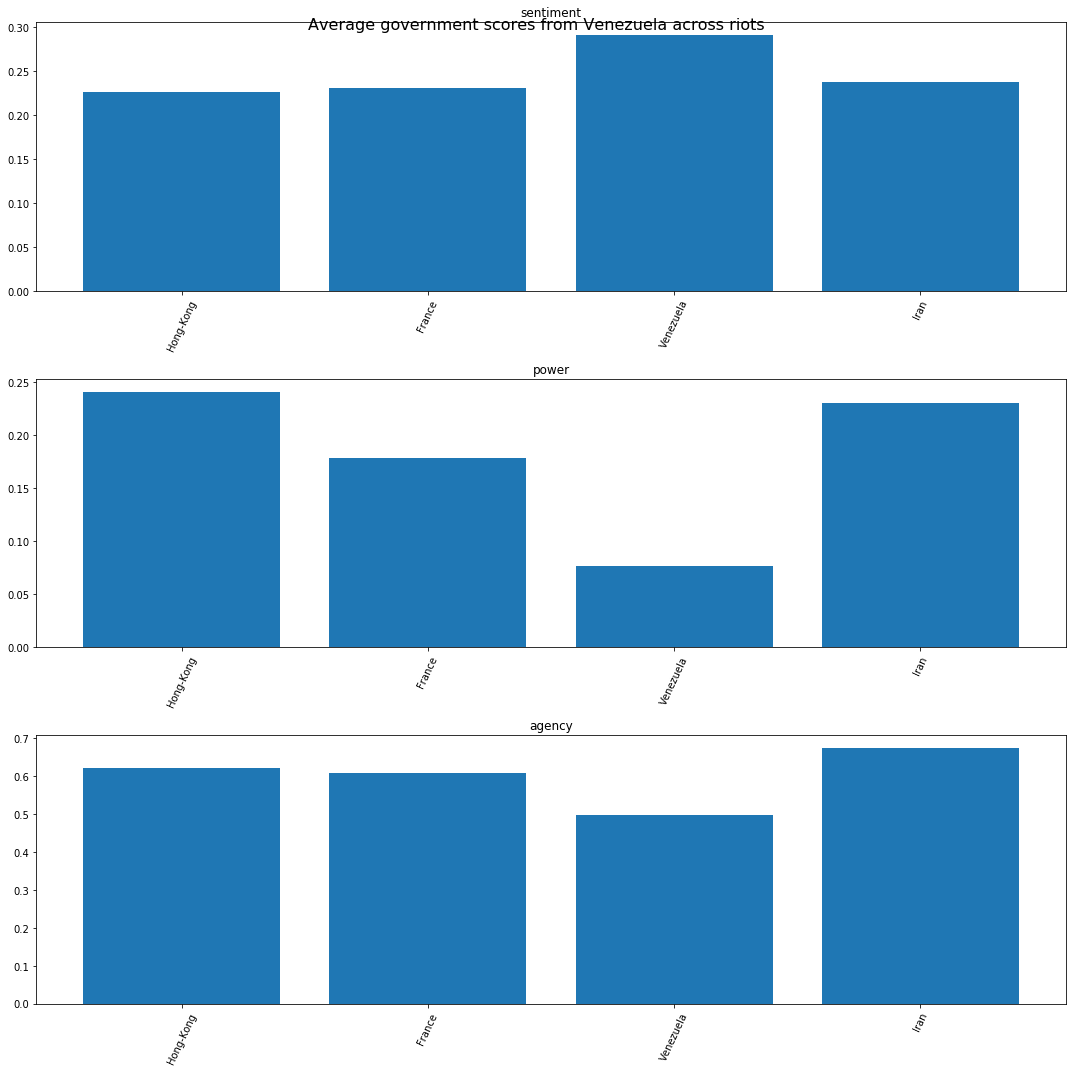

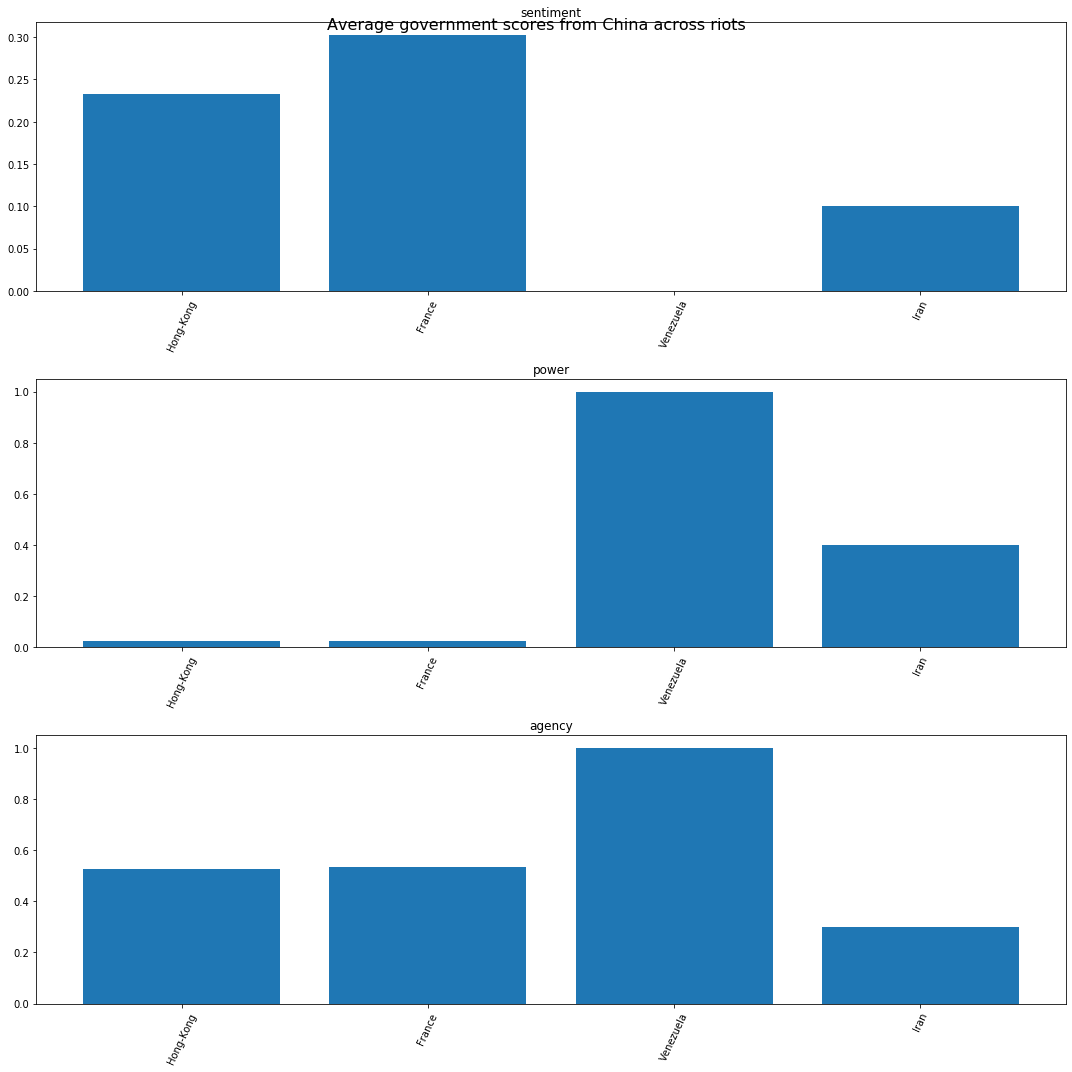

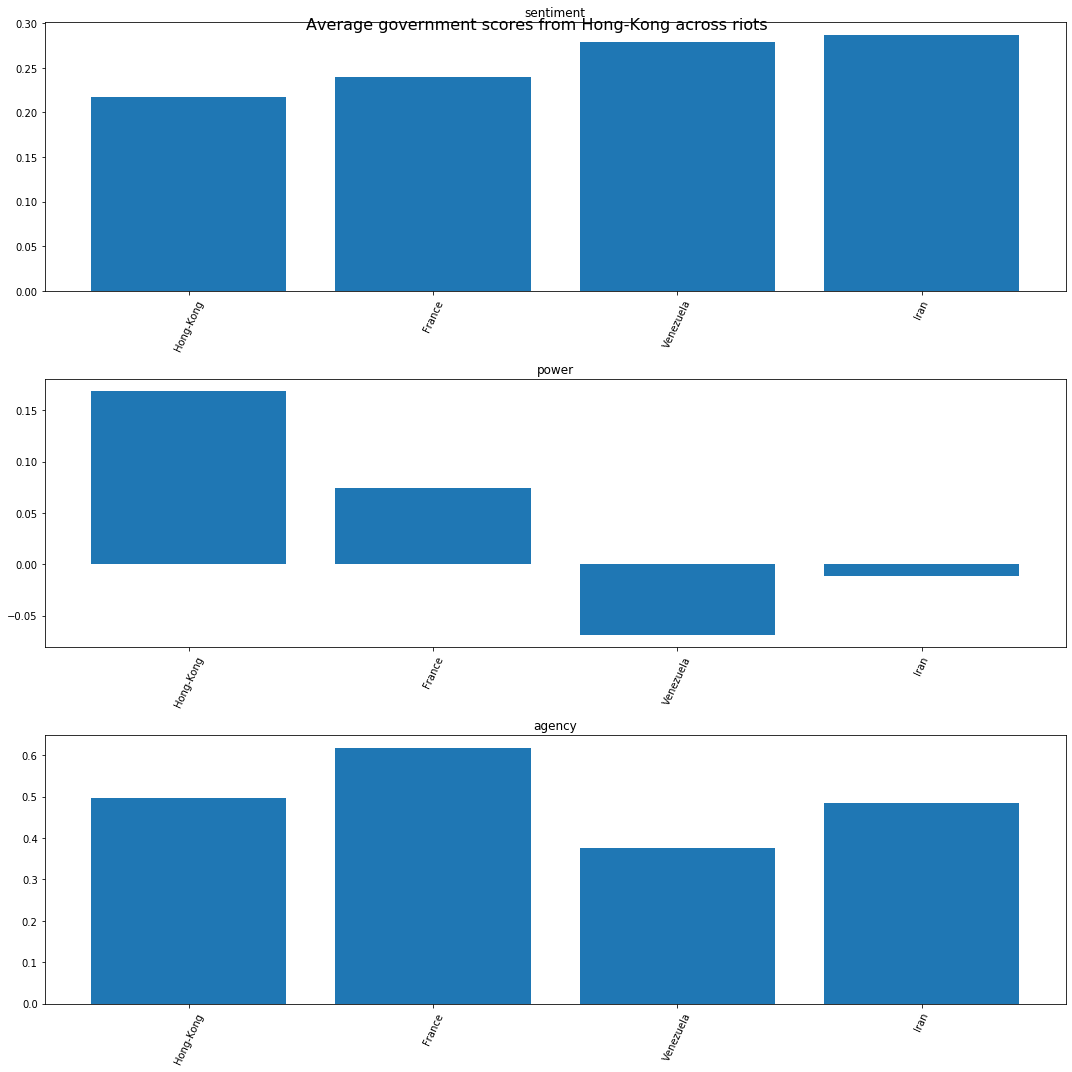

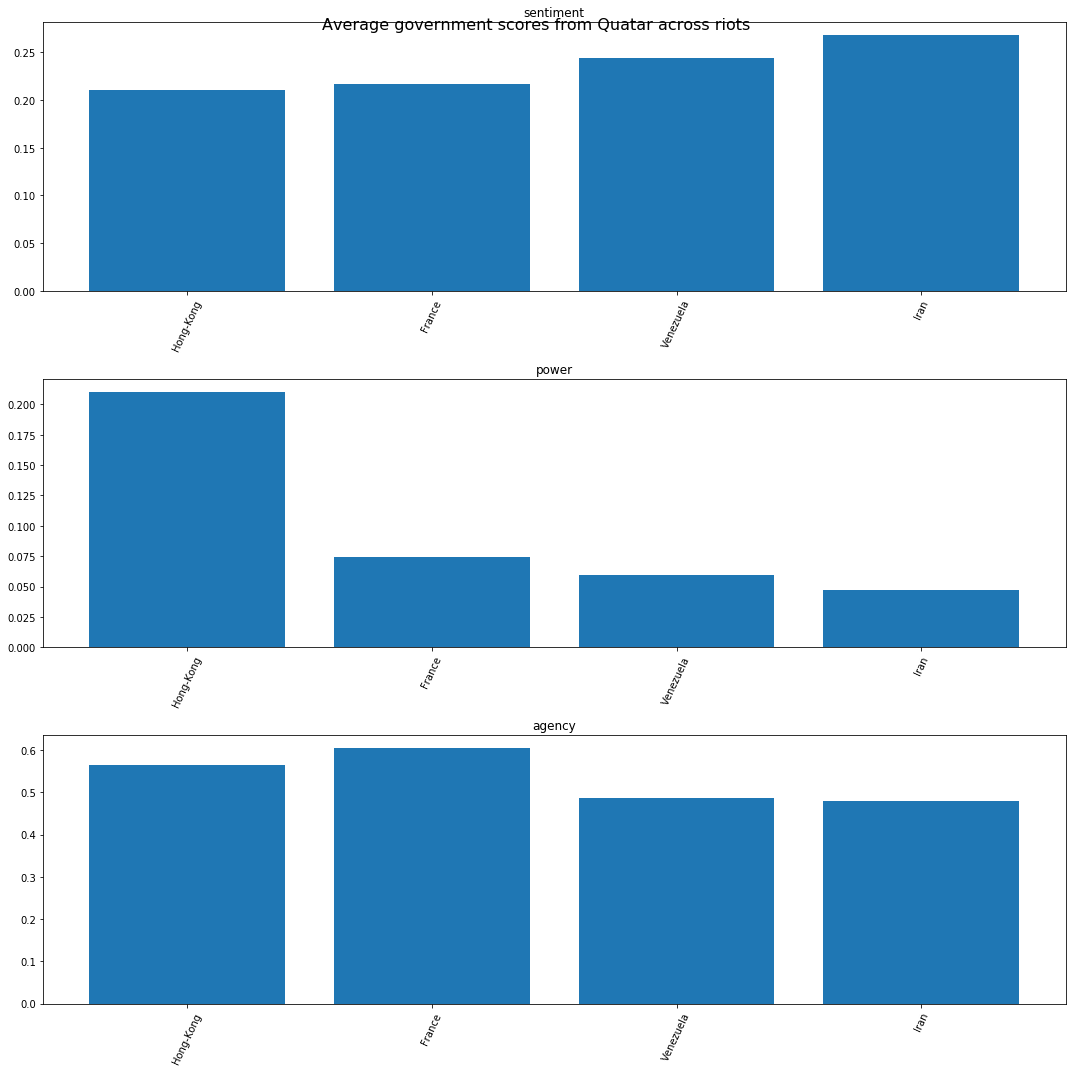

In [43]:
countries_gov = articleToCountry(source_riot_gov)
for country in countries_gov:
    scores = {riot : sumScores(scores) for riot, scores in countries_gov[country].items()}
    plotScores(scores , KEYS[:3],"Average government scores from {} across riots".format(country))

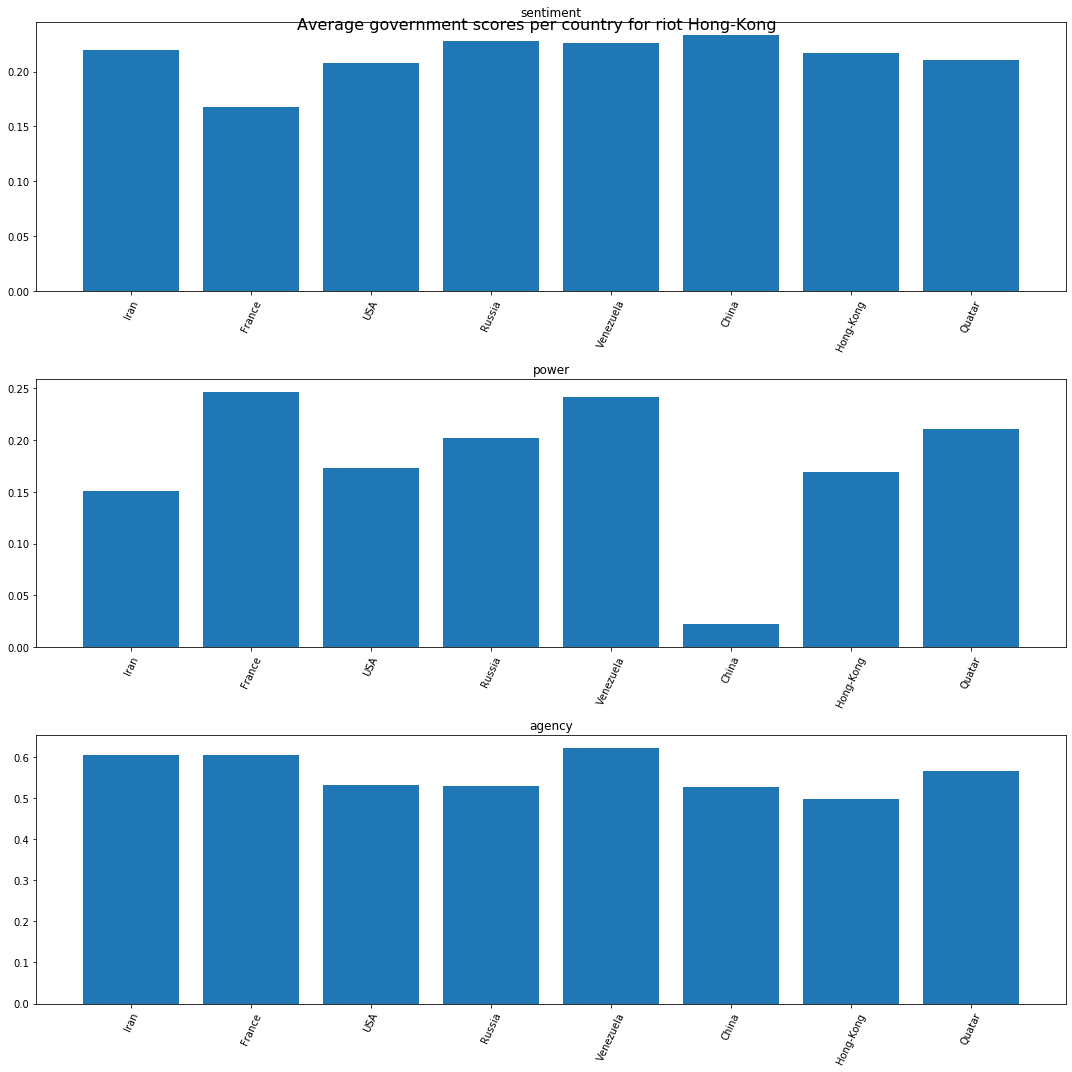

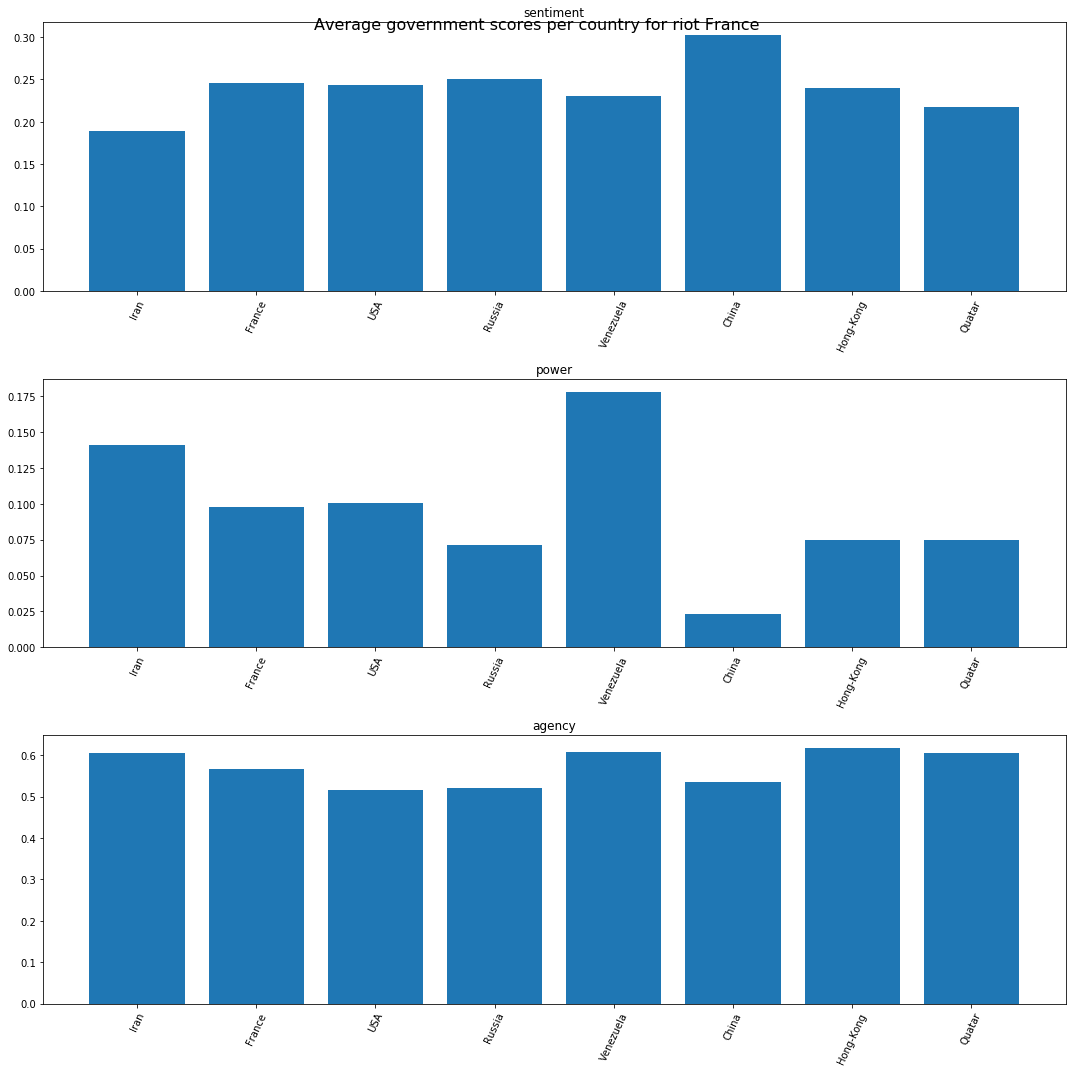

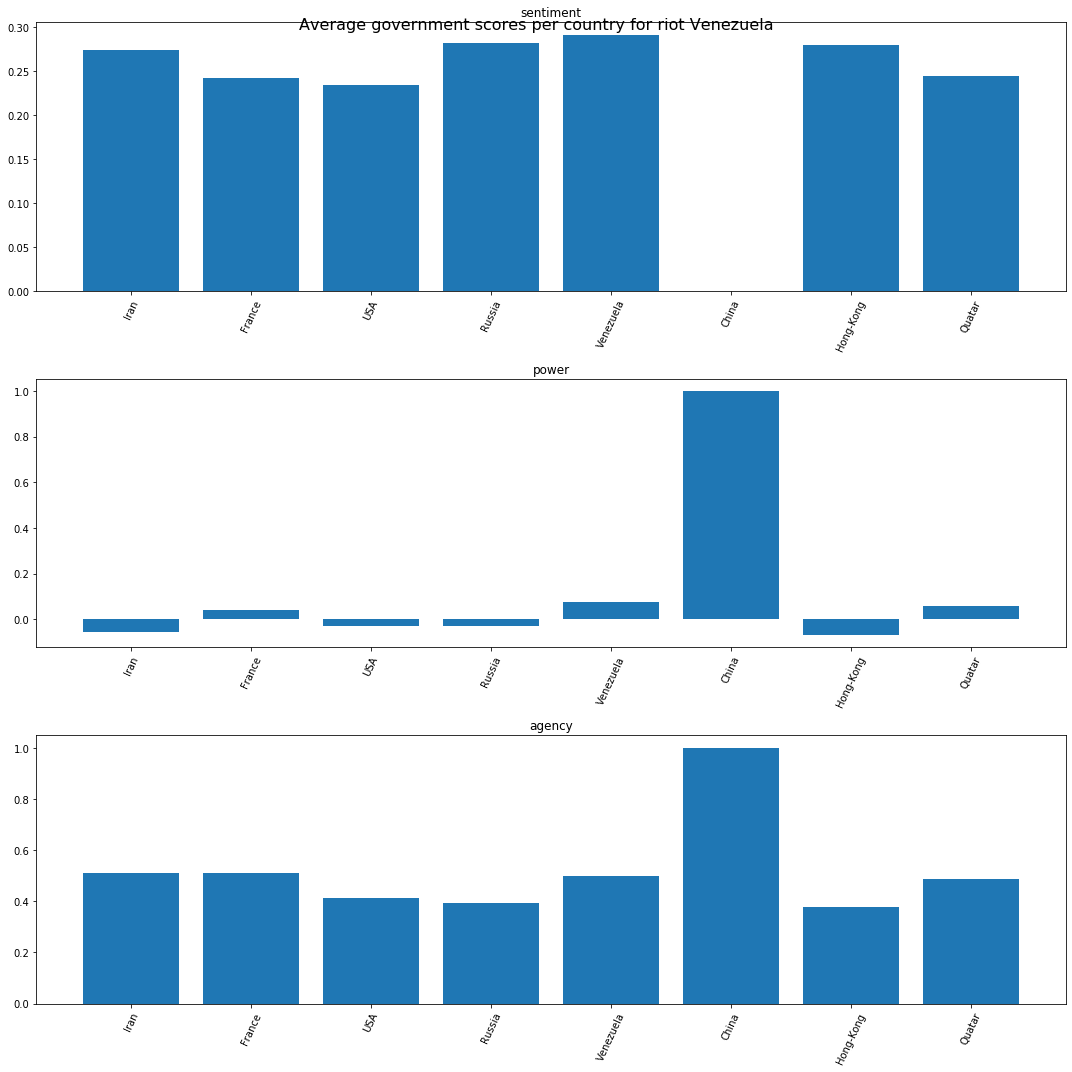

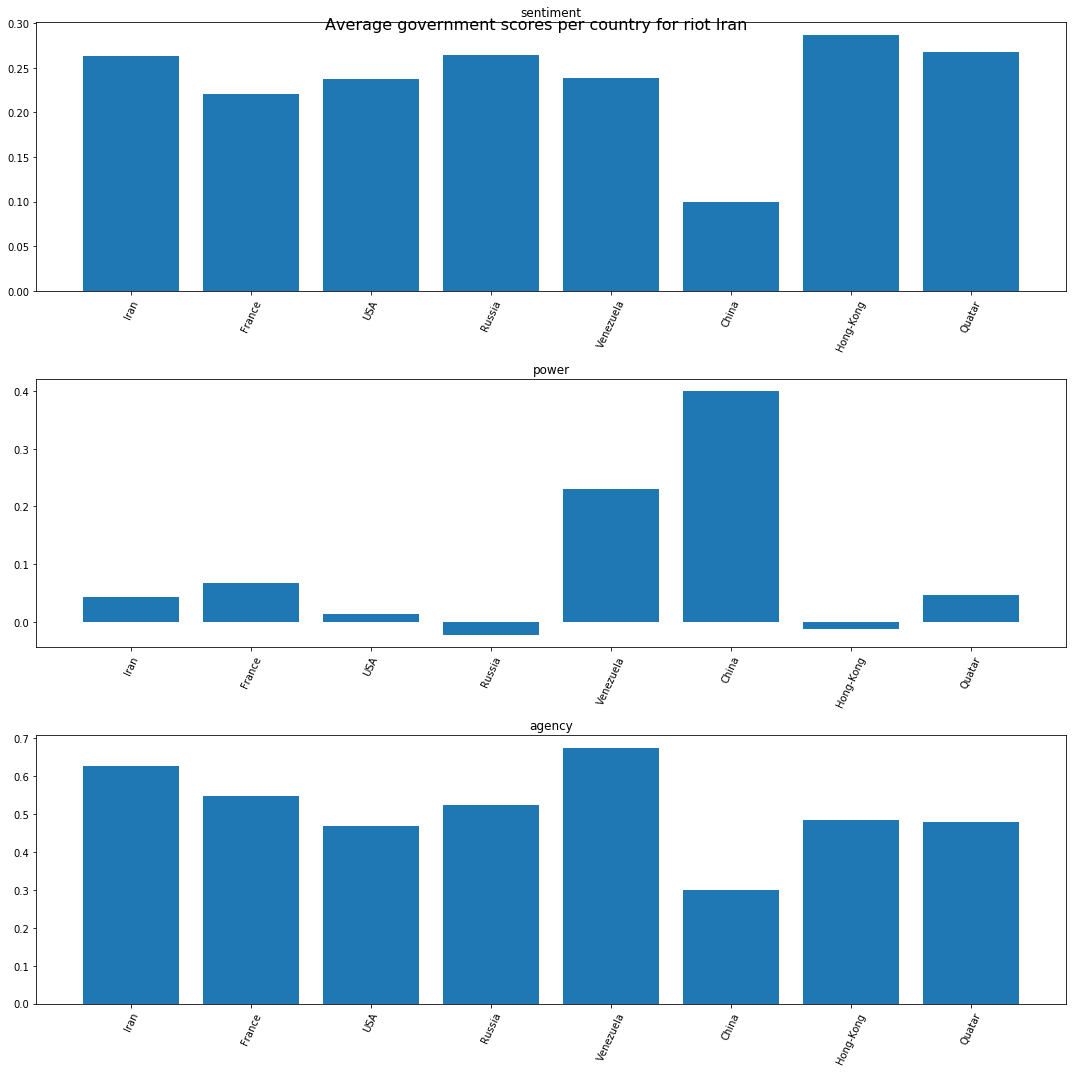

In [47]:
riot_countries_gov = flipRiotSource(countries_gov)

for riot in riot_countries_gov:
    scores = {country : sumScores(scores) for country, scores in riot_countries_gov[riot].items()}
    plotScores(scores , KEYS[:3],"Average government scores per country for riot {}".format(riot))

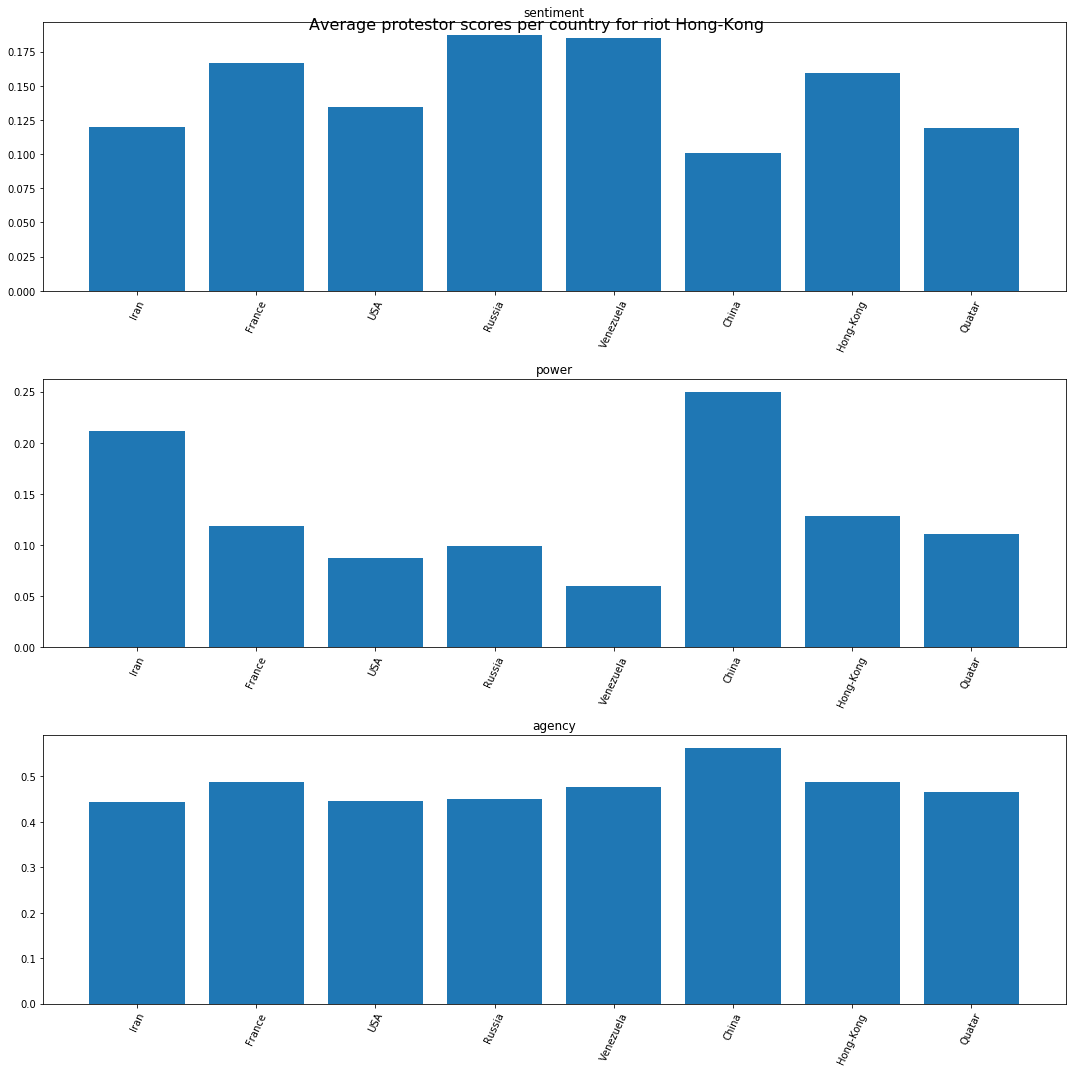

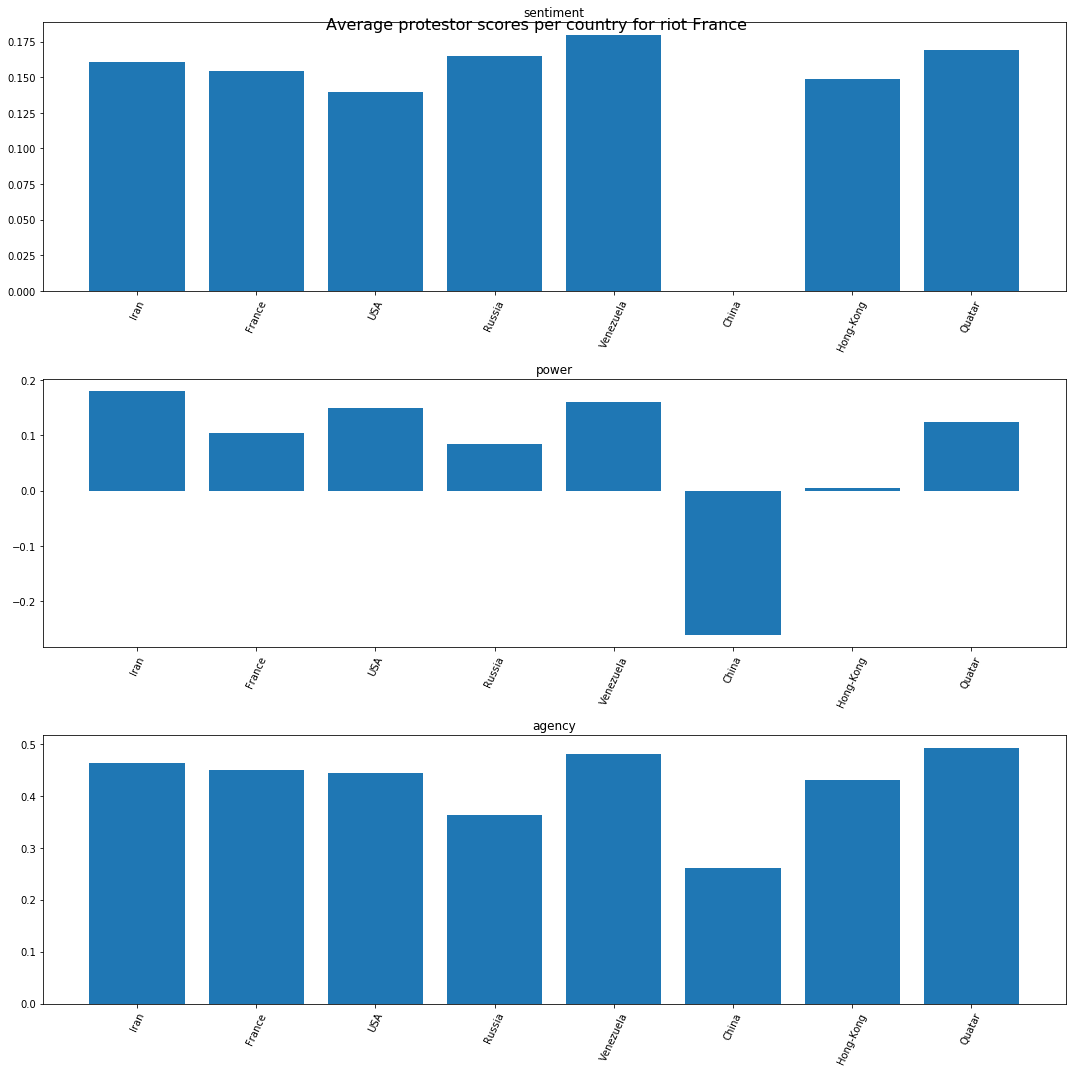

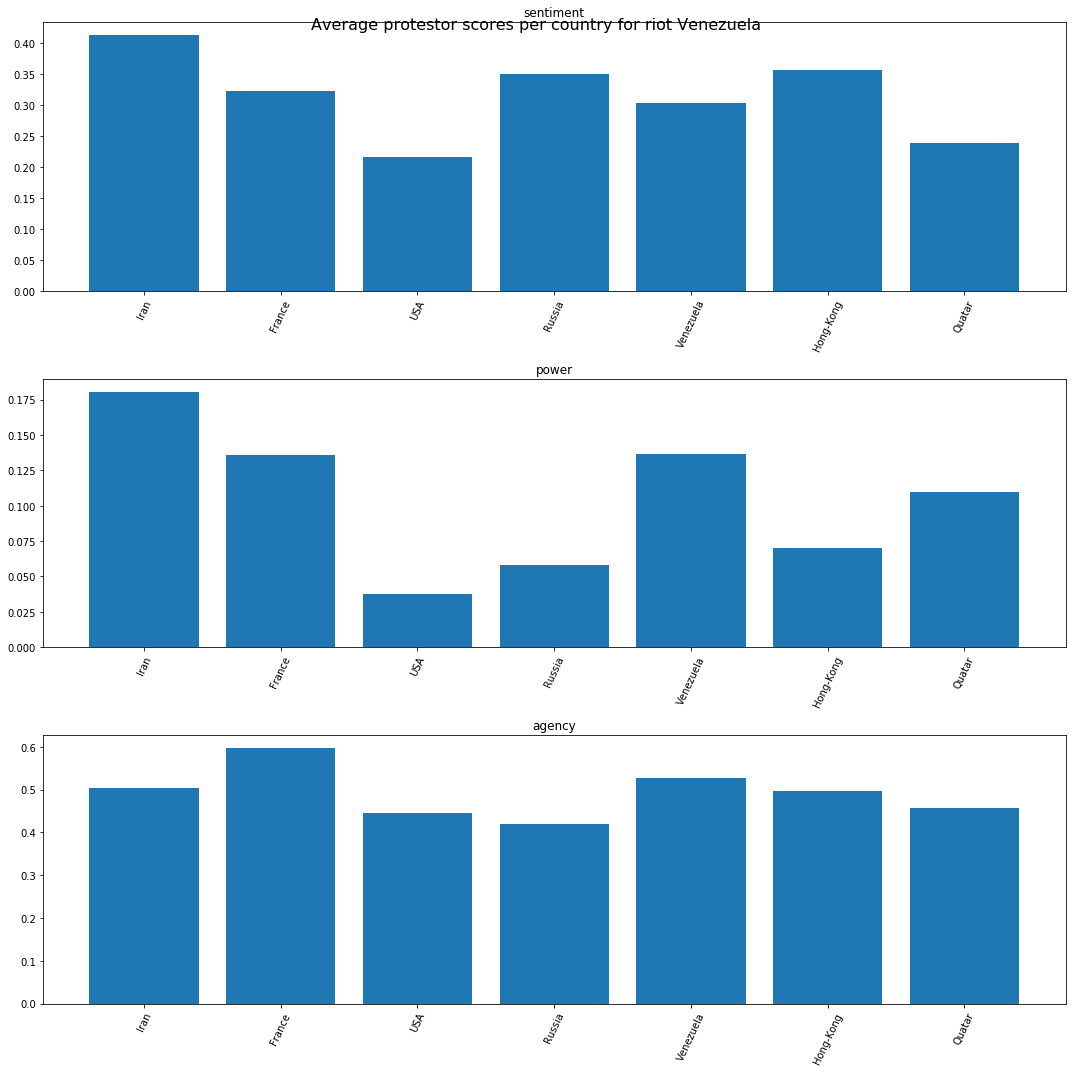

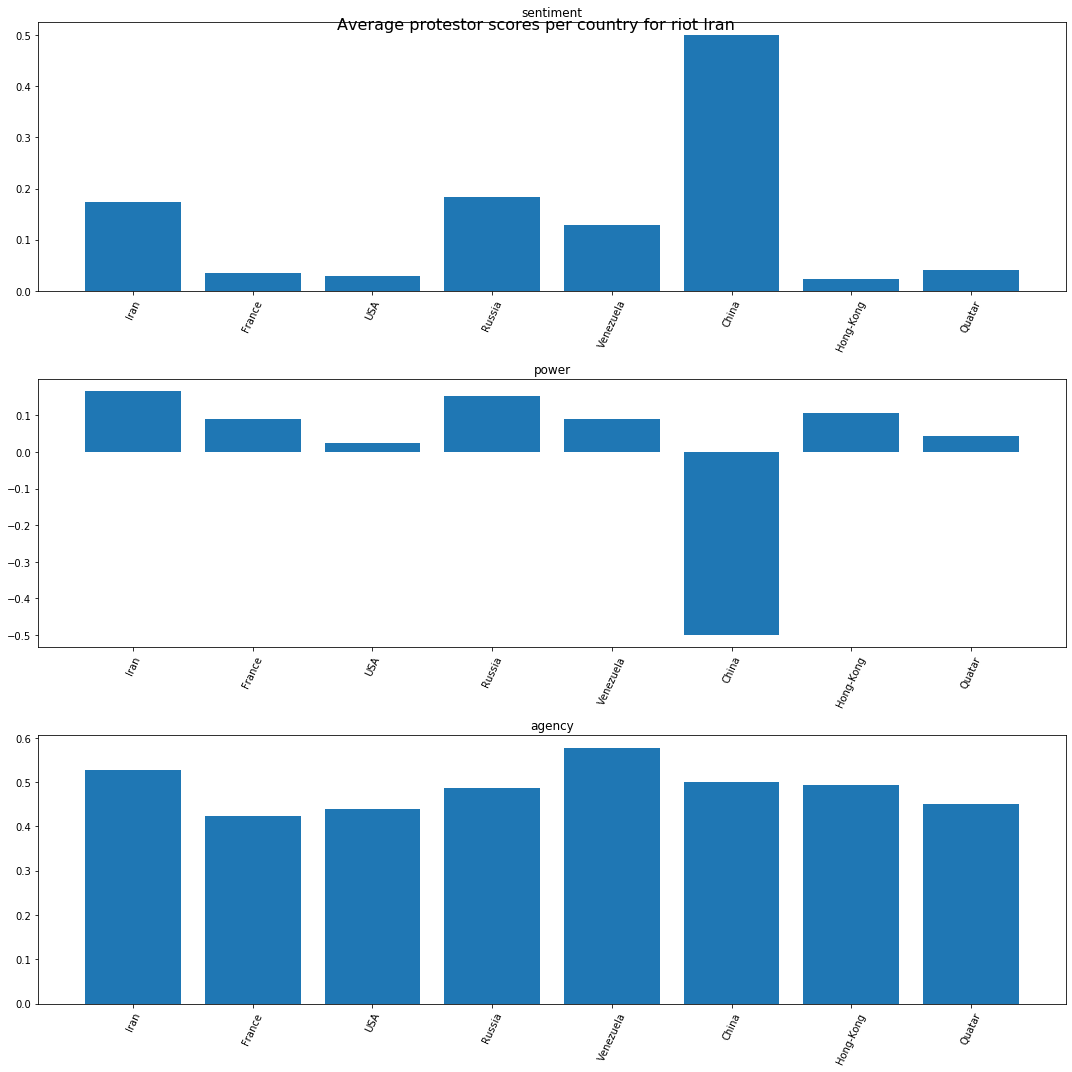

In [50]:
riot_countries_protestor = flipRiotSource(countries_protestor)

for riot in riot_countries_protestor:
    scores = {country : sumScores(scores) for country, scores in riot_countries_protestor[riot].items()}
    plotScores(scores , KEYS[:3],"Average protestor scores per country for riot {}".format(riot))